# 🌟 Urban Comfort Potential from Open Environmental Data

### Title:
**A reproducible and explainable framework for assessing urban environmental comfort and spatial inequality using open data.**

**Scope**

This notebook implements a fully auditable pipeline to estimate **urban environmental comfort potential** using open datasets only. It builds four structural dimensions:

* **Acoustic exposure** (road noise)
* **Vegetation** (NDVI)
* **Structural crowd pressure** (built and activity proxies)
* **Infrastructure related accessibility** (access and support proxies)

These dimensions are later combined into an interpretable **ComfortScore**.

**Does not:**
* Predict individual wellbeing
* Use personal data, behavioural tracking, or surveys

**Strategy**
* Use OpenStreetMap venues to define the Area of Interest and a consistent measurement support
* Acquire authoritative layers with cache aware scripts
* Save outputs with clear paths and simple provenance logs

## Notebook structure
1. Setup and reproducibility settings
2. Phase A Data acquisition
3. Phase B Feature engineering
4. Phase C ComfortScore model and explanation layer
5. Phase D External data download
6. Phase E External validation and spatial structure
7. Phase-F Final synthesis and future directions


**Setup and reproducibility settings**



In [1]:
# Core
import os
import re
import io
import json
import time
import glob
import zipfile
import hashlib
from pathlib import Path
from datetime import date, datetime, timezone
from concurrent.futures import ThreadPoolExecutor, as_completed

import mgrs
import rasterio
from rasterio.mask import mask
from rasterio.errors import RasterioIOError
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

# Data
import numpy as np
import pandas as pd
import geopandas as gpd
import requests

import warnings
warnings.filterwarnings("ignore")

print("Setup complete")


Setup complete


# 🎯 Phase-A Data acquisition

**Inputs acquired in Phase A**
* **Venues** from OpenStreetMap to define the Area of Interest
* **DEFRA road noise polygons** via the official OGC API Features endpoint
* **Sentinel 2 NDVI tiles** from CEDA, combined into a summer median composite

**Key reproducibility features**
* All downloads are **cached locally** and skipped on rerun when valid.
* Each dataset writes a **provenance JSON** with timestamps, sources, and key parameters.
* Manual access instructions are printed so a reviewer can verify sources without guessing.


## A0: Paths and study area

In [2]:
# We set a consistent folder structure used across all phases.

# Folder convention:
# `data/raw/` stores downloaded or source like files
# `data/processed/` stores cleaned and standardised outputs used downstream

# Notebook and project paths
NOTEBOOK_DIR = Path(".").resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent

DATA_DIR = PROJECT_ROOT / "data"
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"

RAW_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# Study area names as used by OSMnx
PLACE_NAMES = ["London Borough of Camden", "London Borough of Islington"]

# Venue outputs
VENUES_RAW_PATH = RAW_DIR / "venues_raw.geojson"
VENUES_CLEAN_PATH = PROCESSED_DIR / "venues_clean.geojson"

print("Project root:", PROJECT_ROOT)
print("Raw dir:", RAW_DIR)
print("Processed dir:", PROCESSED_DIR)
print("Study area:", PLACE_NAMES)


Project root: /home/sai/test/notebook_test
Raw dir: /home/sai/test/notebook_test/data/raw
Processed dir: /home/sai/test/notebook_test/data/processed
Study area: ['London Borough of Camden', 'London Borough of Islington']


## A1: Venues from OpenStreetMap

We start with a set of candidate venues.

Why venues first:
* They define the **spatial footprint** of where we measure comfort.
* Later features (noise, vegetation, roads, accessibility) are computed around each venue.
* This keeps the pipeline place based and avoids individual level inference.

Outputs:
* `data/raw/venues_raw.geojson`
* `data/processed/venues_clean.geojson`


In [3]:
# Try to import OSMnx
try:
    import osmnx as ox
    OSMNX_OK = True
except Exception as e:
    OSMNX_OK = False
    OSMNX_ERR = str(e)

print("OSMnx available:", OSMNX_OK)
if not OSMNX_OK:
    print("Import error:", OSMNX_ERR)


OSMnx available: True


### A1.1: Venue query and cleaning rules

We use a small set of OSM tags that match common peaceful or inclusive places.

Cleaning rules:
* Reproject to British National Grid for consistent distance calculations
* Keep a small set of stable columns
* Drop empty names to avoid unlabeled fragments
* Drop invalid geometries
* Deduplicate by OSM id
* Add representative point coordinates `x` and `y` for convenience


In [4]:
# Tags define what we treat as candidate venues
VENUE_TAGS = {
    "leisure": ["park", "garden", "nature_reserve"],
    "amenity": ["library", "cafe", "community_centre", "arts_centre", "museum"],
    "landuse": ["grass", "recreation_ground"],
}

# British National Grid for metre based buffers
TARGET_CRS = "EPSG:27700"

def fetch_venues_osm(place_names, tags):
    """Download OSM venues using OSMnx."""
    if not OSMNX_OK:
        raise ImportError("OSMnx is not available. Install osmnx to run this cell.")

    # OSMnx caching helps reproducibility and avoids repeated network calls
    ox.settings.log_console = True
    ox.settings.use_cache = True

    print("Fetching OSM venues for:", place_names)
    t0 = time.time()
    gdf = ox.features_from_place(place_names, tags=tags)
    gdf = gdf.reset_index()
    print("Fetched rows:", len(gdf), "in", round(time.time() - t0, 2), "seconds")
    return gdf

def clean_venues_osm(gdf):
    """Clean raw OSM venues for stable downstream use."""
    gdf = gdf.copy()

    # CRS handling
    if gdf.crs is None:
        gdf = gdf.set_crs("EPSG:4326")
    gdf = gdf.to_crs(TARGET_CRS)

    # Stable id
    if "id" not in gdf.columns:
        if "osmid" in gdf.columns:
            gdf["id"] = gdf["osmid"]
        else:
            gdf["id"] = np.arange(len(gdf))

    keep_cols = [
        "id", "name", "amenity", "leisure", "landuse",
        "wheelchair", "opening_hours", "operator", "geometry"
    ]
    keep_cols = [c for c in keep_cols if c in gdf.columns]
    gdf = gdf[keep_cols].copy()

    # Name cleaning
    gdf["name"] = gdf["name"].fillna("").astype(str).str.strip()
    mask_valid = gdf["name"].apply(lambda x: len(x) > 0 and x.lower() not in ["nan", "none"])
    gdf = gdf[mask_valid].copy()

    # Geometry cleaning
    gdf = gdf[gdf.geometry.notna() & ~gdf.geometry.is_empty].copy()

    # Deduplicate
    gdf["id"] = gdf["id"].astype(str)
    gdf = gdf.drop_duplicates(subset=["id"]).copy()

    # Representative point is safe for polygons and multipolygons
    rep = gdf.geometry.representative_point()
    gdf["x"] = rep.x
    gdf["y"] = rep.y

    print("Cleaned venues:", len(gdf))
    print("CRS:", gdf.crs)
    return gdf

def save_geojson(gdf, path):
    """Save GeoDataFrame to GeoJSON with folders created if needed."""
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    gdf.to_file(path, driver="GeoJSON")
    print("Saved:", str(path))


### A1.2: Run venue acquisition

Cache behaviour:
* If `venues_clean.geojson` exists and is non empty, we reuse it.
* Otherwise we fetch from OSM, save a raw copy, then save a cleaned version.


In [5]:
if VENUES_CLEAN_PATH.exists() and VENUES_CLEAN_PATH.stat().st_size > 0:
    print("Venues already present:", VENUES_CLEAN_PATH)
    venues = gpd.read_file(VENUES_CLEAN_PATH)
    print("Loaded venues:", len(venues))
else:
    venues_raw = fetch_venues_osm(PLACE_NAMES, VENUE_TAGS)
    save_geojson(venues_raw, VENUES_RAW_PATH)

    venues = clean_venues_osm(venues_raw)
    save_geojson(venues, VENUES_CLEAN_PATH)

venues.head()


Fetching OSM venues for: ['London Borough of Camden', 'London Borough of Islington']
Fetched rows: 2555 in 42.01 seconds
Saved: /home/sai/test/notebook_test/data/raw/venues_raw.geojson
Cleaned venues: 1211
CRS: EPSG:27700
Saved: /home/sai/test/notebook_test/data/processed/venues_clean.geojson


,id,name,amenity,leisure,landuse,wheelchair,opening_hours,operator,geometry,x,y
0,13799212,Holborn Library,library,NaN,NaN,yes,"Mo-Th 10:00-19:00, Fr 10:00-17:00, Sa 11:00-17:00",NaN,POINT (530835.223 181922.569),530835.223366,181922.569174
1,25475389,Woburn Cafe,cafe,NaN,NaN,NaN,NaN,NaN,POINT (529873.562 182510.483),529873.561987,182510.483335
2,25497832,Cafe Angel,cafe,NaN,NaN,NaN,NaN,NaN,POINT (530790.094 182331.853),530790.093853,182331.853236
3,248231088,Kalendar,cafe,NaN,NaN,NaN,NaN,NaN,POINT (528356.799 186417.814),528356.798695,186417.813973
4,267971989,The Brew House Café,cafe,NaN,NaN,NaN,Dec-Jan: Mo-Su 09:00-16:00; Feb-Mar: Mo-Su 09:...,English Heritage,POINT (527143.833 187468.195),527143.832630,187468.194588


## A2: DEFRA strategic road noise via OGC API Features

We retrieve DEFRA road noise polygons using the official OGC API Features service.

Why this method is defensible:
* It uses an **official API endpoint** rather than time limited file links.
* The query is bounded to the study area using a venue based Area of Interest.
* The output is stored as a GeoPackage for stable downstream processing.




In [6]:
from datetime import datetime, timezone

# Paths
DEFRA_DIR = RAW_DIR / "defra_noise"
DEFRA_DIR.mkdir(parents=True, exist_ok=True)

DEFRA_OUT_GPKG = DEFRA_DIR / "defra_road_noise_lden_round3_aoi.gpkg"
DEFRA_LAYER = "defra_road_noise_lden_round3_aoi"
DEFRA_PROVENANCE = DEFRA_DIR / "provenance_defra.json"

# AOI buffer expands beyond venues to include local context
AOI_BUFFER_M = 2500

# Set True if you want to force a fresh pull from the API
REFRESH_DEFRA = False

# DEFRA dataset identifiers
DATASET_ID = "fd1c6327-ad77-42ae-a761-7c6a0866523d"
COLLECTION_ID = "Road_Noise_Lden_England_Round_3"

OGC_BASE = f"https://environment.data.gov.uk/geoservices/datasets/{DATASET_ID}/ogc/features/v1"
ITEMS_URL = f"{OGC_BASE}/collections/{COLLECTION_ID}/items"
SOURCE_PAGE_URL = f"https://environment.data.gov.uk/dataset/{DATASET_ID}"

def now_utc_iso():
    return datetime.now(timezone.utc).isoformat()

def load_json_safe(path: Path):
    try:
        if path.exists():
            return json.loads(path.read_text(encoding="utf-8"))
    except Exception:
        pass
    return []

def save_json(path: Path, obj):
    path.write_text(json.dumps(obj, indent=2), encoding="utf-8")

def valid_gpkg(path: Path):
    return path.exists() and path.stat().st_size > 0

def print_manual_defra_instructions():
    print("")
    print("Manual verification instructions")
    print("Source page:", SOURCE_PAGE_URL)
    print("Dataset:", COLLECTION_ID)
    print("Look for a GeoPackage download option if you want to cross check the API output")

def build_aoi_from_venues(venues_path: Path, buffer_m: float):
    v = gpd.read_file(venues_path)
    if v.crs is None:
        raise ValueError("venues CRS missing")
    v = v.to_crs("EPSG:27700")
    try:
        geom = v.geometry.union_all()
    except Exception:
        geom = v.unary_union
    aoi = geom.convex_hull.buffer(float(buffer_m))
    return aoi, aoi.bounds

def fetch_all_features_bbox(bbox_27700, limit=10000, timeout_s=90):
    # Bounding box query in EPSG:27700
    params = {
        "bbox": ",".join([str(x) for x in bbox_27700]),
        "bbox-crs": "http://www.opengis.net/def/crs/EPSG/0/27700",
        "crs": "http://www.opengis.net/def/crs/EPSG/0/27700",
        "limit": int(limit),
        "f": "application/geo+json",
    }

    try:
        from tqdm.auto import tqdm
        use_tqdm = True
    except Exception:
        use_tqdm = False

    features = []
    url = ITEMS_URL
    page = 0

    pbar = None
    if use_tqdm:
        pbar = tqdm(desc="DEFRA pages", unit="page")

    while True:
        page += 1
        r = requests.get(url, params=params, timeout=timeout_s)
        r.raise_for_status()
        js = r.json()

        chunk = js.get("features", [])
        features.extend(chunk)

        next_url = None
        for link in js.get("links", []):
            if link.get("rel") == "next":
                next_url = link.get("href")
                break

        if use_tqdm:
            pbar.update(1)
            pbar.set_postfix({
                "page": page,
                "page_features": len(chunk),
                "total_features": len(features),
            })
        else:
            print("DEFRA page", page, "features", len(chunk), "total", len(features))

        if not next_url:
            break

        # After the first page the next URL usually includes params
        url = next_url
        params = None

        # Safety stop to avoid infinite loops
        if page > 500:
            raise RuntimeError("Too many pages returned")

    if use_tqdm:
        pbar.close()

    return features

def ensure_defra_noise_aoi(venues_path: Path):
    provenance = load_json_safe(DEFRA_PROVENANCE)

    # Cache hit
    if valid_gpkg(DEFRA_OUT_GPKG) and not REFRESH_DEFRA:
        print("DEFRA noise already present, skipping download")
        print("Output file:", DEFRA_OUT_GPKG)
        print_manual_defra_instructions()

        provenance.append({
            "dataset": "DEFRA Road Noise Lden Round 3",
            "method": "ogc_api_features_bbox",
            "status": "already_present",
            "checked_at_utc": now_utc_iso(),
            "output": str(DEFRA_OUT_GPKG)
        })
        save_json(DEFRA_PROVENANCE, provenance)
        return DEFRA_OUT_GPKG

    # Build AOI from venues and query using its bounding box
    _aoi_geom, bbox = build_aoi_from_venues(venues_path, AOI_BUFFER_M)

    t0 = time.time()
    features = fetch_all_features_bbox(bbox)
    if not features:
        raise RuntimeError("No DEFRA features returned")

    gdf = gpd.GeoDataFrame.from_features(features, crs="EPSG:27700")
    gdf = gdf[gdf.geometry.notna() & ~gdf.geometry.is_empty].copy()

    # Overwrite if present
    if DEFRA_OUT_GPKG.exists():
        DEFRA_OUT_GPKG.unlink()

    gdf.to_file(DEFRA_OUT_GPKG, layer=DEFRA_LAYER, driver="GPKG")

    provenance.append({
        "dataset": "DEFRA Road Noise Lden Round 3",
        "method": "ogc_api_features_bbox",
        "status": "downloaded",
        "downloaded_at_utc": now_utc_iso(),
        "source_items_url": ITEMS_URL,
        "source_page": SOURCE_PAGE_URL,
        "aoi_buffer_m": AOI_BUFFER_M,
        "bbox_27700": [float(x) for x in bbox],
        "n_features": int(len(gdf)),
        "runtime_s": float(time.time() - t0),
        "output": str(DEFRA_OUT_GPKG)
    })
    save_json(DEFRA_PROVENANCE, provenance)

    print("DEFRA AOI noise saved")
    print("Total features:", len(gdf))
    print("Output file:", DEFRA_OUT_GPKG)
    print_manual_defra_instructions()
    return DEFRA_OUT_GPKG

# Run acquisition
defra_noise_gpkg = ensure_defra_noise_aoi(VENUES_CLEAN_PATH)
defra_noise_gpkg


DEFRA pages: 0page [00:00, ?page/s]

DEFRA AOI noise saved
Total features: 53137
Output file: /home/sai/test/notebook_test/data/raw/defra_noise/defra_road_noise_lden_round3_aoi.gpkg

Manual verification instructions
Source page: https://environment.data.gov.uk/dataset/fd1c6327-ad77-42ae-a761-7c6a0866523d
Dataset: Road_Noise_Lden_England_Round_3
Look for a GeoPackage download option if you want to cross check the API output


PosixPath('/home/sai/test/notebook_test/data/raw/defra_noise/defra_road_noise_lden_round3_aoi.gpkg')

## A3: Sentinel 2 NDVI from CEDA and summer median composite

We build a robust summer NDVI composite to represent vegetation.

Approach:
* Infer the Sentinel tile code from the venue centroid
* For each target month, select one valid tile image
* Run integrity checks to avoid partial or corrupted TIFF downloads
* Clip each NDVI image to the venue based Area of Interest
* Compute a **median** composite across selected summer images

Note: 
NDVI and strategic road noise layers represent slowly varying structural environmental conditions.
Venue locations are used as spatial anchors to sample these conditions rather than as time specific observations.
The framework therefore estimates structural comfort potential rather than historical realised comfort at a specific year.


In [7]:
# Settings
YEAR = 2017
MONTHS_TARGET = [6, 7, 8]
WORKERS = 6

AOI_BUFFER_M = 2500
CEDA_BASE = "https://dap.ceda.ac.uk/neodc/sentinel_ard/products/indices/sentinel_2/ndvi/v2"
SOURCE_URL = "https://data.ceda.ac.uk/neodc/sentinel_ard/products/indices/sentinel_2/ndvi/v2/"

NDVI_DIR = RAW_DIR / "ndvi"
NDVI_FILES_DIR = NDVI_DIR / "files"
NDVI_DIR.mkdir(parents=True, exist_ok=True)
NDVI_FILES_DIR.mkdir(parents=True, exist_ok=True)

NDVI_PROVENANCE = NDVI_DIR / "provenance_ndvi.json"

# Set True if you want to rebuild the composite
REFRESH_NDVI = False

LIST_TIMEOUT = (10, 25)
DL_TIMEOUT = (20, 900)
CHUNK = 1024 * 1024

def now_utc_iso():
    return datetime.now(timezone.utc).isoformat()

def sha256_file(path: Path):
    h = hashlib.sha256()
    with Path(path).open("rb") as f:
        for chunk in iter(lambda: f.read(1024 * 1024), b""):
            h.update(chunk)
    return h.hexdigest()

def load_json_safely(path: Path):
    try:
        if path.exists():
            return json.loads(path.read_text(encoding="utf-8"))
    except Exception:
        return []
    return []

def save_json(path: Path, obj):
    path.write_text(json.dumps(obj, indent=2), encoding="utf-8")

def valid_file(path: Path):
    return path.exists() and path.stat().st_size > 0

def print_manual_ndvi_instructions(tile_code: str):
    print("")
    print("Manual verification instructions")
    print("Source directory:", f"{SOURCE_URL}/{YEAR:04d}/")
    print("Tile:", f"T{tile_code}" " " "(Note:Inner London, including Camden and Islington, falls inside the Sentinel 2 tile T30UXC.)" )
    print("Target months:", MONTHS_TARGET)
    print("If you need manual download, place NDVI GeoTIFFs into:")
    print(" ", str(NDVI_FILES_DIR))

def make_session():
    s = requests.Session()
    retry = Retry(total=5, backoff_factor=0.5, status_forcelist=[429, 500, 502, 503, 504])
    adapter = HTTPAdapter(max_retries=retry)
    s.mount("https://", adapter)
    s.mount("http://", adapter)
    return s

def get_aoi_geometry_from_venues(venues_path: Path, buffer_m: float):
    v = gpd.read_file(venues_path)
    if v.crs is None:
        raise ValueError("venues CRS missing")
    v = v.to_crs("EPSG:27700")
    try:
        geom = v.geometry.union_all()
    except Exception:
        geom = v.unary_union
    return geom.convex_hull.buffer(float(buffer_m))

def infer_mgrs_tile_from_venues(venues_path: Path):
    v = gpd.read_file(venues_path)
    if v.crs is None:
        raise ValueError("venues CRS missing")
    v = v.to_crs("EPSG:4326")
    try:
        geom = v.geometry.union_all()
    except Exception:
        geom = v.unary_union
    c = geom.centroid
    m = mgrs.MGRS()
    code = m.toMGRS(c.y, c.x, MGRSPrecision=0)
    if isinstance(code, bytes):
        code = code.decode("utf-8")
    return str(code)

def robust_get_text(session: requests.Session, url: str, timeout=LIST_TIMEOUT):
    r = session.get(url, timeout=timeout)
    r.raise_for_status()
    return r.text

def list_tif_links(html: str, base_url: str):
    links = re.findall(r'href="([^"]+\.tif)"', html, flags=re.IGNORECASE)
    out = []
    for lnk in links:
        if lnk.startswith("http"):
            out.append(lnk)
        else:
            out.append(base_url.rstrip("/") + "/" + lnk.lstrip("/"))
    return out

def list_days_in_month(session: requests.Session, year: int, month: int):
    month_url = f"{CEDA_BASE}/{year:04d}/{month:02d}/"
    html = robust_get_text(session, month_url)
    return sorted({int(d) for d in re.findall(r'href="(\d{2})\/"', html)})

def find_all_tile_files_for_day(session: requests.Session, tile: str, year: int, month: int, day: int):
    day_url = f"{CEDA_BASE}/{year:04d}/{month:02d}/{day:02d}/"
    try:
        html = robust_get_text(session, day_url)
        tifs = list_tif_links(html, day_url)
        matches = [u for u in tifs if f"_T{tile}_" in u and "NDVI" in u.upper()]
        if matches:
            return date(year, month, day), matches
    except Exception:
        return None
    return None

def scan_month_for_tile_candidates(session: requests.Session, tile: str, year: int, month: int, workers: int = 6):
    days = list_days_in_month(session, year, month)

    try:
        from tqdm.auto import tqdm
        use_tqdm = True
    except Exception:
        use_tqdm = False

    found = []
    with ThreadPoolExecutor(max_workers=int(workers)) as ex:
        futs = [ex.submit(find_all_tile_files_for_day, session, tile, year, month, d) for d in days]
        it = as_completed(futs)
        if use_tqdm:
            it = tqdm(it, total=len(futs), desc=f"Scan {year}-{month:02d}", unit="day")
        for f in it:
            out = f.result()
            if out:
                found.append(out)

    if not found:
        return []

    found.sort(key=lambda x: x[0])
    candidates = []
    for d, urls in found:
        for u in urls:
            candidates.append((d, u))
    return candidates

def raster_read_test(tif_path: Path):
    """Quick integrity test to catch partial or corrupted TIFFs."""
    if not valid_file(tif_path):
        return False
    try:
        with rasterio.open(tif_path) as src:
            h = int(src.height)
            w = int(src.width)
            if h <= 0 or w <= 0:
                return False
            row0 = max(0, (h // 2) - 8)
            col0 = max(0, (w // 2) - 8)
            window = rasterio.windows.Window(col0, row0, 16, 16)
            _ = src.read(1, window=window, boundless=True)
        return True
    except Exception:
        return False

def download_file_with_progress(session: requests.Session, url: str, out_path: Path):
    """Download a single file with retry and a post download integrity check."""
    out_path = Path(out_path)

    # Cache hit
    if valid_file(out_path) and raster_read_test(out_path):
        return "already_present", sha256_file(out_path)

    # Remove broken file before retry
    if out_path.exists():
        try:
            out_path.unlink()
        except Exception:
            pass

    try:
        from tqdm.auto import tqdm
        use_tqdm = True
    except Exception:
        use_tqdm = False

    with session.get(url, stream=True, timeout=DL_TIMEOUT) as r:
        r.raise_for_status()
        total = r.headers.get("Content-Length")
        total = int(total) if total and total.isdigit() else None

        pbar = None
        if use_tqdm:
            pbar = tqdm(total=total, unit="B", unit_scale=True, desc=out_path.name, leave=False)

        with out_path.open("wb") as f:
            for chunk in r.iter_content(chunk_size=CHUNK):
                if not chunk:
                    continue
                f.write(chunk)
                if pbar is not None:
                    pbar.update(len(chunk))

        if pbar is not None:
            pbar.close()

    # Validate
    if not raster_read_test(out_path):
        try:
            out_path.unlink()
        except Exception:
            pass
        return "download_failed_or_corrupt", None

    return "downloaded", sha256_file(out_path)

def write_median_composite(tif_paths, aoi_geom, out_tif: Path):
    """Clip inputs to AOI and write a median NDVI composite."""
    arrays = []
    meta = None
    bad = []

    for p in tif_paths:
        p = Path(p)
        if not raster_read_test(p):
            bad.append(p.name)
            continue

        try:
            with rasterio.open(p) as src:
                clipped, transform = mask(src, [aoi_geom], crop=True)
                arr = clipped[0].astype(np.float32)

                nodata = src.nodata
                if nodata is not None:
                    arr = np.where(arr == nodata, np.nan, arr)

                arrays.append(arr)

                if meta is None:
                    meta = src.meta.copy()
                    meta.update(
                        height=clipped.shape[1],
                        width=clipped.shape[2],
                        transform=transform,
                        nodata=-9999,
                        dtype="float32",
                        count=1,
                    )
        except (RasterioIOError, Exception):
            bad.append(p.name)
            continue

    if len(arrays) == 0:
        raise RuntimeError("All NDVI inputs failed integrity checks, cannot build composite")

    stack = np.stack(arrays)
    med = np.nanmedian(stack, axis=0)
    med = np.where(np.isfinite(med), med, -9999).astype(np.float32)

    out_tif = Path(out_tif)
    with rasterio.open(out_tif, "w", **meta) as dst:
        dst.write(med, 1)

    return bad

def ensure_ndvi_composite():
    tile = infer_mgrs_tile_from_venues(VENUES_CLEAN_PATH)
    aoi = get_aoi_geometry_from_venues(VENUES_CLEAN_PATH, AOI_BUFFER_M)
    out_tif = NDVI_DIR / f"ndvi_median_summer_{YEAR}_T{tile}_aoi.tif"

    prov = load_json_safely(NDVI_PROVENANCE)

    # Always print manual instructions for auditability
    print_manual_ndvi_instructions(tile)

    # Cache hit
    if valid_file(out_tif) and not REFRESH_NDVI:
        print("")
        print("NDVI composite already present, skipping build")
        print("Output file:", out_tif)
        prov.append({
            "created_at_utc": now_utc_iso(),
            "status": "already_present",
            "year": YEAR,
            "months": MONTHS_TARGET,
            "tile": tile,
            "aoi_buffer_m": AOI_BUFFER_M,
            "output_composite": str(out_tif)
        })
        save_json(NDVI_PROVENANCE, prov)
        return out_tif

    session = make_session()
    downloads = []
    used = []

    for mth in MONTHS_TARGET:
        print("")
        print("Scanning", YEAR, f"{mth:02d}")
        candidates = scan_month_for_tile_candidates(session, tile, YEAR, mth, workers=WORKERS)

        if not candidates:
            print("No tile match found in this month")
            continue

        chosen = None
        for d, url in candidates:
            fname = url.split("/")[-1].split("?")[0]
            out_path = NDVI_FILES_DIR / fname

            status, fhash = download_file_with_progress(session, url, out_path)
            used.append({
                "month": int(mth),
                "selected_date": str(d),
                "url": url,
                "file": fname,
                "status": status,
                "sha256": fhash
            })

            print("Candidate:", d, fname, status)

            if status in ["already_present", "downloaded"]:
                chosen = out_path
                break

        if chosen is None:
            print("All candidates failed for this month")
            continue

        downloads.append(chosen)
        print("Selected for composite:", chosen.name)

    if len(downloads) == 0:
        raise RuntimeError("No valid NDVI files available, cannot create composite")

    print("")
    print("Building median composite from", len(downloads), "images")
    t0 = time.time()
    bad_inputs = write_median_composite(downloads, aoi, out_tif)
    runtime_s = float(time.time() - t0)

    prov.append({
        "created_at_utc": now_utc_iso(),
        "status": "built",
        "year": YEAR,
        "months": MONTHS_TARGET,
        "tile": tile,
        "aoi_buffer_m": AOI_BUFFER_M,
        "downloaded_files": used,
        "output_composite": str(out_tif),
        "output_sha256": sha256_file(out_tif),
        "build_runtime_s": runtime_s,
        "bad_inputs_skipped": bad_inputs
    })
    save_json(NDVI_PROVENANCE, prov)

    print("Saved NDVI composite:", out_tif)
    if bad_inputs:
        print("Skipped corrupted inputs:", bad_inputs)

    return out_tif

ndvi_composite_path = ensure_ndvi_composite()
ndvi_composite_path


print("Note: NDVI is extracted for 2017 to maintain temporal consistency with the DEFRA noise dataset.")


Manual verification instructions
Source directory: https://data.ceda.ac.uk/neodc/sentinel_ard/products/indices/sentinel_2/ndvi/v2//2017/
Tile: T30UXC (Note:Inner London, including Camden and Islington, falls inside the Sentinel 2 tile T30UXC.)
Target months: [6, 7, 8]
If you need manual download, place NDVI GeoTIFFs into:
  /home/sai/test/notebook_test/data/raw/ndvi/files

Scanning 2017 06


Scan 2017-06:   0%|          | 0/18 [00:00<?, ?day/s]

S2A_20170601_lat52lon075_T30UXC_ORB137_utm30n_osgb_NDVI.tif:   0%|          | 0.00/505M [00:00<?, ?B/s]

Candidate: 2017-06-01 S2A_20170601_lat52lon075_T30UXC_ORB137_utm30n_osgb_NDVI.tif downloaded
Selected for composite: S2A_20170601_lat52lon075_T30UXC_ORB137_utm30n_osgb_NDVI.tif

Scanning 2017 07


Scan 2017-07:   0%|          | 0/25 [00:00<?, ?day/s]

S2A_20170731_lat52lon075_T30UXC_ORB137_utm30n_osgb_NDVI.tif:   0%|          | 0.00/516M [00:00<?, ?B/s]

Candidate: 2017-07-31 S2A_20170731_lat52lon075_T30UXC_ORB137_utm30n_osgb_NDVI.tif downloaded
Selected for composite: S2A_20170731_lat52lon075_T30UXC_ORB137_utm30n_osgb_NDVI.tif

Scanning 2017 08


Scan 2017-08:   0%|          | 0/27 [00:00<?, ?day/s]

S2B_20170805_lat52lon075_T30UXC_ORB137_utm30n_osgb_NDVI.tif:   0%|          | 0.00/490M [00:00<?, ?B/s]

Candidate: 2017-08-05 S2B_20170805_lat52lon075_T30UXC_ORB137_utm30n_osgb_NDVI.tif downloaded
Selected for composite: S2B_20170805_lat52lon075_T30UXC_ORB137_utm30n_osgb_NDVI.tif

Building median composite from 3 images
Saved NDVI composite: /home/sai/test/notebook_test/data/raw/ndvi/ndvi_median_summer_2017_T30UXC_aoi.tif
Note: NDVI is extracted for 2017 to maintain temporal consistency with the DEFRA noise dataset.


## A4 Verification summary


In [8]:
# ============================================================
# 4 Verification summary
# ============================================================

def list_gpkgs(folder: Path):
    folder = Path(folder)
    return sorted([p for p in folder.glob("*.gpkg") if p.exists() and p.stat().st_size > 0])

print("Checking outputs")
print("Venues clean exists:", VENUES_CLEAN_PATH.exists(), str(VENUES_CLEAN_PATH))
print("DEFRA gpkg count:", len(list_gpkgs(DEFRA_DIR)), str(DEFRA_DIR))
print("NDVI composite exists:", Path(ndvi_composite_path).exists(), str(ndvi_composite_path))

print("")
print("NDVI composites in folder:")
for p in sorted((RAW_DIR / "ndvi").glob("ndvi_median_summer_*.tif")):
    print(" -", p.name)


Checking outputs
Venues clean exists: True /home/sai/test/notebook_test/data/processed/venues_clean.geojson
DEFRA gpkg count: 1 /home/sai/test/notebook_test/data/raw/defra_noise
NDVI composite exists: True /home/sai/test/notebook_test/data/raw/ndvi/ndvi_median_summer_2017_T30UXC_aoi.tif

NDVI composites in folder:
 - ndvi_median_summer_2017_T30UXC_aoi.tif


# 🎯 Phase-B Feature engineering
**Turn Phase A datasets into a venue level feature table for modelling.**

**Per venue features**
- QuietScore from DEFRA road noise
- GreenScore from NDVI
- CrowdScore from offline OSM POI density
- AccessScore from OSM wheelchair tag

**Approach**
- Same neighbourhood radius for all venue features, default 250 m
- Cache first for POIs so the run is offline after the first build
- Save clean outputs for Phase C

CrowdScore is a proxy for relative calmness derived from local activity density, not a direct measure of human presence.

### B0 Paths and settings


In [1]:
# ============================================================
# B0 Paths and settings
# ============================================================

import os
import re
import json
import time
import hashlib
import subprocess
from pathlib import Path
from datetime import datetime, timezone

import numpy as np
import pandas as pd
import geopandas as gpd

import rasterio
from shapely.strtree import STRtree

import matplotlib.pyplot as plt

try:
    import fiona
    FIONA_OK = True
except Exception:
    FIONA_OK = False

def now_utc_iso():
    return datetime.now(timezone.utc).isoformat()

def sha256_file(path: Path):
    h = hashlib.sha256()
    with Path(path).open("rb") as f:
        for chunk in iter(lambda: f.read(1024 * 1024), b""):
            h.update(chunk)
    return h.hexdigest()

NOTEBOOK_DIR = Path(".").resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent
DATA_DIR = PROJECT_ROOT / "data"
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"

# Inputs from Phase A
VENUES_CLEAN_PATH = PROCESSED_DIR / "venues_clean.geojson"
DEFRA_GPKG_PATH = RAW_DIR / "defra_noise" / "defra_road_noise_lden_round3_aoi.gpkg"

NDVI_CANDIDATES = sorted((RAW_DIR / "ndvi").glob("ndvi_median_summer_*.tif"))
NDVI_PATH = NDVI_CANDIDATES[-1] if NDVI_CANDIDATES else None

# OSM cache paths
OSM_DIR = RAW_DIR / "osm"
OSM_DIR.mkdir(parents=True, exist_ok=True)

OSM_PBF_PATH = OSM_DIR / "greater-london-260110.osm.pbf"
POI_CACHE_PATH = OSM_DIR / "pois_camden_islington.gpkg"
POI_LAYER_DEFAULT = "pois_camden_islington"

TMP_DIR = OSM_DIR / "_tmp_pbf_extract"
TMP_DIR.mkdir(parents=True, exist_ok=True)
CLIP_PBF = TMP_DIR / "camden_islington.osm.pbf"
CLIP_POINTS_GPKG = TMP_DIR / "camden_islington_points_all.gpkg"

# Outputs
FEATURES_CSV_PATH = PROCESSED_DIR / "venues_features.csv"
FEATURES_GPKG_PATH = PROCESSED_DIR / "venues_features.gpkg"
PHASEB_PROVENANCE_PATH = PROCESSED_DIR / "provenance_phaseB_features.json"

# Study area
PLACE_NAMES = ["London Borough of Camden", "London Borough of Islington"]

# Spatial settings
TARGET_CRS = "EPSG:27700"
BUFFER_M = 250.0
CROWD_RADIUS_M = 250.0
CROWD_JOBS = 8
NDVI_WINDOW_PIXELS = 5

# DEFRA layer name written by your Phase A exporter
DEFRA_LAYER_PREFERRED = "defra_road_noise_lden_round3_aoi"

# Geofabrik stable snapshot URL
GEOFABRIK_PBF_URL = (
    "https://download.geofabrik.de/"
    "europe/united-kingdom/england/"
    "greater-london-260110.osm.pbf"
)

print("Project root:", PROJECT_ROOT)
print("Venues:", VENUES_CLEAN_PATH)
print("DEFRA noise:", DEFRA_GPKG_PATH)
print("NDVI:", str(NDVI_PATH) if NDVI_PATH else "missing")
print("OSM PBF:", OSM_PBF_PATH)
print("POI cache:", POI_CACHE_PATH)
print("Outputs:", FEATURES_CSV_PATH, FEATURES_GPKG_PATH, PHASEB_PROVENANCE_PATH)


Project root: /home/sai/test/notebook_test
Venues: /home/sai/test/notebook_test/data/processed/venues_clean.geojson
DEFRA noise: /home/sai/test/notebook_test/data/raw/defra_noise/defra_road_noise_lden_round3_aoi.gpkg
NDVI: /home/sai/test/notebook_test/data/raw/ndvi/ndvi_median_summer_2017_T30UXC_aoi.tif
OSM PBF: /home/sai/test/notebook_test/data/raw/osm/greater-london-260110.osm.pbf
POI cache: /home/sai/test/notebook_test/data/raw/osm/pois_camden_islington.gpkg
Outputs: /home/sai/test/notebook_test/data/processed/venues_features.csv /home/sai/test/notebook_test/data/processed/venues_features.gpkg /home/sai/test/notebook_test/data/processed/provenance_phaseB_features.json


### B1 Load venues

In [2]:
# ============================================================
# B1 Load venues
# ============================================================

if not VENUES_CLEAN_PATH.exists():
    raise FileNotFoundError(f"Missing venues file: {VENUES_CLEAN_PATH}. Run Phase A first.")

venues = gpd.read_file(VENUES_CLEAN_PATH)
if venues.crs is None:
    raise ValueError("venues_clean.geojson has no CRS")

venues = venues.to_crs(TARGET_CRS)

print("Loaded venues:", len(venues))
print("CRS:", venues.crs)
venues.head()


Loaded venues: 1211
CRS: EPSG:27700


,id,name,amenity,leisure,landuse,wheelchair,opening_hours,operator,x,y,geometry
0,13799212,Holborn Library,library,None,None,yes,"Mo-Th 10:00-19:00, Fr 10:00-17:00, Sa 11:00-17:00",None,530835.223366,181922.569174,POINT (530835.223 181922.569)
1,25475389,Woburn Cafe,cafe,None,None,None,None,None,529873.561987,182510.483335,POINT (529873.562 182510.483)
2,25497832,Cafe Angel,cafe,None,None,None,None,None,530790.093853,182331.853236,POINT (530790.094 182331.853)
3,248231088,Kalendar,cafe,None,None,None,None,None,528356.798695,186417.813973,POINT (528356.799 186417.814)
4,267971989,The Brew House Café,cafe,None,None,None,Dec-Jan: Mo-Su 09:00-16:00; Feb-Mar: Mo-Su 09:...,English Heritage,527143.832630,187468.194588,POINT (527143.833 187468.195)


### B2 Helper utilities

In [3]:
# ============================================================
# B2 Helper utilities
# ============================================================

def normalize_series(s: pd.Series) -> pd.Series:
    """Min max normalisation to 0 to 1."""
    s = pd.to_numeric(s, errors="coerce")
    if s.isna().all():
        return s
    smax = float(s.max())
    smin = float(s.min())
    if smax == smin:
        return s.apply(lambda _: 0.5)
    return (s - smin) / (smax - smin)

def list_gpkg_layers(path: Path):
    if not FIONA_OK:
        return []
    try:
        return list(fiona.listlayers(str(path)))
    except Exception:
        return []

def pick_defra_layer(path: Path, preferred: str):
    layers = list_gpkg_layers(path)
    if preferred in layers:
        return preferred
    if len(layers) == 1:
        return layers[0]
    if len(layers) > 1:
        for name in layers:
            low = name.lower()
            if ("road" in low) and ("lden" in low):
                return name
        return layers[0]
    return preferred

def fsize_mb(p: Path) -> float:
    return float(p.stat().st_size) / (1024.0 * 1024.0)


### B3 GreenScore from NDVI composite

**Method**
- Sample a small window around each venue centroid in the NDVI raster
- Convert the mean NDVI into a 0 to 1 score using min max scaling


In [4]:
def _sample_window_mean(src, row: int, col: int, half_win: int, nodata):
    r0 = max(0, row - half_win)
    r1 = min(src.height, row + half_win + 1)
    c0 = max(0, col - half_win)
    c1 = min(src.width, col + half_win + 1)

    data = src.read(1, window=((r0, r1), (c0, c1))).astype(np.float32)
    if nodata is not None:
        data = np.where(data == nodata, np.nan, data)

    if data.size == 0:
        return np.nan

    # Avoid RuntimeWarning when the window is fully NaN
    if int(np.isfinite(data).sum()) == 0:
        return np.nan

    m = float(np.nanmean(data))
    return m if np.isfinite(m) else np.nan

def sample_raster_values_fast(gdf: gpd.GeoDataFrame, raster_path: str, window_pixels: int = 5) -> pd.Series:
    if (not raster_path) or (not os.path.exists(raster_path)):
        print(f"Warning: NDVI raster not found at {raster_path}")
        return pd.Series([np.nan] * len(gdf), index=gdf.index)

    if window_pixels < 1:
        window_pixels = 1
    if window_pixels % 2 == 0:
        window_pixels += 1
    half = window_pixels // 2

    if gdf.crs is None:
        raise ValueError("Venues GeoDataFrame has no CRS")

    with rasterio.open(raster_path) as src:
        nodata = src.nodata
        raster_crs = src.crs
        if raster_crs is None:
            raise ValueError("NDVI raster CRS is missing")

        gdf2 = gdf.to_crs(raster_crs) if str(gdf.crs) != str(raster_crs) else gdf
        pts = gdf2.geometry.centroid

        vals = []
        for pt in pts:
            if pt is None or pt.is_empty:
                vals.append(np.nan)
                continue
            try:
                col, row = src.index(pt.x, pt.y)
                vals.append(_sample_window_mean(src, row, col, half, nodata))
            except Exception:
                vals.append(np.nan)

    return pd.Series(vals, index=gdf.index)

def compute_green_score(gdf: gpd.GeoDataFrame, ndvi_raster_path: str | None, window_pixels: int = 5) -> pd.Series:
    if not ndvi_raster_path:
        print("Warning: No NDVI raster path provided")
        return pd.Series([np.nan] * len(gdf), index=gdf.index)

    mean_ndvi = sample_raster_values_fast(gdf, ndvi_raster_path, window_pixels=window_pixels)
    if mean_ndvi.isna().all():
        return mean_ndvi

    mean_ndvi = mean_ndvi.fillna(0.0)
    return normalize_series(mean_ndvi)


### B4 QuietScore from DEFRA noise polygons

Method
- Buffer each venue by a fixed radius (default 250 m)
- Intersect the buffer with DEFRA noise polygons
- Compute an area weighted mean dB
- Convert to a quietness score where higher means quieter


In [5]:
def _noiseclass_to_db(val) -> float:
    if val is None:
        return np.nan
    if isinstance(val, (int, float, np.integer, np.floating)):
        return float(val) if np.isfinite(val) else np.nan
    if not isinstance(val, str):
        return np.nan

    s = val.strip().replace("dB", "").replace("db", "").strip()

    m = re.match(r"^\s*([0-9]+(\.[0-9]+)?)\s*-\s*([0-9]+(\.[0-9]+)?)\s*$", s)
    if m:
        lo = float(m.group(1))
        hi = float(m.group(3))
        return 0.5 * (lo + hi)

    m = re.match(r"^\s*>=?\s*([0-9]+(\.[0-9]+)?)\s*$", s)
    if m:
        lo = float(m.group(1))
        return lo + 2.5

    m = re.match(r"^\s*<=?\s*([0-9]+(\.[0-9]+)?)\s*$", s)
    if m:
        hi = float(m.group(1))
        return hi - 2.5

    try:
        return float(s)
    except Exception:
        return np.nan

def sample_vector_noise(
    gdf: gpd.GeoDataFrame,
    noise_gpkg_path: str,
    buffer_radius: float = 250.0,
    layer: str | None = None,
) -> pd.Series:
    print(f"Sampling DEFRA noise from {noise_gpkg_path}")

    if (not noise_gpkg_path) or (not os.path.exists(noise_gpkg_path)):
        print(f"Warning: DEFRA GeoPackage not found at {noise_gpkg_path}")
        return pd.Series([np.nan] * len(gdf), index=gdf.index)

    if gdf.crs is None:
        raise ValueError("Venues GeoDataFrame has no CRS")

    gdf2 = gdf.to_crs(TARGET_CRS) if str(gdf.crs) != TARGET_CRS else gdf
    venue_ids = gdf2["id"].astype(str) if "id" in gdf2.columns else gdf2.index.astype(str)

    venues_buf = gdf2[["geometry"]].copy()
    venues_buf["venue_id"] = venue_ids.values
    venues_buf["geometry"] = venues_buf.geometry.buffer(float(buffer_radius))
    venues_buf = venues_buf[["venue_id", "geometry"]]

    bounds = venues_buf.total_bounds
    bbox = (float(bounds[0]), float(bounds[1]), float(bounds[2]), float(bounds[3]))

    chosen_layer = layer if layer is not None else pick_defra_layer(Path(noise_gpkg_path), DEFRA_LAYER_PREFERRED)

    try:
        noise_gdf = gpd.read_file(noise_gpkg_path, layer=chosen_layer, bbox=bbox)
    except Exception:
        try:
            noise_gdf = gpd.read_file(noise_gpkg_path, bbox=bbox)
        except Exception as e:
            print(f"Warning: failed reading DEFRA layer: {e}")
            return pd.Series([np.nan] * len(gdf), index=gdf.index)

    if len(noise_gdf) == 0:
        print("Warning: DEFRA returned 0 features for bbox")
        return pd.Series([np.nan] * len(gdf), index=gdf.index)

    if noise_gdf.crs is None:
        noise_gdf = noise_gdf.set_crs(TARGET_CRS)
    if str(noise_gdf.crs) != TARGET_CRS:
        noise_gdf = noise_gdf.to_crs(TARGET_CRS)

    if "noiseclass" not in noise_gdf.columns:
        print("Warning: noiseclass column not found in DEFRA layer")
        return pd.Series([np.nan] * len(gdf), index=gdf.index)

    noise_gdf = noise_gdf[["noiseclass", "geometry"]].copy()
    noise_gdf["db_val"] = noise_gdf["noiseclass"].apply(_noiseclass_to_db)
    noise_gdf = noise_gdf[np.isfinite(noise_gdf["db_val"])].copy()

    if len(noise_gdf) == 0:
        print("Warning: could not parse any dB values")
        return pd.Series([np.nan] * len(gdf), index=gdf.index)

    try:
        pairs = gpd.sjoin(venues_buf, noise_gdf[["db_val", "geometry"]], how="left", predicate="intersects")
    except Exception as e:
        print(f"Warning: spatial join failed: {e}")
        return pd.Series([np.nan] * len(gdf), index=gdf.index)

    pairs = pairs.dropna(subset=["db_val"]).copy()
    if len(pairs) == 0:
        print("Warning: no intersections found")
        return pd.Series([np.nan] * len(gdf), index=gdf.index)

    pairs = pairs.rename(columns={"geometry": "venue_geom"})
    noise_geom = noise_gdf.geometry.reset_index(drop=True)
    pairs["noise_geom"] = noise_geom.iloc[pairs["index_right"].values].values

    def _intersection_area(row):
        try:
            inter = row["venue_geom"].intersection(row["noise_geom"])
            return float(inter.area) if (not inter.is_empty) else 0.0
        except Exception:
            return 0.0

    pairs["area"] = pairs.apply(_intersection_area, axis=1)
    pairs = pairs[pairs["area"] > 0.0].copy()

    if len(pairs) == 0:
        print("Warning: all intersection areas are zero")
        return pd.Series([np.nan] * len(gdf), index=gdf.index)

    pairs["w_db"] = pairs["db_val"] * pairs["area"]
    grouped = pairs.groupby("venue_id").agg(area_sum=("area", "sum"), w_db_sum=("w_db", "sum"))
    grouped["mean_db"] = grouped["w_db_sum"] / grouped["area_sum"]

    out = venues_buf["venue_id"].map(grouped["mean_db"])
    out.index = gdf.index
    return out

def compute_quiet_score(gdf: gpd.GeoDataFrame, noise_path: str | None, buffer_radius: float = 250.0) -> pd.Series:
    if not noise_path:
        return pd.Series([np.nan] * len(gdf), index=gdf.index)

    mean_db = sample_vector_noise(
        gdf,
        noise_path,
        buffer_radius=buffer_radius,
        layer=pick_defra_layer(Path(noise_path), DEFRA_LAYER_PREFERRED),
    )

    if mean_db.isna().all():
        print("Warning: QuietScore is all NaNs")
        return mean_db

    mean_db = mean_db.fillna(50.0)
    min_db, max_db = 45.0, 80.0
    val = mean_db.clip(min_db, max_db)
    norm = (val - min_db) / (max_db - min_db)
    return 1.0 - norm


### B5 CrowdScore prerequisites

CrowdScore is computed from POI density. We build a local offline POI cache using a stable Geofabrik OSM PBF.

This avoids Overpass failures and works fully offline after the first build.


In [6]:
# ============================================================
# B5.1 Download stable Geofabrik PBF (skip if already present)
# ============================================================

print("Target OSM file:", OSM_PBF_PATH)

if OSM_PBF_PATH.exists() and OSM_PBF_PATH.stat().st_size > 0:
    print(f"OSM PBF already present ({fsize_mb(OSM_PBF_PATH):.2f} MB). Skipping download.")
else:
    print("Downloading official OpenStreetMap extract for Greater London")
    print("Source:", GEOFABRIK_PBF_URL)

    cmd = [
        "curl",
        "-L",
        "--fail",
        "--progress-bar",
        "-o",
        str(OSM_PBF_PATH),
        GEOFABRIK_PBF_URL,
    ]
    subprocess.run(cmd, check=True)
    print(f"Download complete ({fsize_mb(OSM_PBF_PATH):.2f} MB)")

print("OSM extract ready")


Target OSM file: /home/sai/test/notebook_test/data/raw/osm/greater-london-260110.osm.pbf
Source: https://download.geofabrik.de/europe/united-kingdom/england/greater-london-260110.osm.pbf


#######################################################################   98.9%##########                                                         23.8%                                    29.1%#######                                              40.1%######################                                         46.2%#####################################################                  78.9%##############################################################     96.2%

Download complete (115.50 MB)
OSM extract ready


######################################################################## 100.0%


In [7]:
# ============================================================
# B5.2 Build POI cache from PBF (skip if already present)
# ============================================================

# Bounding box for Camden and Islington neighbourhood in WGS84
# You can adjust if needed
BBOX = (-0.20, 51.48, 0.03, 51.60)

def run_cmd(cmd_list):
    print("\nRunning:")
    print(" ".join([str(x) for x in cmd_list]))
    subprocess.run(cmd_list, check=True)

def build_poi_cache_from_pbf(
    input_pbf: Path,
    output_poi_gpkg: Path,
    bbox,
    clip_pbf: Path,
    clip_points_gpkg: Path,
    layer_name: str = "pois_camden_islington",
):
    if output_poi_gpkg.exists() and output_poi_gpkg.stat().st_size > 0:
        print(f"POI cache already present ({fsize_mb(output_poi_gpkg):.2f} MB). Skipping build.")
        return

    if (not input_pbf.exists()) or (input_pbf.stat().st_size == 0):
        raise FileNotFoundError("Input PBF missing or empty")

    # Tool checks
    run_cmd(["osmium", "--version"])
    run_cmd(["ogr2ogr", "--version"])

    # Step 1 extract bbox
    run_cmd([
        "osmium", "extract",
        "-b", f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}",
        str(input_pbf),
        "-o", str(clip_pbf),
        "--overwrite",
    ])

    if (not clip_pbf.exists()) or (clip_pbf.stat().st_size == 0):
        raise RuntimeError("Clip PBF is missing or empty after osmium extract")

    # Step 2 export all points using GDAL OSM driver
    if clip_points_gpkg.exists():
        try:
            clip_points_gpkg.unlink()
        except Exception:
            pass

    run_cmd([
        "ogr2ogr",
        "-f", "GPKG",
        str(clip_points_gpkg),
        str(clip_pbf),
        "points",
        "-nln", "points_all",
        "-progress",
    ])

    if (not clip_points_gpkg.exists()) or (clip_points_gpkg.stat().st_size == 0):
        raise RuntimeError("Temp points GeoPackage not created")

    # Step 3 filter POIs in python
    pts = gpd.read_file(clip_points_gpkg, layer="points_all")
    print("Exported points rows:", len(pts))
    print("Columns (first 25):", list(pts.columns)[:25])

    pts = pts.rename(columns={c: c.lower() for c in pts.columns}).copy()

    # The GDAL OSM points layer often stores tags inside other_tags
    # We use a fast, vectorised filter on other_tags where possible
    other = None
    if "other_tags" in pts.columns:
        other = pts["other_tags"].astype(str).str.lower()

    mask = pd.Series(False, index=pts.index)
    if other is not None:
        mask = mask | other.str.contains("amenity", na=False)
        mask = mask | other.str.contains("shop", na=False)
        mask = mask | other.str.contains("tourism", na=False)

    poi = pts[mask].copy()
    print("POI tagged rows:", len(poi))

    if poi.empty:
        print("Warning: POI filter found 0 rows. Keeping all points as fallback.")
        poi = pts.copy()

    poi = poi[poi.geometry.notna() & ~poi.geometry.is_empty].copy()

    for c in poi.columns:
        if c != "geometry" and poi[c].dtype == "object":
            poi[c] = poi[c].astype(str)

    if output_poi_gpkg.exists():
        try:
            output_poi_gpkg.unlink()
        except Exception:
            pass

    poi.to_file(output_poi_gpkg, layer=layer_name, driver="GPKG")
    print("Final POI cache:", output_poi_gpkg, "|", f"{fsize_mb(output_poi_gpkg):.2f} MB")
    print("Layer:", layer_name)

print("Input PBF:", OSM_PBF_PATH, "|", f"{fsize_mb(OSM_PBF_PATH):.2f} MB")
print("Output POI cache:", POI_CACHE_PATH)

build_poi_cache_from_pbf(
    input_pbf=OSM_PBF_PATH,
    output_poi_gpkg=POI_CACHE_PATH,
    bbox=BBOX,
    clip_pbf=CLIP_PBF,
    clip_points_gpkg=CLIP_POINTS_GPKG,
    layer_name=POI_LAYER_DEFAULT,
)


Input PBF: /home/sai/test/notebook_test/data/raw/osm/greater-london-260110.osm.pbf | 115.50 MB
Output POI cache: /home/sai/test/notebook_test/data/raw/osm/pois_camden_islington.gpkg

Running:
osmium --version
osmium version 1.14.0
libosmium version 2.18.0
Supported PBF compression types: none zlib lz4

Copyright (C) 2013-2022  Jochen Topf <jochen@topf.org>
License: GNU GENERAL PUBLIC LICENSE Version 3 <https://gnu.org/licenses/gpl.html>.
This is free software: you are free to change and redistribute it.
There is NO WARRANTY, to the extent permitted by law.

Running:
ogr2ogr --version
GDAL 3.4.1, released 2021/12/27

Running:
osmium extract -b -0.2,51.48,0.03,51.6 /home/sai/test/notebook_test/data/raw/osm/greater-london-260110.osm.pbf -o /home/sai/test/notebook_test/data/raw/osm/_tmp_pbf_extract/camden_islington.osm.pbf --overwrite

Running:
ogr2ogr -f GPKG /home/sai/test/notebook_test/data/raw/osm/_tmp_pbf_extract/camden_islington_points_all.gpkg /home/sai/test/notebook_test/data/raw/o

### B6 CrowdScore from offline POI density proxy

Workflow
- Load the local POI GeoPackage cache
- Count POIs inside a radius around each venue centroid
- Convert counts to a 0 to 1 score

Interpretation
- Higher POI density suggests higher activity and potential crowd pressure
- We invert the normalised count so higher CrowdScore means lower pressure


In [8]:
# ============================================================
# B6 CrowdScore from offline POI density proxy (fixed for Shapely 2)
# CrowdScore is calmness (higher is better) because we invert the normalised count
# ============================================================

def _count_pois_fast(pt, tree: STRtree, radius: float) -> int:
    if pt is None or pt.is_empty:
        return 0

    buf = pt.buffer(float(radius))

    # Shapely 2 returns a numpy array here, so do NOT do "if not candidates"
    candidates = tree.query(buf)

    # candidates can be numpy array or list depending on versions
    try:
        n = len(candidates)
    except Exception:
        n = 0

    return int(n)

def compute_crowd_score(
    gdf: gpd.GeoDataFrame,
    n_jobs: int = 6,
    radius: float = 250.0,
    cache_path: str | None = None,
    cache_layer: str = "pois_camden_islington",
) -> pd.Series:
    print(f"Computing CrowdScore using {n_jobs} jobs")

    if cache_path is None:
        cache_path = str(POI_CACHE_PATH)

    if (not os.path.exists(cache_path)) or (os.path.getsize(cache_path) == 0):
        print(f"Warning: POI cache not found at {cache_path}")
        return pd.Series([np.nan] * len(gdf), index=gdf.index)

    pois = gpd.read_file(cache_path, layer=cache_layer)
    if pois.crs is None:
        pois = pois.set_crs("EPSG:4326", allow_override=True)

    pois = pois.to_crs(TARGET_CRS)
    pois = pois[pois.geometry.notna() & ~pois.geometry.is_empty].copy()

    if len(pois) == 0:
        print("Warning: POI cache loaded but has no valid geometries")
        return pd.Series([np.nan] * len(gdf), index=gdf.index)

    poi_points = [geom.centroid for geom in pois.geometry]
    poi_tree = STRtree(poi_points)

    if gdf.crs is None:
        raise ValueError("Venues GeoDataFrame has no CRS")
    gdf2 = gdf.to_crs(TARGET_CRS) if str(gdf.crs) != TARGET_CRS else gdf
    venue_points = gdf2.geometry.centroid.to_list()

    # Progress bar support
    try:
        from tqdm.auto import tqdm
        iterator = tqdm(venue_points, total=len(venue_points), desc="CrowdScore", unit="venue")
        use_parallel = False
    except Exception:
        iterator = venue_points
        use_parallel = True

    if not use_parallel:
        poi_counts = [_count_pois_fast(pt, poi_tree, float(radius)) for pt in iterator]
    else:
        try:
            from joblib import Parallel, delayed
            poi_counts = Parallel(n_jobs=int(n_jobs), backend="loky")(
                delayed(_count_pois_fast)(pt, poi_tree, float(radius)) for pt in venue_points
            )
        except Exception:
            poi_counts = [_count_pois_fast(pt, poi_tree, float(radius)) for pt in venue_points]

    raw_counts = pd.Series(poi_counts, index=gdf.index).astype(float)

    # Calmness score: higher counts imply more activity pressure, so invert
    return 1.0 - normalize_series(raw_counts)


### B7 AccessScore from wheelchair tag

Mapping
- yes to 1.0
- limited to 0.5
- no to 0.0
- unknown or missing to 0.2


In [9]:
def compute_access_score(gdf: gpd.GeoDataFrame) -> pd.Series:
    print("Computing AccessScore")

    def _score(row) -> float:
        w = str(row.get("wheelchair")).lower()
        if w == "yes":
            return 1.0
        if w == "limited":
            return 0.5
        if w == "no":
            return 0.0
        return 0.2

    return gdf.apply(_score, axis=1)


### B8 Compute the full feature matrix

This runner produces a tidy table with the four scores plus venue id and name.


In [10]:
def compute_all_features(
    gdf: gpd.GeoDataFrame,
    noise_path: str,
    ndvi_path: str,
    poi_cache_path: str,
    buffer_m: float = 250.0,
    ndvi_window_pixels: int = 5,
    crowd_radius_m: float = 250.0,
    crowd_jobs: int = 6,
) -> pd.DataFrame:
    out = pd.DataFrame(index=gdf.index)

    out["QuietScore"] = compute_quiet_score(gdf, noise_path=noise_path, buffer_radius=float(buffer_m))
    out["GreenScore"] = compute_green_score(gdf, ndvi_raster_path=ndvi_path, window_pixels=int(ndvi_window_pixels))
    out["CrowdScore"] = compute_crowd_score(
        gdf,
        n_jobs=int(crowd_jobs),
        radius=float(crowd_radius_m),
        cache_path=str(poi_cache_path),
        cache_layer=POI_LAYER_DEFAULT,
    )
    out["AccessScore"] = compute_access_score(gdf)

    out["id"] = gdf["id"].astype(str) if "id" in gdf.columns else gdf.index.astype(str)
    if "name" in gdf.columns:
        out["name"] = gdf["name"].astype(str)

    return out

# Input checks
if not DEFRA_GPKG_PATH.exists():
    raise FileNotFoundError(f"Missing DEFRA file: {DEFRA_GPKG_PATH}. Run Phase A first.")
if NDVI_PATH is None or (not Path(NDVI_PATH).exists()):
    raise FileNotFoundError("Missing NDVI composite. Run Phase A NDVI step first.")
if (not POI_CACHE_PATH.exists()) or (POI_CACHE_PATH.stat().st_size == 0):
    raise FileNotFoundError("Missing POI cache. Run the POI cache build cell above first.")

t0 = time.time()
features_df = compute_all_features(
    venues,
    noise_path=str(DEFRA_GPKG_PATH),
    ndvi_path=str(NDVI_PATH),
    poi_cache_path=str(POI_CACHE_PATH),
    buffer_m=BUFFER_M,
    ndvi_window_pixels=NDVI_WINDOW_PIXELS,
    crowd_radius_m=CROWD_RADIUS_M,
    crowd_jobs=CROWD_JOBS,
)
runtime_s = float(time.time() - t0)

print("Computed features for venues:", len(features_df))
print("Runtime seconds:", round(runtime_s, 2))
features_df.head()


Sampling DEFRA noise from /home/sai/test/notebook_test/data/raw/defra_noise/defra_road_noise_lden_round3_aoi.gpkg
Computing CrowdScore using 8 jobs


CrowdScore:   0%|          | 0/1211 [00:00<?, ?venue/s]

Computing AccessScore
Computed features for venues: 1211
Runtime seconds: 31.39


,QuietScore,GreenScore,CrowdScore,AccessScore,id,name
0,0.416740,0.148512,0.536859,1.0,13799212,Holborn Library
1,0.341400,0.104506,0.610577,0.2,25475389,Woburn Cafe
2,0.467686,0.099666,0.783654,0.2,25497832,Cafe Angel
3,0.857143,0.117117,0.921474,0.2,248231088,Kalendar
4,0.857143,0.148270,0.858974,0.2,267971989,The Brew House Café


### B9 Quick quality checks

We check missing fractions and basic descriptive statistics before saving outputs.


In [11]:
cols = ["QuietScore", "GreenScore", "CrowdScore", "AccessScore"]

print("Missing fraction")
display(features_df[cols].isna().mean())

print("\nSummary")
display(features_df[cols].describe())


Missing fraction


QuietScore     0.0
GreenScore     0.0
CrowdScore     0.0
AccessScore    0.0
dtype: float64


Summary


,QuietScore,GreenScore,CrowdScore,AccessScore
count,1211.000000,1211.000000,1211.000000,1211.000000
mean,0.454123,0.146886,0.740688,0.265483
std,0.136713,0.139144,0.165683,0.224892
min,0.311651,0.000000,0.000000,0.000000
25%,0.378925,0.079298,0.621795,0.200000
50%,0.410497,0.109663,0.766026,0.200000
75%,0.451481,0.157040,0.875801,0.200000
max,0.857143,1.000000,1.000000,1.000000


### B10 Feature distributions

Simple histogram plots for a visual sanity check.


Saved: Chapters/ch4_fig/feature_distributions_hist.png


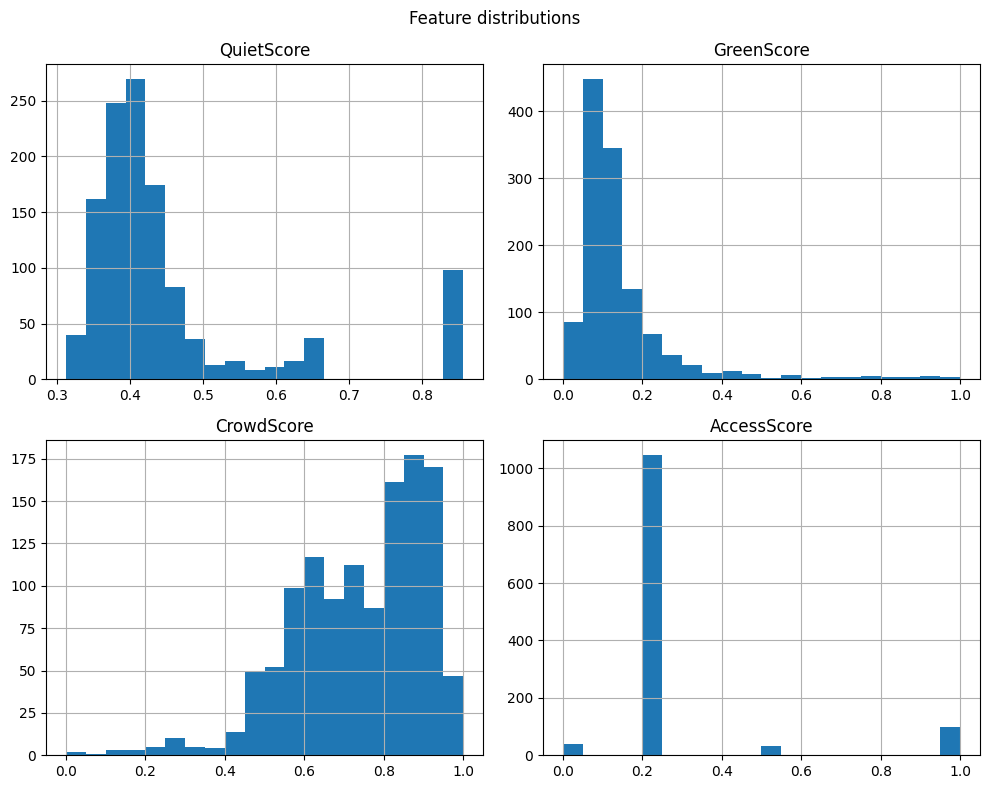

In [12]:
from pathlib import Path

CH4_FIG_DIR = Path("Chapters/ch4_fig")
CH4_FIG_DIR.mkdir(parents=True, exist_ok=True)

ax = features_df[cols].hist(bins=20, figsize=(10, 8))
plt.suptitle("Feature distributions")
plt.tight_layout()

out_png = CH4_FIG_DIR / "feature_distributions_hist.png"
plt.savefig(out_png, dpi=300, bbox_inches="tight")
print("Saved:", out_png)

plt.show()




### B11 Save outputs and provenance

We save both a CSV for modelling and a GeoPackage for mapping. We also write a provenance JSON.


In [13]:
# Save CSV
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
features_df.to_csv(FEATURES_CSV_PATH, index=False)
print("Saved:", FEATURES_CSV_PATH)

# Save GeoPackage with geometry
gdf_out = venues.copy()
gdf_out = gdf_out.join(features_df[cols])

if FEATURES_GPKG_PATH.exists():
    try:
        FEATURES_GPKG_PATH.unlink()
    except Exception:
        pass

gdf_out.to_file(FEATURES_GPKG_PATH, driver="GPKG")
print("Saved:", FEATURES_GPKG_PATH)

# Provenance
prov = {
    "created_at_utc": now_utc_iso(),
    "phase": "B",
    "n_venues": int(len(venues)),
    "buffer_m": float(BUFFER_M),
    "ndvi_window_pixels": int(NDVI_WINDOW_PIXELS),
    "crowd_radius_m": float(CROWD_RADIUS_M),
    "crowd_jobs": int(CROWD_JOBS),
    "poi_cache_build_method": "geofabrik_pbf_osmium_gdal_python_filter",
    "osm_extract": {
        "url": GEOFABRIK_PBF_URL,
        "file": str(OSM_PBF_PATH),
        "size_mb": float(fsize_mb(OSM_PBF_PATH)) if OSM_PBF_PATH.exists() else None
    },
    "inputs": {
        "venues_clean": str(VENUES_CLEAN_PATH),
        "defra_gpkg": str(DEFRA_GPKG_PATH),
        "defra_layer_selected": pick_defra_layer(DEFRA_GPKG_PATH, DEFRA_LAYER_PREFERRED),
        "ndvi_composite": str(NDVI_PATH),
        "poi_cache": str(POI_CACHE_PATH),
        "poi_layer": POI_LAYER_DEFAULT
    },
    "outputs": {
        "venues_features_csv": str(FEATURES_CSV_PATH),
        "venues_features_gpkg": str(FEATURES_GPKG_PATH)
    },
    "hashes": {
        "venues_features_csv_sha256": sha256_file(FEATURES_CSV_PATH),
        "venues_features_gpkg_sha256": sha256_file(FEATURES_GPKG_PATH)
    },
    "runtime_s": float(runtime_s)
}

PHASEB_PROVENANCE_PATH.write_text(json.dumps(prov, indent=2), encoding="utf-8")
print("Saved:", PHASEB_PROVENANCE_PATH)


Saved: /home/sai/test/notebook_test/data/processed/venues_features.csv
Saved: /home/sai/test/notebook_test/data/processed/venues_features.gpkg
Saved: /home/sai/test/notebook_test/data/processed/provenance_phaseB_features.json


# 🎯 Phase-C ComfortScore model and explanation layer

**Objective**
Create an interpretable venue level ComfortScore from the Phase B features, then generate a simple explanation layer.

- ComfortScore represents structural environmental comfort potential derived from physical and infrastructural conditions.
- It does not measure perceived comfort, individual wellbeing, satisfaction, behaviour, or lived experience.
- The score describes environmental opportunity structures rather than human outcomes.

### C0 Setup

In [1]:
# ============================================================
# C0 Setup, paths, and reproducibility
# ============================================================

import json
import time
from pathlib import Path
from datetime import datetime, timezone

import numpy as np
import pandas as pd

try:
    from scipy.stats import spearmanr
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False
    spearmanr = None


def now_utc_iso():
    return datetime.now(timezone.utc).isoformat()


NOTEBOOK_DIR = Path(".").resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent

DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"
RESULTS_DIR = DATA_DIR / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# ------------------------------------------------------------
# Resolve Phase B outputs from provenance if available
# ------------------------------------------------------------
PHASEB_PROVENANCE_PATH = PROCESSED_DIR / "provenance_phaseB_features.json"

# Default guesses (will be overridden by provenance if it exists)
FEATURES_CSV = PROCESSED_DIR / "venues_features.csv"
FEATURES_GPKG_PATH = PROCESSED_DIR / "venues_features.gpkg"

if PHASEB_PROVENANCE_PATH.exists():
    prov_b = json.loads(PHASEB_PROVENANCE_PATH.read_text(encoding="utf-8"))
    outputs_b = prov_b.get("outputs", {})

    csv_path = outputs_b.get("venues_features_csv")
    gpkg_path = outputs_b.get("venues_features_gpkg")

    if csv_path:
        FEATURES_CSV = Path(csv_path)
    if gpkg_path:
        FEATURES_GPKG_PATH = Path(gpkg_path)

# Variables used later in C5
FEATURES_GPKG = str(FEATURES_GPKG_PATH)
FEATURES_GPKG_PATH_PHASEB = FEATURES_GPKG_PATH

# ------------------------------------------------------------
# Outputs
# ------------------------------------------------------------
SCORED_CSV = RESULTS_DIR / "venues_scored.csv"
DIAGNOSTICS_JSON = RESULTS_DIR / "comfort_model_diagnostics.json"
EXPL_COUNTS_CSV = RESULTS_DIR / "explanation_category_counts.csv"
PROV_JSON = RESULTS_DIR / "provenance_phaseC_model.json"

print("PROJECT_ROOT", PROJECT_ROOT)
print("FEATURES_CSV", FEATURES_CSV)
print("FEATURES_GPKG_PATH", FEATURES_GPKG_PATH)
print("RESULTS_DIR", RESULTS_DIR)

if not FEATURES_CSV.exists():
    raise FileNotFoundError(
        f"Missing features file: {FEATURES_CSV}. Run Phase B first."
    )

if not FEATURES_GPKG_PATH.exists():
    raise FileNotFoundError(
        f"Missing Phase B GeoPackage: {FEATURES_GPKG_PATH}. "
        "Run Phase B first so geometry is available for joining scores."
    )


PROJECT_ROOT /home/sai/test/notebook_test
FEATURES_CSV /home/sai/test/notebook_test/data/processed/venues_features.csv
FEATURES_GPKG_PATH /home/sai/test/notebook_test/data/processed/venues_features.gpkg
RESULTS_DIR /home/sai/test/notebook_test/data/results


In [2]:
from pathlib import Path
import json

# Notebook is in notebooks/, project root is one level up
NOTEBOOK_DIR = Path(".").resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent

DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"

# Phase B provenance (created by Phase B at the end)
PHASEB_PROVENANCE_PATH = PROCESSED_DIR / "provenance_phaseB_features.json"

if not PHASEB_PROVENANCE_PATH.exists():
    raise FileNotFoundError(
        f"Phase B provenance not found: {PHASEB_PROVENANCE_PATH}\n"
        "Run Phase B first, or check your folders."
    )

prov_b = json.loads(PHASEB_PROVENANCE_PATH.read_text(encoding="utf-8"))

# Pull the exact paths Phase B wrote
FEATURES_CSV_PATH = Path(prov_b["outputs"]["venues_features_csv"])
FEATURES_GPKG_PATH = Path(prov_b["outputs"]["venues_features_gpkg"])

if not FEATURES_GPKG_PATH.exists():
    raise FileNotFoundError(f"Phase B GeoPackage not found at: {FEATURES_GPKG_PATH}")

print("Resolved Phase B outputs:")
print("FEATURES_CSV_PATH =", FEATURES_CSV_PATH)
print("FEATURES_GPKG_PATH =", FEATURES_GPKG_PATH)


Resolved Phase B outputs:
FEATURES_CSV_PATH = /home/sai/test/notebook_test/data/processed/venues_features.csv
FEATURES_GPKG_PATH = /home/sai/test/notebook_test/data/processed/venues_features.gpkg


### C1 Load features and validate

We load the Phase B feature table and enforce numeric ranges.


In [3]:
# ============================================================
# C1 Load features
# ============================================================

t0 = time.time()
df = pd.read_csv(FEATURES_CSV)

required = ["id", "QuietScore", "GreenScore", "CrowdScore", "AccessScore"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"venues_features.csv missing required columns: {missing}")

df["id"] = df["id"].astype(str)

for c in ["QuietScore", "GreenScore", "CrowdScore", "AccessScore"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# If anything is missing, fill with median of that feature
for c in ["QuietScore", "GreenScore", "CrowdScore", "AccessScore"]:
    if df[c].isna().any():
        med = float(df[c].median(skipna=True))
        df[c] = df[c].fillna(med)

# Clip to 0 to 1 for safety
for c in ["QuietScore", "GreenScore", "CrowdScore", "AccessScore"]:
    df[c] = df[c].clip(0.0, 1.0)

print("Rows", int(len(df)))
print("Feature summary")
display(df[["QuietScore", "GreenScore", "CrowdScore", "AccessScore"]].describe())
print("Load seconds", round(float(time.time() - t0), 3))


Rows 1211
Feature summary


,QuietScore,GreenScore,CrowdScore,AccessScore
count,1211.000000,1211.000000,1211.000000,1211.000000
mean,0.454123,0.146886,0.740688,0.265483
std,0.136713,0.139144,0.165683,0.224892
min,0.311651,0.000000,0.000000,0.000000
25%,0.378925,0.079298,0.621795,0.200000
50%,0.410497,0.109663,0.766026,0.200000
75%,0.451481,0.157040,0.875801,0.200000
max,0.857143,1.000000,1.000000,1.000000


Load seconds 0.17


### C2 ComfortScore definition

- ComfortScore is a weighted sum of the four components.
- All inputs are already scaled to 0 to 1 in Phase B.

Note:
- Component weights are chosen for interpretability rather than optimisation.
- No ground truth exists for urban comfort potential, making data driven tuning inappropriate.
- Equal or near equal weights prioritise transparency and stability over predictive fit.

In [4]:
# ============================================================
# C2 ComfortScore model (FINAL, consistent with Phase B)
# CrowdScore from Phase B is already calmness (higher is better)
# We keep it as is and expose CrowdCalmScore for transparency
# ============================================================

import numpy as np
import pandas as pd

# Required feature columns
FEATURE_COLS = ["QuietScore", "GreenScore", "CrowdScore", "AccessScore"]

# Default weights (must sum to a positive value, do not need to sum to 1)
WEIGHTS = {
    "QuietScore": 0.30,
    "GreenScore": 0.30,
    "CrowdScore": 0.30,   # calmness signal from Phase B
    "AccessScore": 0.10
}

# Defensive checks
missing = [c for c in ["id"] + FEATURE_COLS if c not in df.columns]
if missing:
    raise ValueError(f"Phase C C2 missing required columns in df: {missing}")

# Ensure numeric and clipped to [0, 1]
for c in FEATURE_COLS:
    df[c] = pd.to_numeric(df[c], errors="coerce")
    if df[c].isna().any():
        df[c] = df[c].fillna(float(df[c].median(skipna=True)))
    df[c] = df[c].clip(0.0, 1.0)

# CrowdScore from Phase B is already higher = better (lower crowd pressure)
df["CrowdCalmScore"] = df["CrowdScore"].astype(float)

def calculate_comfort_score(frame: pd.DataFrame, weights: dict) -> pd.Series:
    s = np.zeros(len(frame), dtype=float)
    wsum = 0.0

    for k, w in weights.items():
        if k not in frame.columns and k != "CrowdScore":
            raise ValueError(f"Missing feature column: {k}")

        w = float(w)
        if not np.isfinite(w):
            raise ValueError(f"Non finite weight for {k}: {w}")
        wsum += w

        if k == "CrowdScore":
            x = frame["CrowdCalmScore"].to_numpy(dtype=float)
        else:
            x = frame[k].to_numpy(dtype=float)

        s += w * x

    if not np.isfinite(wsum) or wsum <= 0:
        raise ValueError("Sum of weights must be positive")

    return pd.Series(s / wsum, index=frame.index)

# Compute score and ranks
df["ComfortScore"] = calculate_comfort_score(df, WEIGHTS)
df["ComfortRank"] = df["ComfortScore"].rank(ascending=False, method="average")

# Percentile where 1.0 means best, 0.0 means worst
df["ComfortPercentile"] = df["ComfortScore"].rank(pct=True, ascending=True)

print("ComfortScore summary")
display(df[["ComfortScore", "ComfortRank", "ComfortPercentile"]].describe())

# Sanity checks for crowd direction
print(
    "Spearman ComfortScore vs CrowdScore (should be positive):",
    float(df[["ComfortScore", "CrowdScore"]].corr(method="spearman").iloc[0, 1])
)
print(
    "Spearman ComfortScore vs CrowdCalmScore (should match above):",
    float(df[["ComfortScore", "CrowdCalmScore"]].corr(method="spearman").iloc[0, 1])
)

print("Weights used:", {k: float(v) for k, v in WEIGHTS.items()})


ComfortScore summary


,ComfortScore,ComfortRank,ComfortPercentile
count,1211.000000,1211.000000,1211.000000
mean,0.429058,606.000000,0.500413
std,0.094837,349.729895,0.288794
min,0.140173,1.000000,0.000826
25%,0.362898,303.500000,0.250619
50%,0.420802,606.000000,0.500413
75%,0.471679,908.500000,0.750206
max,0.829824,1211.000000,1.000000


Spearman ComfortScore vs CrowdScore (should be positive): 0.8139974865900758
Spearman ComfortScore vs CrowdCalmScore (should match above): 0.8139974865900758
Weights used: {'QuietScore': 0.3, 'GreenScore': 0.3, 'CrowdScore': 0.3, 'AccessScore': 0.1}


### C3 Explanation layer

We add a simple category label that is easy to report:
- crowd_low means low crowd pressure signal
- accessibility_high means strong accessibility signal
- mixed means multiple strengths
- other means no single strong pattern


In [5]:
# ============================================================
# C3 Explanation layer (FINAL, consistent with Phase B)
# Uses percentile thresholds to get a useful category mix
# CrowdScore is calmness, so crowd_low uses top percentile of CrowdScore
# ============================================================

import pandas as pd

def _rank_pct(s: pd.Series) -> pd.Series:
    return pd.Series(s).rank(method="average", pct=True)

# Strong signal threshold
# 0.80 means top 20 percent
T_STRONG = 0.80

q_pct = _rank_pct(df["QuietScore"])
g_pct = _rank_pct(df["GreenScore"])
a_pct = _rank_pct(df["AccessScore"])

# CrowdScore is calmness (higher better)
c_calm_pct = _rank_pct(df["CrowdScore"])

def explanation_category_percentiles(i: int) -> str:
    strong = []

    if float(q_pct.iloc[i]) >= T_STRONG:
        strong.append("quiet_high")
    if float(g_pct.iloc[i]) >= T_STRONG:
        strong.append("green_high")
    if float(c_calm_pct.iloc[i]) >= T_STRONG:
        strong.append("crowd_low")
    if float(a_pct.iloc[i]) >= T_STRONG:
        strong.append("accessibility_high")

    if len(strong) == 0:
        return "other"
    if len(strong) == 1:
        return strong[0]
    return "mixed"

df["ExplanationCategory"] = [explanation_category_percentiles(i) for i in range(len(df))]

def explanation_text_percentiles(i: int) -> str:
    parts = []

    if float(q_pct.iloc[i]) >= T_STRONG:
        parts.append("quieter streets")
    if float(g_pct.iloc[i]) >= T_STRONG:
        parts.append("greener surroundings")
    if float(c_calm_pct.iloc[i]) >= T_STRONG:
        parts.append("lower activity pressure")
    if float(a_pct.iloc[i]) >= T_STRONG:
        parts.append("better wheelchair support")

    if not parts:
        return "No single dominant signal. ComfortScore reflects the combined balance of components."
    return "Strong signals include " + ", ".join(parts) + "."

df["ExplanationText"] = [explanation_text_percentiles(i) for i in range(len(df))]

counts = df["ExplanationCategory"].value_counts(dropna=False).reset_index()
counts.columns = ["ExplanationCategory", "Count"]
counts["Share"] = counts["Count"] / float(counts["Count"].sum())

print("Explanation category counts")
display(counts)


Explanation category counts


,ExplanationCategory,Count,Share
0,other,623,0.514451
1,mixed,206,0.170107
2,green_high,112,0.092486
3,accessibility_high,92,0.075970
4,crowd_low,91,0.075145
5,quiet_high,87,0.071841


### C4 Robustness checks

We compare the baseline weights against two alternatives:
- equal weights
- standardised features with baseline weights

We report Spearman correlation and top overlap at 10 percent and 5 percent.


In [6]:
# ============================================================
# C4 Robustness metrics (FINAL, consistent with Phase B)
# Uses the same calculate_comfort_score which uses CrowdCalmScore internally
# ============================================================

import numpy as np
import pandas as pd

def top_overlap(a: pd.Series, b: pd.Series, frac: float) -> float:
    n = int(np.ceil(frac * len(a)))
    ia = set(a.sort_values(ascending=False).head(n).index.tolist())
    ib = set(b.sort_values(ascending=False).head(n).index.tolist())
    if n <= 0:
        return float("nan")
    return float(len(ia.intersection(ib)) / n)

def zscore(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce")
    mu = float(s.mean())
    sd = float(s.std(ddof=0))
    if sd <= 0 or (not np.isfinite(sd)):
        return s * 0.0
    return (s - mu) / sd

baseline = df["ComfortScore"].copy()

equal_weights = {k: 1.0 for k in FEATURE_COLS}
score_equal = calculate_comfort_score(df, equal_weights)

df_std = df.copy()
for c in FEATURE_COLS:
    df_std[c] = zscore(df_std[c])

# Keep CrowdCalmScore aligned in the standardised frame too
df_std["CrowdCalmScore"] = df_std["CrowdScore"]

score_std = calculate_comfort_score(df_std, WEIGHTS)

if "SCIPY_OK" in globals() and SCIPY_OK:
    rho_we, _ = spearmanr(baseline.to_numpy(dtype=float), score_equal.to_numpy(dtype=float))
    rho_ws, _ = spearmanr(baseline.to_numpy(dtype=float), score_std.to_numpy(dtype=float))
else:
    rho_we = float(pd.Series(baseline).corr(pd.Series(score_equal), method="spearman"))
    rho_ws = float(pd.Series(baseline).corr(pd.Series(score_std), method="spearman"))

robustness = {
    "spearman_weighted_vs_equal": float(rho_we),
    "top_overlap_10_percent_vs_equal": float(top_overlap(baseline, score_equal, 0.10)),
    "top_overlap_5_percent_vs_equal": float(top_overlap(baseline, score_equal, 0.05)),
    "spearman_weighted_vs_standardised": float(rho_ws),
    "top_overlap_10_percent_vs_standardised": float(top_overlap(baseline, score_std, 0.10)),
    "top_overlap_5_percent_vs_standardised": float(top_overlap(baseline, score_std, 0.05)),
}

print("Robustness metrics")
display(pd.DataFrame([robustness]))


Robustness metrics


,spearman_weighted_vs_equal,top_overlap_10_percent_vs_equal,top_overlap_5_percent_vs_equal,spearman_weighted_vs_standardised,top_overlap_10_percent_vs_standardised,top_overlap_5_percent_vs_standardised
0,0.938908,0.622951,0.590164,0.994963,0.967213,0.967213


### C5 Save scored outputs

We write the scored table and the diagnostic summaries used by later chapters.


In [7]:
# ============================================================
# C5 Write outputs 
# Writes CSV + diagnostics + provenance + scored GeoPackage for mapping
# ============================================================

import json
import time
import geopandas as gpd
from pathlib import Path

t1 = time.time()

# CrowdCalmScore is the crowd signal used in the model
df["CrowdCalmScore"] = df["CrowdScore"]

# Columns to write
out_cols = []
for c in ["id", "name"]:
    if c in df.columns:
        out_cols.append(c)

out_cols += FEATURE_COLS
out_cols += ["CrowdCalmScore"]
out_cols += ["ComfortScore", "ComfortRank", "ComfortPercentile", "ExplanationCategory", "ExplanationText"]

df_out = df[out_cols].copy()

# Ensure stable join key type for all outputs
if "id" in df_out.columns:
    df_out["id"] = df_out["id"].astype(str)

# Write scored CSV
df_out.to_csv(SCORED_CSV, index=False)
print("Saved", SCORED_CSV)

# Write explanation counts CSV
counts.to_csv(EXPL_COUNTS_CSV, index=False)
print("Saved", EXPL_COUNTS_CSV)

# ------------------------------------------------------------
# Save scored GeoPackage by joining scores back to Phase B geometry
# ------------------------------------------------------------
SCORED_GPKG = RESULTS_DIR / "venues_scored.gpkg"

# Resolve Phase B GeoPackage path robustly
if "FEATURES_GPKG" in globals():
    phaseb_gpkg_path = FEATURES_GPKG
elif "FEATURES_GPKG_PATH" in globals():
    phaseb_gpkg_path = FEATURES_GPKG_PATH
elif "FEATURES_GPKG_PATH_PHASEB" in globals():
    phaseb_gpkg_path = FEATURES_GPKG_PATH_PHASEB
else:
    raise NameError("Missing Phase B GeoPackage path. Expected FEATURES_GPKG or FEATURES_GPKG_PATH.")

phaseb_gpkg_path = Path(phaseb_gpkg_path)
if not phaseb_gpkg_path.exists():
    raise FileNotFoundError(f"Phase B GeoPackage not found at: {phaseb_gpkg_path}")

# Read Phase B geometry
gdf_feat = gpd.read_file(phaseb_gpkg_path)
if "id" not in gdf_feat.columns:
    raise KeyError("Phase B GeoPackage must contain 'id' column to join scores back to geometry.")

# Ensure join key type matches
gdf_feat["id"] = gdf_feat["id"].astype(str)

# Join scores onto geometry
gdf_scored = gdf_feat.merge(df_out, on="id", how="left")

# Sanity check: ensure merge succeeded for all rows
if "ComfortScore" not in gdf_scored.columns:
    raise KeyError("ComfortScore missing after merge. Check df_out columns.")
n_missing = int(gdf_scored["ComfortScore"].isna().sum())
if n_missing > 0:
    raise ValueError(
        f"Join produced {n_missing} missing ComfortScore values. "
        "This indicates id mismatch between Phase B and Phase C."
    )

# Write scored GeoPackage
gdf_scored.to_file(SCORED_GPKG, layer="venues_scored", driver="GPKG")
print("Saved", SCORED_GPKG)

# ------------------------------------------------------------
# Diagnostics
# ------------------------------------------------------------
diagnostics = {
    "created_at_utc": now_utc_iso(),
    "weights": {k: float(v) for k, v in WEIGHTS.items()},
    "feature_columns": FEATURE_COLS,
    "crowd_feature_used_in_model": "CrowdCalmScore equals CrowdScore from Phase B",
    "n_venues": int(len(df)),
    "robustness": robustness,
    "component_spearman_with_comfort": {
        "QuietScore": float(df[["ComfortScore", "QuietScore"]].corr(method="spearman").iloc[0, 1]),
        "GreenScore": float(df[["ComfortScore", "GreenScore"]].corr(method="spearman").iloc[0, 1]),
        "CrowdScore": float(df[["ComfortScore", "CrowdScore"]].corr(method="spearman").iloc[0, 1]),
        "AccessScore": float(df[["ComfortScore", "AccessScore"]].corr(method="spearman").iloc[0, 1]),
    },
    "explanations": {
        "strong_threshold_percentile": float(T_STRONG),
        "notes": "crowd_low uses top percentile of CrowdScore because CrowdScore is calmness in Phase B."
    },
}

DIAGNOSTICS_JSON.write_text(json.dumps(diagnostics, indent=2), encoding="utf-8")
print("Saved", DIAGNOSTICS_JSON)

# ------------------------------------------------------------
# Provenance
# ------------------------------------------------------------
prov = {
    "created_at_utc": now_utc_iso(),
    "phase": "C",
    "inputs": {
        "venues_features_csv": str(FEATURES_CSV),
        "venues_features_gpkg": str(phaseb_gpkg_path),
    },
    "outputs": {
        "venues_scored_csv": str(SCORED_CSV),
        "venues_scored_gpkg": str(SCORED_GPKG),
        "comfort_model_diagnostics_json": str(DIAGNOSTICS_JSON),
        "explanation_category_counts_csv": str(EXPL_COUNTS_CSV),
        "provenance_phaseC_model_json": str(PROV_JSON),
    },
    "runtime_s": float(time.time() - t1),
}

PROV_JSON.write_text(json.dumps(prov, indent=2), encoding="utf-8")
print("Saved", PROV_JSON)


Saved /home/sai/test/notebook_test/data/results/venues_scored.csv
Saved /home/sai/test/notebook_test/data/results/explanation_category_counts.csv
Saved /home/sai/test/notebook_test/data/results/venues_scored.gpkg
Saved /home/sai/test/notebook_test/data/results/comfort_model_diagnostics.json
Saved /home/sai/test/notebook_test/data/results/provenance_phaseC_model.json


### C6 Quick inspection

We print a compact summary so you can sanity check before moving on.


Rows 1211
ComfortScore summary


,ComfortScore
count,1211.000000
mean,0.429058
std,0.094837
min,0.140173
25%,0.362898
50%,0.420802
75%,0.471679
max,0.829824


Top venues


,id,name,QuietScore,GreenScore,CrowdScore,AccessScore,CrowdCalmScore,ComfortScore,ComfortRank,ComfortPercentile,ExplanationCategory,ExplanationText
19,336347045,Wagon Cafe,0.857143,0.915988,0.926282,0.2,0.926282,0.829824,1.0,1.000000,mixed,"Strong signals include quieter streets, greene..."
1113,859483943,Village Cafe,0.857143,0.883490,0.926282,0.2,0.926282,0.820075,2.0,0.999174,mixed,"Strong signals include quieter streets, greene..."
624,27426199,Cecil Sharp House,0.458655,0.877299,0.918269,1.0,0.918269,0.776267,3.0,0.998348,mixed,"Strong signals include greener surroundings, l..."
1164,1106478045,sis&sibs,0.857143,0.667296,0.958333,0.2,0.958333,0.764832,4.0,0.997523,mixed,"Strong signals include quieter streets, greene..."
1154,1051336498,Alexandra Resource Centre,0.857143,0.655676,0.913462,0.2,0.913462,0.747884,5.0,0.996697,mixed,"Strong signals include quieter streets, greene..."
116,831257535,Royal Cafe & Sandwhich bar,0.857143,0.656238,0.883013,0.2,0.883013,0.738918,6.0,0.995871,mixed,"Strong signals include quieter streets, greene..."
612,23164245,Goldington Crescent Gardens,0.477827,0.907737,0.887821,0.2,0.887821,0.702015,7.0,0.995045,mixed,"Strong signals include quieter streets, greene..."
243,3855655369,Tobia Cafe,0.460958,0.923882,0.884615,0.2,0.884615,0.700837,8.0,0.994220,green_high,Strong signals include greener surroundings.
855,179438230,Aubert Court Community Centre,0.606215,0.672404,0.940705,0.2,0.940705,0.685797,9.0,0.993394,mixed,"Strong signals include quieter streets, greene..."
758,85719814,Queen's Crescent Library,0.857143,0.177412,0.913462,1.0,0.913462,0.684405,10.0,0.992568,mixed,"Strong signals include quieter streets, lower ..."


Bottom venues


,id,name,QuietScore,GreenScore,CrowdScore,AccessScore,CrowdCalmScore,ComfortScore,ComfortRank,ComfortPercentile,ExplanationCategory,ExplanationText
229,3687948888,Timber Yard,0.395401,0.071841,0.000000,0.0,0.000000,0.140173,1211.0,0.000826,other,No single dominant signal. ComfortScore reflec...
508,11964292769,WatchHouse,0.395435,0.071841,0.000000,0.2,0.000000,0.160183,1210.0,0.001652,other,No single dominant signal. ComfortScore reflec...
87,603113483,La Bottega,0.391634,0.064399,0.097756,0.2,0.097756,0.186137,1209.0,0.002477,other,No single dominant signal. ComfortScore reflec...
64,401529157,Snack Bar & Café,0.385626,0.107629,0.134615,0.0,0.134615,0.188361,1208.0,0.003303,other,No single dominant signal. ComfortScore reflec...
314,5169583425,Covent Garden Community Centre,0.371255,0.053658,0.144231,0.2,0.144231,0.190743,1207.0,0.004129,other,No single dominant signal. ComfortScore reflec...
693,42018705,Phoenix Garden,0.371446,0.059160,0.158654,0.2,0.158654,0.196778,1206.0,0.004955,other,No single dominant signal. ComfortScore reflec...
9,311877305,Costa,0.378242,0.053305,0.187500,0.2,0.187500,0.205714,1205.0,0.005780,other,No single dominant signal. ComfortScore reflec...
824,153261285,Fernandez & Wells,0.368981,0.074231,0.197115,0.2,0.197115,0.212098,1204.0,0.006606,other,No single dominant signal. ComfortScore reflec...
499,11607899738,NOW Trending,0.365797,0.076408,0.206731,0.2,0.206731,0.214681,1203.0,0.007432,other,No single dominant signal. ComfortScore reflec...
498,11607899737,The NOW Building,0.368098,0.080183,0.221154,0.2,0.221154,0.220830,1202.0,0.008258,other,No single dominant signal. ComfortScore reflec...


Robustness


,spearman_weighted_vs_equal,top_overlap_10_percent_vs_equal,top_overlap_5_percent_vs_equal,spearman_weighted_vs_standardised,top_overlap_10_percent_vs_standardised,top_overlap_5_percent_vs_standardised
0,0.938908,0.622951,0.590164,0.994963,0.967213,0.967213


Saved: Chapters/ch4_fig/feature_distributions_hist.png


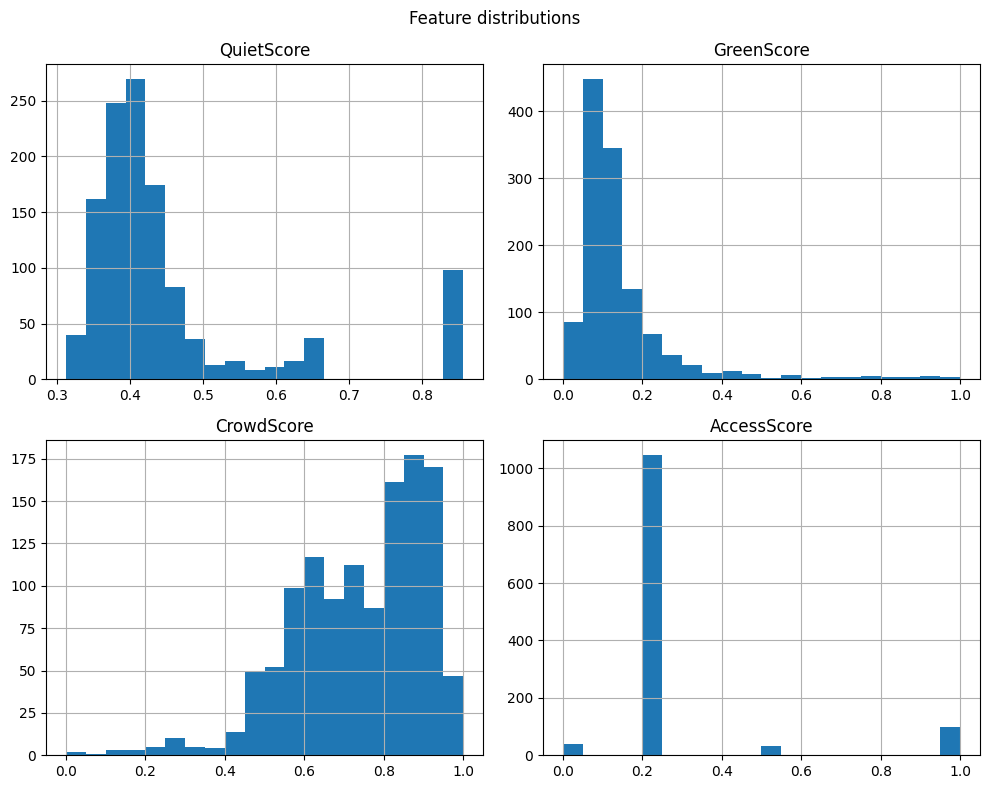

Saved: Chapters/ch4_fig/correlation_spearman_matrix.png


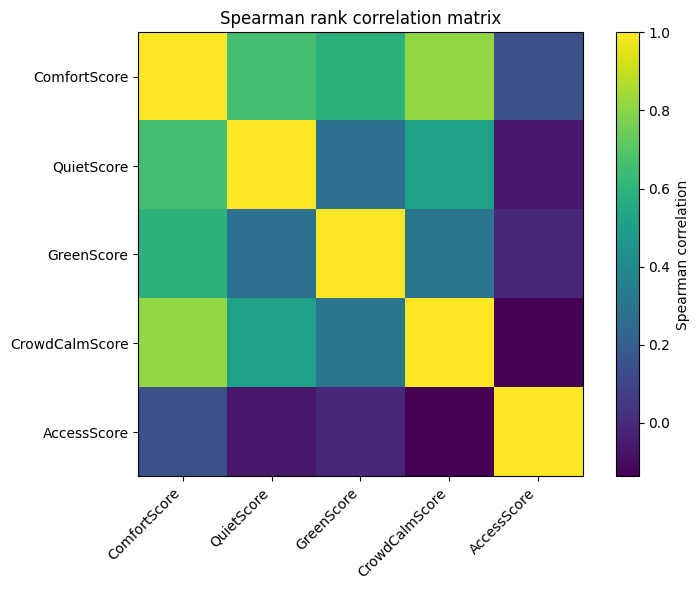

Saved: Chapters/ch4_fig/robustness_metrics_bar.png


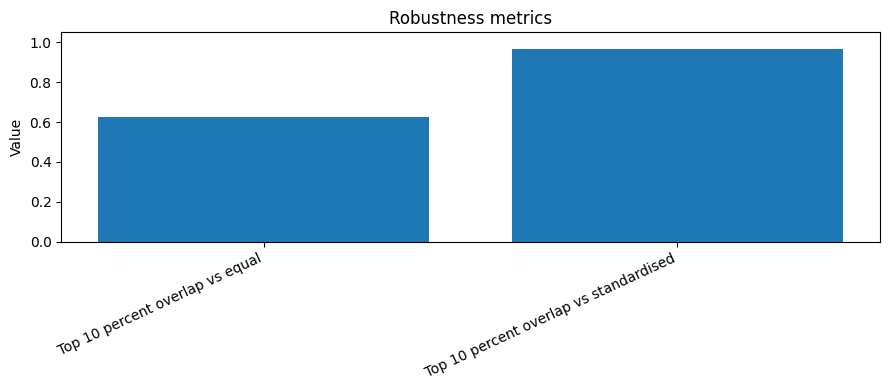

Saved: Chapters/ch4_fig/explanation_category_bar.png


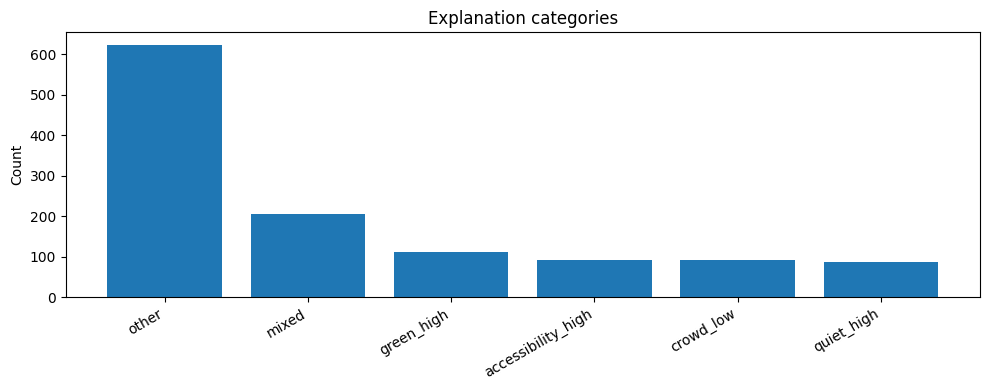

Saved: Chapters/ch4_fig/comfortscore_spatial_scatter.png


<Figure size 700x700 with 0 Axes>

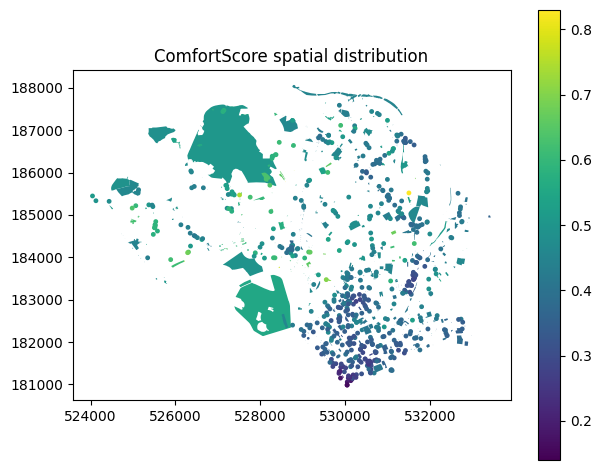

Saved: Chapters/ch4_fig/comfortscore_top_bottom_10pct.png


<Figure size 700x700 with 0 Axes>

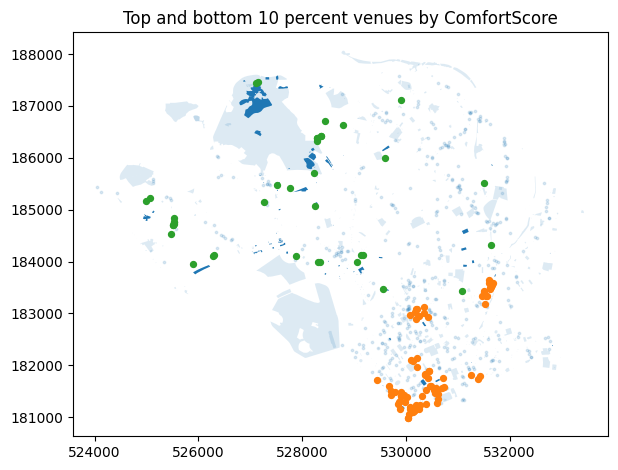

In [8]:
# ============================================================
# C6 Quick summary + export Chapter 4 figures (reproducible)
# ============================================================

import json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path

# -----------------------------
# Quick summary (keep this)
# -----------------------------
print("Rows", int(len(df_out)))
print("ComfortScore summary")
display(df_out[["ComfortScore"]].describe())

print("Top venues")
display(df_out.sort_values("ComfortScore", ascending=False).head(10))

print("Bottom venues")
display(df_out.sort_values("ComfortScore", ascending=True).head(10))

print("Robustness")
display(pd.DataFrame([robustness]))

# -----------------------------
# Figure export directory
# -----------------------------
CH4_FIG_DIR = Path("Chapters/ch4_fig")
CH4_FIG_DIR.mkdir(parents=True, exist_ok=True)

# Load from disk so it is reproducible
df_scored = pd.read_csv(SCORED_CSV)
if "id" in df_scored.columns:
    df_scored["id"] = df_scored["id"].astype(str)

SCORED_GPKG = RESULTS_DIR / "venues_scored.gpkg"
gdf_scored = None
if SCORED_GPKG.exists():
    gdf_scored = gpd.read_file(SCORED_GPKG, layer="venues_scored")
    if "id" in gdf_scored.columns:
        gdf_scored["id"] = gdf_scored["id"].astype(str)
else:
    print("Note: venues_scored.gpkg not found, spatial plots will be skipped:", SCORED_GPKG)

# 1 Feature distributions histogram
cols_hist = [c for c in ["QuietScore", "GreenScore", "CrowdScore", "AccessScore"] if c in df_scored.columns]
if len(cols_hist) > 0:
    df_scored[cols_hist].hist(bins=20, figsize=(10, 8))
    plt.suptitle("Feature distributions")
    plt.tight_layout()
    out_png = CH4_FIG_DIR / "feature_distributions_hist.png"
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    print("Saved:", out_png)
    plt.show()
else:
    print("Skipping feature distributions: expected columns not found")

# 2 Spearman correlation matrix plot
cols_corr = ["ComfortScore", "QuietScore", "GreenScore", "CrowdCalmScore", "AccessScore"]
use_cols = [c for c in cols_corr if c in df_scored.columns]
if len(use_cols) >= 2:
    corr = df_scored[use_cols].corr(method="spearman")

    plt.figure(figsize=(8, 6))
    plt.imshow(corr.values)
    plt.xticks(range(len(use_cols)), use_cols, rotation=45, ha="right")
    plt.yticks(range(len(use_cols)), use_cols)
    plt.colorbar(label="Spearman correlation")
    plt.title("Spearman rank correlation matrix")
    plt.tight_layout()

    out_png = CH4_FIG_DIR / "correlation_spearman_matrix.png"
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    print("Saved:", out_png)
    plt.show()
else:
    print("Skipping Spearman matrix: not enough columns found")

# 3 Robustness metrics bar plot from diagnostics JSON
diag_path = DIAGNOSTICS_JSON if "DIAGNOSTICS_JSON" in globals() else (RESULTS_DIR / "comfort_model_diagnostics.json")
diag_path = Path(diag_path)

if diag_path.exists():
    diagnostics = json.loads(diag_path.read_text(encoding="utf-8"))
    rb = diagnostics.get("robustness", {})

    pairs = [
        ("Spearman baseline vs equal", rb.get("spearman_baseline_vs_equal")),
        ("Spearman baseline vs standardised", rb.get("spearman_baseline_vs_standardised")),
        ("Top 10 percent overlap vs equal", rb.get("top_overlap_10_percent_vs_equal")),
        ("Top 10 percent overlap vs standardised", rb.get("top_overlap_10_percent_vs_standardised")),
    ]

    labels = [p[0] for p in pairs if p[1] is not None]
    values = [p[1] for p in pairs if p[1] is not None]

    if len(values) == 0:
        print("Skipping robustness plot: robustness keys not found inside diagnostics['robustness']")
    else:
        plt.figure(figsize=(9, 4))
        plt.bar(labels, values)
        plt.xticks(rotation=25, ha="right")
        plt.ylim(0, 1.05)
        plt.ylabel("Value")
        plt.title("Robustness metrics")

        out_png = CH4_FIG_DIR / "robustness_metrics_bar.png"
        plt.tight_layout()
        plt.savefig(out_png, dpi=300, bbox_inches="tight")
        print("Saved:", out_png)
        plt.show()
else:
    print("Skipping robustness plot: diagnostics JSON not found at", diag_path)

# 4 Explanation category bar plot
if "ExplanationCategory" in df_scored.columns:
    expl = df_scored["ExplanationCategory"].fillna("missing").value_counts().sort_values(ascending=False)
    plt.figure(figsize=(10, 4))
    plt.bar(expl.index.astype(str), expl.values)
    plt.xticks(rotation=30, ha="right")
    plt.ylabel("Count")
    plt.title("Explanation categories")

    out_png = CH4_FIG_DIR / "explanation_category_bar.png"
    plt.tight_layout()
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    print("Saved:", out_png)
    plt.show()
else:
    print("Skipping explanation plot: ExplanationCategory not found")

# 5 Spatial scatter coloured by ComfortScore
if gdf_scored is not None and "ComfortScore" in gdf_scored.columns:
    plt.figure(figsize=(7, 7))
    gdf_scored.plot(column="ComfortScore", legend=True, markersize=6)
    plt.title("ComfortScore spatial distribution")

    out_png = CH4_FIG_DIR / "comfortscore_spatial_scatter.png"
    plt.tight_layout()
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    print("Saved:", out_png)
    plt.show()
else:
    print("Skipping spatial scatter: geometry or ComfortScore missing")

# 6 Top and bottom 10 percent map
if gdf_scored is not None and "ComfortPercentile" in gdf_scored.columns:
    top = gdf_scored[gdf_scored["ComfortPercentile"] >= 0.90].copy()
    bot = gdf_scored[gdf_scored["ComfortPercentile"] <= 0.10].copy()

    plt.figure(figsize=(7, 7))
    base = gdf_scored.plot(markersize=3, alpha=0.15)
    if len(bot) > 0:
        bot.plot(ax=base, markersize=18)
    if len(top) > 0:
        top.plot(ax=base, markersize=18)
    plt.title("Top and bottom 10 percent venues by ComfortScore")

    out_png = CH4_FIG_DIR / "comfortscore_top_bottom_10pct.png"
    plt.tight_layout()
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    print("Saved:", out_png)
    plt.show()
else:
    print("Skipping top bottom plot: geometry or ComfortPercentile missing")


# 🎯 Phase-D External data downloads 

This notebook prepares the external datasets needed for Phase D validation.

D**esign goals**
- Provide short manual instructions where licence acceptance is required.
- Automate downloads where a stable direct link exists.
- Standardise folder names and file paths so later notebooks can run without guesswork.
- Cache first behaviour, reruns should not re download if outputs exist.

**Datasets covered**
1. OS Open Greenspace polygons (manual download, then code handles extraction and normalisation)
2. LAEI 2019 Focus Areas (automated download and extraction)
3. PTAL Grid Values (automated download and extraction)
4. OSM major roads cache for Camden and Islington (generated from your existing OSM PBF)

# ❗Note: D1 is manual download step❗

### D0 Setup

In [2]:

# ============================================================
# D0 Setup and paths
# ============================================================

import os
import re
import json
import time
import shutil
import zipfile
import hashlib
from pathlib import Path
from datetime import datetime, timezone

import requests

def now_utc_iso():
    return datetime.now(timezone.utc).isoformat()

def sha256_file(path: Path) -> str:
    h = hashlib.sha256()
    with Path(path).open("rb") as f:
        for chunk in iter(lambda: f.read(1024 * 1024), b""):
            h.update(chunk)
    return h.hexdigest()

NOTEBOOK_DIR = Path(".").resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent

DATA_DIR = PROJECT_ROOT / "data"
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"
RESULTS_DIR = DATA_DIR / "results"

RAW_DIR.mkdir(parents=True, exist_ok=True)

# Core pipeline inputs (these should already exist from Phase A to C)
VENUES_CLEAN = PROCESSED_DIR / "venues_clean.geojson"
OSM_PBF = RAW_DIR / "osm" / "greater-london-260110.osm.pbf"

# External datasets for Phase D
GREENS_DIR = RAW_DIR / "os_open_greenspace"
LAEI_DIR = RAW_DIR / "laei_focus_areas"
PTAL_DIR = RAW_DIR / "ptal"
MAJOR_ROADS_DIR = RAW_DIR / "osm_major_roads"

GREENS_DIR.mkdir(parents=True, exist_ok=True)
LAEI_DIR.mkdir(parents=True, exist_ok=True)
PTAL_DIR.mkdir(parents=True, exist_ok=True)
MAJOR_ROADS_DIR.mkdir(parents=True, exist_ok=True)

# Outputs written by this notebook
GREENS_EXTRACT_DIR = GREENS_DIR / "opgrsp_essh_tq_extracted"
LAEI_EXTRACT_DIR = LAEI_DIR / "laei_gis"
PTAL_EXTRACT_DIR = PTAL_DIR / "ptal_grid_values"
MAJOR_ROADS_GPKG = MAJOR_ROADS_DIR / "major_roads_camden_islington.gpkg"

# Provenance logs
PROV_DIR = RAW_DIR / "provenance_phaseD_downloads"
PROV_DIR.mkdir(parents=True, exist_ok=True)

PROV_GREENS = PROV_DIR / "provenance_os_open_greenspace.json"
PROV_LAEI = PROV_DIR / "provenance_laei_focus_areas.json"
PROV_PTAL = PROV_DIR / "provenance_ptal.json"
PROV_ROADS = PROV_DIR / "provenance_osm_major_roads.json"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("RAW_DIR:", RAW_DIR)
print("VENUES_CLEAN:", VENUES_CLEAN)
print("OSM_PBF:", OSM_PBF)
print("GREENS_DIR:", GREENS_DIR)
print("LAEI_DIR:", LAEI_DIR)
print("PTAL_DIR:", PTAL_DIR)
print("MAJOR_ROADS_DIR:", MAJOR_ROADS_DIR)


PROJECT_ROOT: /home/sai/test/notebook_test
RAW_DIR: /home/sai/test/notebook_test/data/raw
VENUES_CLEAN: /home/sai/test/notebook_test/data/processed/venues_clean.geojson
OSM_PBF: /home/sai/test/notebook_test/data/raw/osm/greater-london-260110.osm.pbf
GREENS_DIR: /home/sai/test/notebook_test/data/raw/os_open_greenspace
LAEI_DIR: /home/sai/test/notebook_test/data/raw/laei_focus_areas
PTAL_DIR: /home/sai/test/notebook_test/data/raw/ptal
MAJOR_ROADS_DIR: /home/sai/test/notebook_test/data/raw/osm_major_roads


### D1 OS Open Greenspace polygons (Manual download)
Used as an independent, authoritative greenspace layer for external validation of GreenScore at matched spatial support. Manual download is required due to licence acceptance and the absence of a stable public API.

**Steps to download:**
- Open the official OS Data Hub download page: https://osdatahub.os.uk/data/downloads/open/OpenGreenspace
- In Specify an area: Select TQ (100 km tile covering Greater London)
- In Data format : Choose ESRI Shapefile
- Click Download and move the zip file at: `./data/raw/os_open_greenspace`
- Note: do not unzip, just move the zip file to `./data/raw/os_open_greenspace`


Expected result after running the next cell
- A clean extracted folder: `data/raw/os_open_greenspace/opgrsp_essh_tq_extracted/`
- A detected GreenspaceSite shapefile path printed in the output


In [4]:
# ============================================================
# D1.1 Data preparation: OS Open Greenspace (manual download)
# Normalise to a stable folder name and stable shapefile paths
# ============================================================

GREENS_DIR.mkdir(parents=True, exist_ok=True)

# The downloaded zip name can vary. Prefer a stable name if you use one.
PREFERRED_ZIP = GREENS_DIR / "opgrsp_essh_tq.zip"

def pick_greens_zip() -> Path:
    if PREFERRED_ZIP.exists() and PREFERRED_ZIP.stat().st_size > 0:
        return PREFERRED_ZIP
    zips = sorted([p for p in GREENS_DIR.glob("*.zip") if p.stat().st_size > 0])
    if not zips:
        raise FileNotFoundError(
            "Missing OS Open Greenspace zip.\n"
            "Download from OS Data Hub (tile TQ, ESRI Shapefile) and place the zip into:\n"
            f"  {GREENS_DIR}\n"
            "Optional: rename it to opgrsp_essh_tq.zip for clarity."
        )
    return zips[0]

ZIP_PATH = pick_greens_zip()

# If final folder missing, create it from extraction
if not GREENS_EXTRACT_DIR.exists():
    tmp = GREENS_DIR / "_tmp_extract"
    if tmp.exists():
        shutil.rmtree(tmp)
    tmp.mkdir(parents=True, exist_ok=True)

    print("Extracting:", ZIP_PATH.name)
    with zipfile.ZipFile(ZIP_PATH, "r") as z:
        z.extractall(tmp)

    # If there is a single top folder, move it. Otherwise keep the tmp content.
    top_dirs = [p for p in tmp.iterdir() if p.is_dir()]
    if len(top_dirs) == 1:
        shutil.move(str(top_dirs[0]), str(GREENS_EXTRACT_DIR))
        shutil.rmtree(tmp)
    else:
        shutil.move(str(tmp), str(GREENS_EXTRACT_DIR))

else:
    print("Greenspace extract folder already exists:", GREENS_EXTRACT_DIR)

# Validate we can locate the GreenspaceSite shapefile
expected = GREENS_EXTRACT_DIR / "data" / "TQ_GreenspaceSite.shp"
if expected.exists():
    SITE_SHP = expected
else:
    candidates = list(GREENS_EXTRACT_DIR.rglob("*GreenspaceSite*.shp"))
    if not candidates:
        raise FileNotFoundError(
            "Could not find GreenspaceSite shapefile after extraction.\n"
            f"Searched under: {GREENS_EXTRACT_DIR}"
        )
    SITE_SHP = candidates[0]

prov = {
    "created_at_utc": now_utc_iso(),
    "dataset": "OS Open Greenspace (tile TQ, ESRI Shapefile)",
    "method": "manual_download_then_extract",
    "zip_used": str(ZIP_PATH),
    "zip_sha256": sha256_file(ZIP_PATH),
    "extract_dir": str(GREENS_EXTRACT_DIR),
    "greenspace_site_shp": str(SITE_SHP)
}
PROV_GREENS.write_text(json.dumps(prov, indent=2), encoding="utf-8")

print("OS Open Greenspace ready")
print("Extracted folder:", GREENS_EXTRACT_DIR)
print("GreenspaceSite shapefile:", SITE_SHP)
print("Provenance:", PROV_GREENS)


Greenspace extract folder already exists: /home/sai/test/notebook_test/data/raw/os_open_greenspace/opgrsp_essh_tq_extracted
OS Open Greenspace ready
Extracted folder: /home/sai/test/notebook_test/data/raw/os_open_greenspace/opgrsp_essh_tq_extracted
GreenspaceSite shapefile: /home/sai/test/notebook_test/data/raw/os_open_greenspace/opgrsp_essh_tq_extracted/data/TQ_GreenspaceSite.shp
Provenance: /home/sai/test/notebook_test/data/raw/provenance_phaseD_downloads/provenance_os_open_greenspace.json


### D2 LAEI 2019 Focus Areas (Automation download)
Independent policy layer used for convergent validation. ComfortScore is expected to be lower inside LAEI focus areas.

**Steps to download:**
- Open the official website: https://data.london.gov.uk/dataset/london-atmospheric-emissions-inventory-laei-2019-air-quality-foc-2zj76#
- Look for GIS file (2. GIS files  (40.61 kB))
- Direct download link : https://data.london.gov.uk/download/2zj76/36d88eac-849b-400a-ae44-2dc93bdb966d/2.%20GIS%20files.zip


In [5]:
# ============================================================
# D2.1 Download and extract: LAEI 2019 Focus Areas
# Robust to zip structure changes, extracts into a stable folder
# ============================================================

LAEI_ZIP = LAEI_DIR / "laei_2019_focus_areas.zip"

LAEI_URL = (
    "https://data.london.gov.uk/download/2zj76/"
    "36d88eac-849b-400a-ae44-2dc93bdb966d/"
    "2.%20GIS%20files.zip"
)

def download_file(url: str, out_path: Path, timeout_s: int = 90):
    out_path = Path(out_path)
    if out_path.exists() and out_path.stat().st_size > 0:
        return "already_present"
    print("Downloading:", url)
    with requests.get(url, stream=True, timeout=timeout_s) as r:
        r.raise_for_status()
        with out_path.open("wb") as f:
            for chunk in r.iter_content(chunk_size=1024 * 256):
                if chunk:
                    f.write(chunk)
    if out_path.stat().st_size == 0:
        raise RuntimeError("Downloaded file is empty")
    return "downloaded"

status = download_file(LAEI_URL, LAEI_ZIP)
print("LAEI zip status:", status, "|", LAEI_ZIP)

if not LAEI_EXTRACT_DIR.exists():
    LAEI_EXTRACT_DIR.mkdir(parents=True, exist_ok=True)
    print("Extracting into:", LAEI_EXTRACT_DIR)
    with zipfile.ZipFile(LAEI_ZIP, "r") as z:
        z.extractall(LAEI_EXTRACT_DIR)
else:
    print("LAEI extract folder already exists:", LAEI_EXTRACT_DIR)

# Find a shapefile to confirm content
shps = sorted(LAEI_EXTRACT_DIR.rglob("*.shp"))
if not shps:
    raise FileNotFoundError("LAEI shapefile not found after extraction")

# Prefer a file that looks like Focus Areas if available
preferred = None
for p in shps:
    if "focus" in p.name.lower() and "area" in p.name.lower():
        preferred = p
        break
LAEI_SHP = preferred if preferred else shps[0]

prov = {
    "created_at_utc": now_utc_iso(),
    "dataset": "LAEI 2019 Air Quality Focus Areas",
    "method": "direct_download_then_extract",
    "dataset_page": "https://data.london.gov.uk/dataset/london-atmospheric-emissions-inventory-laei-2019-air-quality-foc-2zj76#",
    "direct_url": LAEI_URL,
    "zip_path": str(LAEI_ZIP),
    "zip_sha256": sha256_file(LAEI_ZIP),
    "extract_dir": str(LAEI_EXTRACT_DIR),
    "shapefile_selected": str(LAEI_SHP)
}
PROV_LAEI.write_text(json.dumps(prov, indent=2), encoding="utf-8")

print("LAEI Focus Areas ready")
print("Extracted folder:", LAEI_EXTRACT_DIR)
print("Selected shapefile:", LAEI_SHP)
print("Provenance:", PROV_LAEI)


Downloading: https://data.london.gov.uk/download/2zj76/36d88eac-849b-400a-ae44-2dc93bdb966d/2.%20GIS%20files.zip
LAEI zip status: downloaded | /home/sai/test/notebook_test/data/raw/laei_focus_areas/laei_2019_focus_areas.zip
Extracting into: /home/sai/test/notebook_test/data/raw/laei_focus_areas/laei_gis
LAEI Focus Areas ready
Extracted folder: /home/sai/test/notebook_test/data/raw/laei_focus_areas/laei_gis
Selected shapefile: /home/sai/test/notebook_test/data/raw/laei_focus_areas/laei_gis/2. GIS files/LAEI2019_FocusAreas.shp
Provenance: /home/sai/test/notebook_test/data/raw/provenance_phaseD_downloads/provenance_laei_focus_areas.json


### D3 PTAL Public Transport Accessibility Levels (Automation download)

A diagnostic accessibility proxy.
Used cautiously to illustrate construct mismatch with the wheelchair tagging.

 - Dataset page : https://data.london.gov.uk/dataset/public-transport-accessibility-levels-24rz6/
 - Download : PTAL Grid Values.zip  (8.59 MB)
 - Extract at : data/raw/ptal/
 - Direct download link : https://data.london.gov.uk/download/24rz6/514d2847-94a8-4b9d-8a70-fdded01719a0/2015%20%20PTALs%20Grid%20Values.zip



In [6]:
# ============================================================
# D3.1 Download and extract: PTAL Grid Values
# ============================================================

PTAL_ZIP = PTAL_DIR / "ptal_grid_values.zip"

PTAL_URL = (
    "https://data.london.gov.uk/download/24rz6/"
    "514d2847-94a8-4b9d-8a70-fdded01719a0/"
    "2015%20%20PTALs%20Grid%20Values.zip"
)

status = download_file(PTAL_URL, PTAL_ZIP)
print("PTAL zip status:", status, "|", PTAL_ZIP)

if not PTAL_EXTRACT_DIR.exists():
    PTAL_EXTRACT_DIR.mkdir(parents=True, exist_ok=True)
    print("Extracting into:", PTAL_EXTRACT_DIR)
    with zipfile.ZipFile(PTAL_ZIP, "r") as z:
        z.extractall(PTAL_EXTRACT_DIR)
else:
    print("PTAL extract folder already exists:", PTAL_EXTRACT_DIR)

# Confirm expected MapInfo TAB exists somewhere
tabs = sorted(PTAL_EXTRACT_DIR.rglob("*.TAB")) + sorted(PTAL_EXTRACT_DIR.rglob("*.tab"))
PTAL_TAB = tabs[0] if tabs else None

prov = {
    "created_at_utc": now_utc_iso(),
    "dataset": "PTAL Grid Values",
    "method": "direct_download_then_extract",
    "dataset_page": "https://data.london.gov.uk/dataset/public-transport-accessibility-levels-24rz6/",
    "direct_url": PTAL_URL,
    "zip_path": str(PTAL_ZIP),
    "zip_sha256": sha256_file(PTAL_ZIP),
    "extract_dir": str(PTAL_EXTRACT_DIR),
    "tab_file_detected": str(PTAL_TAB) if PTAL_TAB else None
}
PROV_PTAL.write_text(json.dumps(prov, indent=2), encoding="utf-8")

print("PTAL ready")
print("Extracted folder:", PTAL_EXTRACT_DIR)
print("Detected TAB:", PTAL_TAB)
print("Provenance:", PROV_PTAL)


Downloading: https://data.london.gov.uk/download/24rz6/514d2847-94a8-4b9d-8a70-fdded01719a0/2015%20%20PTALs%20Grid%20Values.zip
PTAL zip status: downloaded | /home/sai/test/notebook_test/data/raw/ptal/ptal_grid_values.zip
Extracting into: /home/sai/test/notebook_test/data/raw/ptal/ptal_grid_values
PTAL ready
Extracted folder: /home/sai/test/notebook_test/data/raw/ptal/ptal_grid_values
Detected TAB: /home/sai/test/notebook_test/data/raw/ptal/ptal_grid_values/2015  PTALs Contours 280515.TAB
Provenance: /home/sai/test/notebook_test/data/raw/provenance_phaseD_downloads/provenance_ptal.json


### D4 OSM major roads cache for Camden and Islington

This is generated from your existing Geofabrik Greater London PBF.
Uses the venue footprint to define a buffered AOI, then extracts only major highway classes.

Output: `data/raw/osm_major_roads/major_roads_camden_islington.gpkg`


In [7]:
# ============================================================
# D4.1 Build OSM major roads cache as a GeoPackage (UPDATED)
# Fix: pyrosm expects bounding_box as a list or Shapely Polygon, not a tuple
# This cell does not download anything
# ============================================================

import json
from datetime import datetime, timezone
from pathlib import Path

import geopandas as gpd
from shapely.geometry import box

try:
    import pyrosm
    PYROSM_OK = True
except Exception as e:
    PYROSM_OK = False
    PYROSM_ERR = str(e)

OUT_LAYER = "major_roads"
AOI_BUFFER_M = 2500
REFRESH_MAJOR_ROADS = False

major_highways = [
    "motorway", "motorway_link",
    "trunk", "trunk_link",
    "primary", "primary_link",
    "secondary", "secondary_link",
    "tertiary", "tertiary_link",
]

def now_utc_iso():
    return datetime.now(timezone.utc).isoformat()

# Checks
if not OSM_PBF.exists():
    raise FileNotFoundError(
        "Missing OSM PBF. Expected:\n"
        f"  {OSM_PBF}\n"
        "Place the Greater London .osm.pbf into data/raw/osm/ then rerun."
    )

if not VENUES_CLEAN.exists():
    raise FileNotFoundError(
        "Missing venues_clean.geojson. Expected:\n"
        f"  {VENUES_CLEAN}\n"
        "Run Phase A first, then rerun."
    )

if not PYROSM_OK:
    raise RuntimeError(
        "pyrosm is not installed in this environment.\n"
        "Install it, then rerun:\n"
        "  pip install pyrosm\n"
        f"Import error: {PYROSM_ERR}"
    )

if MAJOR_ROADS_GPKG.exists() and MAJOR_ROADS_GPKG.stat().st_size > 0 and (not REFRESH_MAJOR_ROADS):
    print("Major roads cache already present:", MAJOR_ROADS_GPKG)
else:
    print("Reading venues and building AOI")

    venues = gpd.read_file(VENUES_CLEAN)
    if venues.crs is None:
        raise ValueError("venues_clean.geojson has no CRS")

    venues_27700 = venues.to_crs("EPSG:27700")
    try:
        geom = venues_27700.geometry.union_all()
    except Exception:
        geom = venues_27700.unary_union

    aoi_27700 = geom.convex_hull.buffer(float(AOI_BUFFER_M))

    # Convert AOI to WGS84
    aoi_wgs = gpd.GeoSeries([aoi_27700], crs="EPSG:27700").to_crs("EPSG:4326").iloc[0]
    minx, miny, maxx, maxy = aoi_wgs.bounds

    # pyrosm accepts a list [minx, miny, maxx, maxy] OR a shapely polygon
    bbox_list = [float(minx), float(miny), float(maxx), float(maxy)]
    bbox_poly = box(*bbox_list)

    print("AOI bbox WGS84:", tuple(bbox_list))
    print("Extracting roads using pyrosm")

    # Use polygon form for maximum compatibility
    osm = pyrosm.OSM(str(OSM_PBF), bounding_box=bbox_poly)

    roads = osm.get_network(
        network_type="driving",
        extra_attributes=["highway", "name", "ref"],
    )

    if roads is None or len(roads) == 0:
        raise RuntimeError("pyrosm returned 0 road edges inside the AOI")

    if roads.crs is None:
        roads = roads.set_crs("EPSG:4326", allow_override=True)

    roads = roads[roads["highway"].astype(str).isin(major_highways)].copy()
    if len(roads) == 0:
        raise RuntimeError("0 major road features after highway class filter")

    # Clip in EPSG:27700 for stable metric geometry
    roads_27700 = roads.to_crs("EPSG:27700")
    roads_27700 = gpd.clip(roads_27700, aoi_27700)
    roads_27700 = roads_27700[roads_27700.geometry.notna() & (~roads_27700.geometry.is_empty)].copy()

    keep_cols = [c for c in ["highway", "name", "ref", "geometry"] if c in roads_27700.columns]
    roads_27700 = roads_27700[keep_cols].copy()

    if len(roads_27700) == 0:
        raise RuntimeError("0 road features remain after AOI clip")

    if MAJOR_ROADS_GPKG.exists():
        try:
            MAJOR_ROADS_GPKG.unlink()
        except Exception:
            pass

    roads_27700.to_file(MAJOR_ROADS_GPKG, layer=OUT_LAYER, driver="GPKG")

    prov = {
        "created_at_utc": now_utc_iso(),
        "dataset": "OSM major roads (derived)",
        "method": "pyrosm_from_existing_pbf",
        "input_osm_pbf": str(OSM_PBF),
        "input_venues": str(VENUES_CLEAN),
        "aoi_buffer_m": float(AOI_BUFFER_M),
        "aoi_bbox_wgs84": {"minx": float(minx), "miny": float(miny), "maxx": float(maxx), "maxy": float(maxy)},
        "major_highway_classes": major_highways,
        "output_gpkg": str(MAJOR_ROADS_GPKG),
        "output_layer": OUT_LAYER,
        "output_crs": "EPSG:27700",
        "n_features": int(len(roads_27700)),
    }
    PROV_ROADS.write_text(json.dumps(prov, indent=2), encoding="utf-8")

    print("Saved:", MAJOR_ROADS_GPKG, "| rows:", len(roads_27700))
    print("Provenance:", PROV_ROADS)


Reading venues and building AOI
AOI bbox WGS84: (-0.24825063505740577, 51.490368436869396, -0.04099452782589048, 51.59920692189553)
Extracting roads using pyrosm


/home/sai/miniconda3/envs/dft/lib/python3.11/site-packages/pyrosm/networks.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  edges, nodes = prepare_geodataframe(


Saved: /home/sai/test/notebook_test/data/raw/osm_major_roads/major_roads_camden_islington.gpkg | rows: 12321
Provenance: /home/sai/test/notebook_test/data/raw/provenance_phaseD_downloads/provenance_osm_major_roads.json


### D5 Checklist and input audit

- It reports what exists and what is missing.
- It only hard fails if the core pipeline inputs are missing.
- Missing external datasets are reported as missing, not treated as a crash.


In [8]:
# ============================================================
# D5.1 Checklist and input audit
# ============================================================

import pandas as pd

def file_status(p: Path) -> dict:
    p = Path(p)
    exists = p.exists()
    is_dir = exists and p.is_dir()
    is_file = exists and p.is_file()
    size_mb = None
    if is_file:
        size_mb = round(p.stat().st_size / (1024 * 1024), 3)
    return {
        "path": str(p),
        "exists": bool(exists),
        "type": "dir" if is_dir else "file",
        "size_mb": size_mb,
    }

items = [
    ("required", "venues_clean.geojson", VENUES_CLEAN),
    ("required", "greater-london osm.pbf", OSM_PBF),

    ("external", "OS Open Greenspace extract folder", GREENS_EXTRACT_DIR),
    ("external", "LAEI focus areas extract folder", LAEI_EXTRACT_DIR),
    ("external", "PTAL extract folder", PTAL_EXTRACT_DIR),
    ("external", "OSM major roads gpkg", MAJOR_ROADS_GPKG),

    ("provenance", "OS Greenspace provenance", PROV_GREENS),
    ("provenance", "LAEI provenance", PROV_LAEI),
    ("provenance", "PTAL provenance", PROV_PTAL),
    ("provenance", "Major roads provenance", PROV_ROADS),
]

rows = []
for group, name, path in items:
    st = file_status(path)
    rows.append({"group": group, "name": name, **st})

status_df = pd.DataFrame(rows).sort_values(["group", "name"]).reset_index(drop=True)
display(status_df)

missing_required = status_df[(status_df["group"] == "required") & (status_df["exists"] == False)]
if len(missing_required) > 0:
    raise FileNotFoundError(
        "Missing required core inputs:\n" + "\n".join(missing_required["path"].tolist())
    )

print("Project root:", PROJECT_ROOT)


,group,name,path,exists,type,size_mb
0,external,LAEI focus areas extract folder,/home/sai/test/notebook_test/data/raw/laei_foc...,True,dir,NaN
1,external,OS Open Greenspace extract folder,/home/sai/test/notebook_test/data/raw/os_open_...,True,dir,NaN
2,external,OSM major roads gpkg,/home/sai/test/notebook_test/data/raw/osm_majo...,True,file,3.551
3,external,PTAL extract folder,/home/sai/test/notebook_test/data/raw/ptal/pta...,True,dir,NaN
4,provenance,LAEI provenance,/home/sai/test/notebook_test/data/raw/provenan...,True,file,0.001
5,provenance,Major roads provenance,/home/sai/test/notebook_test/data/raw/provenan...,True,file,0.001
6,provenance,OS Greenspace provenance,/home/sai/test/notebook_test/data/raw/provenan...,True,file,0.001
7,provenance,PTAL provenance,/home/sai/test/notebook_test/data/raw/provenan...,True,file,0.001
8,required,greater-london osm.pbf,/home/sai/test/notebook_test/data/raw/osm/grea...,True,file,115.500
9,required,venues_clean.geojson,/home/sai/test/notebook_test/data/processed/ve...,True,file,0.875


Project root: /home/sai/test/notebook_test


# 🎯 Phase E Evaluation and external validation

This notebook validates ComfortScore using external structural indicators that were not used to construct the score.

- External validation is performed using rank based statistics rather than absolute agreement.
- External proxies are noisy, saturating, and measured on heterogeneous scales.
- Rank agreement tests convergent spatial structure, not prediction or causal effect.
- This makes the validation deliberately conservative.

**Purpose**

1. Show a weak diagnostic using early coarse proxies and explain why it fails
2. Move to matched spatial support proxies and test agreement across buffer radii
3. Build an upgraded external composite and report rank agreement with ComfortScore
4. Add an independent policy layer check using LAEI Focus Areas
5. Confirm spatial structure using global Moran I

**Design principles**

- Matched spatial support: proxies are computed inside the same venue buffers used for feature engineering
- Direction stated up front: expected signs are written before results
- Rank based statistics: Spearman and rank percentiles reduce sensitivity to scale and saturation
- Keep weak results: failures are kept as diagnostic evidence with explicit explanation
- Outputs are saved: tables, plots, and a single JSON report for auditability



## E0 Setup

In [1]:
# ============================================================
# E0 Setup
# ============================================================

import os
import sys
import json
from pathlib import Path
from datetime import datetime, timezone

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

def now_utc_iso() -> str:
    return datetime.now(timezone.utc).isoformat()

def ensure_dir(p: Path) -> Path:
    p.mkdir(parents=True, exist_ok=True)
    return p

def safe_numeric(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors="coerce")

def spearman(a: pd.Series, b: pd.Series) -> float:
    return float(pd.Series(a).corr(pd.Series(b), method="spearman"))

def rank_pct(s: pd.Series) -> pd.Series:
    return pd.Series(s).rank(method="average", pct=True)

def print_block(title: str, lines) -> None:
    print("")
    print(str(title))
    for ln in lines:
        print(str(ln))

print("Setup complete")


# This cell initialises containers to track and save all Phase E tables and figures in a reproducible and auditable manner.

PLOT_PATHS = {}
TABLE_PATHS = {}

SECTION_A_TABLES = {}
SECTION_A_PLOTS = {}

Setup complete


### E0.1 Paths and inputs

In [2]:
# ============================================================
# E0.1 Paths and inputs
# ============================================================

NOTEBOOK_DIR = Path(".").resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent

DATA_DIR = PROJECT_ROOT / "data"
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"
RESULTS_DIR = DATA_DIR / "results"

PLOTS_DIR = ensure_dir(RESULTS_DIR / "validation_plots")
TABLES_DIR = ensure_dir(RESULTS_DIR / "validation_tables")

SCORED_CSV = RESULTS_DIR / "venues_scored.csv"
VENUES_CLEAN = PROCESSED_DIR / "venues_clean.geojson"

PROXY_GREENS_PATH = RAW_DIR / "external_validation_greenspace.csv"
PROXY_ROADS_PATH = RAW_DIR / "external_validation_major_roads.csv"

GREENS_EXTRACT_DIR = RAW_DIR / "os_open_greenspace" / "opgrsp_essh_tq_extracted"
MAJOR_ROADS_GPKG = RAW_DIR / "osm_major_roads" / "major_roads_camden_islington.gpkg"
MAJOR_ROADS_LAYER = "major_roads"

LAEI_DIR = RAW_DIR / "laei_focus_areas"
LAEI_SHP = None
if LAEI_DIR.exists():
    cands = list(LAEI_DIR.rglob("*.shp"))
    LAEI_SHP = cands[0] if cands else None

REPORT_PATH = RESULTS_DIR / "validation_report_phaseE.json"

print_block(
    "Inputs",
    [
        f"scored table: {SCORED_CSV}",
        f"venues geometry: {VENUES_CLEAN}",
        f"initial greenspace proxy csv: {PROXY_GREENS_PATH}",
        f"initial roads proxy csv: {PROXY_ROADS_PATH}",
        f"OS Open Greenspace extract: {GREENS_EXTRACT_DIR}",
        f"major roads gpkg: {MAJOR_ROADS_GPKG}",
        f"LAEI shapefile: {str(LAEI_SHP) if LAEI_SHP else 'missing'}",
    ],
)



Inputs
scored table: /home/sai/test/notebook_test/data/results/venues_scored.csv
venues geometry: /home/sai/test/notebook_test/data/processed/venues_clean.geojson
initial greenspace proxy csv: /home/sai/test/notebook_test/data/raw/external_validation_greenspace.csv
initial roads proxy csv: /home/sai/test/notebook_test/data/raw/external_validation_major_roads.csv
OS Open Greenspace extract: /home/sai/test/notebook_test/data/raw/os_open_greenspace/opgrsp_essh_tq_extracted
major roads gpkg: /home/sai/test/notebook_test/data/raw/osm_major_roads/major_roads_camden_islington.gpkg
LAEI shapefile: /home/sai/test/notebook_test/data/raw/laei_focus_areas/laei_gis/2. GIS files/LAEI2019_FocusAreas.shp


### E0.2 Validation report container

In [3]:
# ============================================================
# E0.2 Validation report container
# Purpose : A single dictionary that every section can write into.
# ============================================================

validation = {
    "created_at_utc": now_utc_iso(),
    "inputs": {
        "scored_table": str(SCORED_CSV),
        "venues_geometry": str(VENUES_CLEAN),
        "initial_greenspace_proxy_csv": str(PROXY_GREENS_PATH),
        "initial_roads_proxy_csv": str(PROXY_ROADS_PATH),
        "os_open_greenspace_extract": str(GREENS_EXTRACT_DIR),
        "major_roads_gpkg": str(MAJOR_ROADS_GPKG),
        "laei_shapefile": str(LAEI_SHP) if LAEI_SHP else None,
    },
    "counts": {},
    "tables": {},
    "plots": {},
    "weak_validation_initial_proxies": {"status": "not_run"},
    "strong_validation_matched_support": {"status": "not_run"},
    "external_composite": {"status": "not_run"},
    "policy_validation_laei": {"status": "not_run"},
    "spatial_structure": {"status": "not_run"},
}

print("validation container ready")


validation container ready


### E0.3 Load scored venues and attach geometry

In [4]:
# ============================================================
# E0.3 Load scored venues and attach geometry
# ============================================================

if not SCORED_CSV.exists():
    raise FileNotFoundError(f"Missing {SCORED_CSV}. Run the scoring notebook first")
if not VENUES_CLEAN.exists():
    raise FileNotFoundError(f"Missing {VENUES_CLEAN}. Run the cleaning notebook first")

df = pd.read_csv(SCORED_CSV)
venues = gpd.read_file(VENUES_CLEAN)

need_cols = ["id", "name", "ComfortScore", "QuietScore", "GreenScore", "CrowdScore", "AccessScore"]
missing = [c for c in need_cols if c not in df.columns]
if missing:
    raise ValueError(f"venues_scored.csv missing columns: {missing}")
if "id" not in venues.columns:
    raise ValueError("venues_clean.geojson must contain id")
if venues.crs is None:
    raise ValueError("venues_clean.geojson must have a CRS")

df_use = df[need_cols].copy()
df_use["id"] = df_use["id"].astype(str)
for c in ["ComfortScore", "QuietScore", "GreenScore", "CrowdScore", "AccessScore"]:
    df_use[c] = safe_numeric(df_use[c])

venues_use = venues[["id", "geometry"]].copy()
venues_use["id"] = venues_use["id"].astype(str)

gdf = venues_use.merge(df_use, on="id", how="inner")
gdf = gpd.GeoDataFrame(gdf, geometry="geometry", crs=venues.crs)

TARGET_CRS = "EPSG:27700"
gdf = gdf.to_crs(TARGET_CRS)

geom_types = gdf.geometry.geom_type.value_counts().to_dict()

print_block(
    "Geometry join summary",
    [
        f"rows in scored table: {len(df_use)}",
        f"rows matched with geometry: {len(gdf)}",
        f"CRS: {gdf.crs}",
        f"geometry types: {geom_types}",
    ],
)

validation["counts"]["n_scored"] = int(len(df_use))
validation["counts"]["n_geocoded"] = int(len(gdf))
validation["counts"]["crs"] = str(gdf.crs)
validation["counts"]["geometry_types"] = geom_types


display(gdf.head())



Geometry join summary
rows in scored table: 1211
rows matched with geometry: 1211
CRS: EPSG:27700
geometry types: {'Polygon': 643, 'Point': 559, 'MultiPolygon': 9}


,id,geometry,name,ComfortScore,QuietScore,GreenScore,CrowdScore,AccessScore
0,13799212,POINT (530835.223 181922.569),Holborn Library,0.430633,0.416740,0.148512,0.536859,1.0
1,25475389,POINT (529873.562 182510.483),Woburn Cafe,0.336945,0.341400,0.104506,0.610577,0.2
2,25497832,POINT (530790.094 182331.853),Cafe Angel,0.425302,0.467686,0.099666,0.783654,0.2
3,248231088,POINT (528356.799 186417.814),Kalendar,0.588720,0.857143,0.117117,0.921474,0.2
4,267971989,POINT (527143.833 187468.195),The Brew House Café,0.579316,0.857143,0.148270,0.858974,0.2


In [5]:
# ============================================================
# Helper function used by Section A and Section B
# ============================================================

from pathlib import Path

def find_greenspace_sites_shp(extract_dir: Path):
    """
    Locate the GreenspaceSite shapefile inside the OS Open Greenspace extract.
    Returns the Path if found, else None.
    """
    if not extract_dir.exists():
        return None

    for p in extract_dir.rglob("*.shp"):
        if "greenspacesite" in p.name.lower():
            return p

    return None

print("GreenspaceSite shapefile helper loaded")


GreenspaceSite shapefile helper loaded


## ✅ E1 Weak validation using initial coarse proxies

**This section is retained deliberately.**
These proxies were an early attempt and they fail for clear reasons. Keeping them provides transparency and supports the methodological decision to move to matched support proxies.

**Expected directions**
- GreenScore should increase with a greenspace proxy.
- QuietScore should increase with a quietness proxy.

**Known limitations of these initial proxies**
- Spatial support mismatch.
- Construct mismatch, for example road distance is not the same as modelled noise exposure.
- Measurement noise and incompleteness.


### E1.1 Generate coarse proxy

In [6]:
# ============================================================
# E1.1 Generate coarse proxy CSVs if missing
# Purpose
# These are deliberately simple, early stage proxies used only as a diagnostic.
# They are NOT the primary external validation because they do not match the
# spatial support of the model features.
#
# Outputs written in the exact loader format expected by Section A:
#   data/raw/external_validation_greenspace.csv
#   data/raw/external_validation_major_roads.csv
#
# Definition of coarse proxies
#   ProxyGreenspace: nearer to a greenspace site boundary is better
#   ProxyRoadDistance: further from a major road line is better
#
# Note:
# We compute distances from a representative point per venue geometry.
# We transform distances into a 0 to 1 score using a smooth decay so that
# results are stable and do not depend on a single hard threshold.
# ============================================================

import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path

TARGET_CRS = "EPSG:27700"

PROXY_GREENS_PATH = RAW_DIR / "external_validation_greenspace.csv"
PROXY_ROADS_PATH  = RAW_DIR / "external_validation_major_roads.csv"

SITES_SHP = find_greenspace_sites_shp(GREENS_EXTRACT_DIR)
if SITES_SHP is None:
    raise FileNotFoundError(
        f"Cannot generate coarse greenspace proxy because GreenspaceSite shapefile was not found in {GREENS_EXTRACT_DIR}"
    )

if not MAJOR_ROADS_GPKG.exists():
    raise FileNotFoundError(
        f"Cannot generate coarse roads proxy because major roads gpkg is missing at {MAJOR_ROADS_GPKG}"
    )

def representative_points(g: gpd.GeoDataFrame) -> gpd.GeoSeries:
    geom = g.geometry
    non_point = geom.geom_type != "Point"
    if bool(non_point.any()):
        geom = geom.copy()
        geom.loc[non_point] = geom.loc[non_point].representative_point()
    return geom

def distance_to_nearest(source_pts: gpd.GeoSeries, target_gdf: gpd.GeoDataFrame) -> np.ndarray:
    """
    Fast nearest distance using spatial join nearest.
    Returns an array aligned with source_pts.
    """
    src = gpd.GeoDataFrame({"_idx": np.arange(len(source_pts))}, geometry=source_pts, crs=TARGET_CRS)
    tgt = target_gdf[["geometry"]].copy()
    joined = gpd.sjoin_nearest(src, tgt, how="left", distance_col="dist_m")
    out = np.full(len(source_pts), np.nan, dtype=float)
    out[joined["_idx"].to_numpy()] = joined["dist_m"].to_numpy(dtype=float)
    return out

def score_from_distance(dist_m: np.ndarray, scale_m: float) -> np.ndarray:
    """
    Convert distance to a 0 to 1 score.
    1 means very near, 0 means very far.
    Smooth decay: score = exp( - d / scale )
    """
    d = dist_m.astype(float)
    out = np.exp(-np.divide(d, float(scale_m)))
    return out

needs_green = not PROXY_GREENS_PATH.exists()
needs_roads = not PROXY_ROADS_PATH.exists()

if not (needs_green or needs_roads):
    print("Coarse proxy CSVs already exist, skipping generation")
else:
    # Venue points for distance calculations
    pts = gdf[["id", "geometry"]].copy()
    pts = pts.set_geometry(representative_points(pts))
    pts = pts.to_crs(TARGET_CRS)

    # Load target layers
    sites = gpd.read_file(SITES_SHP).to_crs(TARGET_CRS)
    sites = sites[sites.geometry.notna() & (~sites.geometry.is_empty)].copy()

    roads = gpd.read_file(MAJOR_ROADS_GPKG, layer=MAJOR_ROADS_LAYER)
    if roads.crs is None:
        roads = roads.set_crs(TARGET_CRS, allow_override=True)
    roads = roads.to_crs(TARGET_CRS)
    roads = roads[roads.geometry.notna() & (~roads.geometry.is_empty)].copy()

    # Compute and save greenspace proxy
    if needs_green:
        dist_g = distance_to_nearest(pts.geometry, sites)
        proxy_g = score_from_distance(dist_g, scale_m=300.0)
        out_g = pd.DataFrame(
            {"id": pts["id"].astype(str).values, "ExternalScore": proxy_g.astype(float)}
        )
        out_g.to_csv(PROXY_GREENS_PATH, index=False)
        print(f"Saved {PROXY_GREENS_PATH} rows {len(out_g)}")

    # Compute and save roads proxy
    if needs_roads:
        dist_r = distance_to_nearest(pts.geometry, roads)
        # For quietness proxy, further from roads is better
        # ProxyRoadDistance is a convenience transform so higher means quieter.
        # It is based on distance to major roads, not on modelled noise exposure,
        # so it cannot validate QuietScore strongly and is kept as a diagnostic only.

        proxy_r = 1.0 - score_from_distance(dist_r, scale_m=150.0)
        out_r = pd.DataFrame(
            {"id": pts["id"].astype(str).values, "ExternalScore": proxy_r.astype(float)}
        )
        out_r.to_csv(PROXY_ROADS_PATH, index=False)
        print(f"Saved {PROXY_ROADS_PATH} rows {len(out_r)}")


Saved /home/sai/test/notebook_test/data/raw/external_validation_greenspace.csv rows 1211
Saved /home/sai/test/notebook_test/data/raw/external_validation_major_roads.csv rows 1211


### E1.2 Coarse proxy coverage and alignment diagnostics

In [7]:
# ============================================================
# E1.2 Coarse proxy coverage and alignment diagnostics
# Purpose
# Make the weakness explicit and measurable:
#   1 Coverage and missingness
#   2 Directional component checks
#   3 Composite check in rank space
#
# Why this is expected to be weak
# These proxies are distance based, while the model features are buffer summaries.
# Distance to nearest feature is not the same as exposure inside the neighbourhood.
# ============================================================

def load_proxy_csv(path: Path, col_name: str) -> pd.DataFrame:
    x = pd.read_csv(path)
    if "id" not in x.columns or "ExternalScore" not in x.columns:
        raise ValueError("Proxy file must contain columns: id, ExternalScore")
    x = x[["id", "ExternalScore"]].copy()
    x["id"] = x["id"].astype(str)
    x[col_name] = safe_numeric(x["ExternalScore"])
    x = x.drop(columns=["ExternalScore"])
    return x

p_green = load_proxy_csv(PROXY_GREENS_PATH, "ProxyGreenspace")
p_roads = load_proxy_csv(PROXY_ROADS_PATH, "ProxyRoadDistance")

base = gdf[["id", "ComfortScore", "GreenScore", "QuietScore"]].copy()
base["id"] = base["id"].astype(str)

m = base.merge(p_green, on="id", how="left").merge(p_roads, on="id", how="left")
n_total = int(len(m))
n_green = int(m["ProxyGreenspace"].notna().sum())
n_roads = int(m["ProxyRoadDistance"].notna().sum())
n_both = int(m[["ProxyGreenspace", "ProxyRoadDistance"]].notna().all(axis=1).sum())

print_block(
    "Coarse proxy coverage",
    [
        f"venues total: {n_total}",
        f"greenspace proxy present: {n_green}  missing {n_total - n_green}",
        f"roads proxy present: {n_roads}  missing {n_total - n_roads}",
        f"both present: {n_both}  missing {n_total - n_both}",
    ],
)

mm = m.dropna(subset=["GreenScore", "QuietScore", "ComfortScore", "ProxyGreenspace", "ProxyRoadDistance"]).copy()

# Component checks in rank space, robust to scaling and saturation
g_rho = spearman(rank_pct(mm["GreenScore"]), rank_pct(mm["ProxyGreenspace"]))
q_rho = spearman(rank_pct(mm["QuietScore"]), rank_pct(mm["ProxyRoadDistance"]))

# External composite in rank space
mm["ComfortRank"] = rank_pct(mm["ComfortScore"])
mm["GreenProxyRank"] = rank_pct(mm["ProxyGreenspace"])
mm["RoadProxyRank"] = rank_pct(mm["ProxyRoadDistance"])
mm["ExternalComposite"] = 0.5 * mm["GreenProxyRank"].to_numpy(dtype=float) + 0.5 * mm["RoadProxyRank"].to_numpy(dtype=float)

c_rho = spearman(mm["ComfortRank"], mm["ExternalComposite"])

validation["weak_validation_initial_proxies"] = {
    "status": "completed",
    "n_total": int(n_total),
    "n_used": int(len(mm)),
    "spearman_rank_green_component": float(g_rho),
    "spearman_rank_quiet_component": float(q_rho),
    "spearman_rank_comfort_vs_coarse_external_composite": float(c_rho),
    "notes": [
        "Distance based proxies are kept as a diagnostic only",
        "They do not match buffer based measurement support",
    ],
}


print_block(
    "Coarse proxy alignment",
    [
        f"rows used: {len(mm)}",
        f"Spearman ranks GreenScore vs greenspace proxy: {g_rho:.3f}  expected positive",
        f"Spearman ranks QuietScore vs roads proxy: {q_rho:.3f}  expected positive",
        f"Spearman ranks ComfortScore vs coarse external composite: {c_rho:.3f}  expected positive",
        "",
        "Interpretation",
        "If component correlations are near zero or wrong sign, it indicates construct mismatch.",
        "This supports replacing distance proxies with matched support proxies inside the same buffers.",
    ],
)



# Save a small table for auditability
OUT_A1 = TABLES_DIR / "coarse_proxy_alignment_summary.csv"
pd.DataFrame(
    [
        {
            "n_total": n_total,
            "n_used": int(len(mm)),
            "spearman_rank_GreenScore_vs_ProxyGreenspace": float(g_rho),
            "spearman_rank_QuietScore_vs_ProxyRoadDistance": float(q_rho),
            "spearman_rank_ComfortScore_vs_coarse_external_composite": float(c_rho),
        }
    ]
).to_csv(OUT_A1, index=False)
validation["tables"]["coarse_proxy_alignment_summary"] = str(OUT_A1)
print("Saved:", OUT_A1)



Coarse proxy coverage
venues total: 1211
greenspace proxy present: 1211  missing 0
roads proxy present: 1211  missing 0
both present: 1211  missing 0

Coarse proxy alignment
rows used: 1211
Spearman ranks GreenScore vs greenspace proxy: 0.055  expected positive
Spearman ranks QuietScore vs roads proxy: 0.182  expected positive
Spearman ranks ComfortScore vs coarse external composite: 0.188  expected positive

Interpretation
If component correlations are near zero or wrong sign, it indicates construct mismatch.
This supports replacing distance proxies with matched support proxies inside the same buffers.
Saved: /home/sai/test/notebook_test/data/results/validation_tables/coarse_proxy_alignment_summary.csv


- These are small effect sizes and distance proxies do not share the same measurement support as buffer based exposure features, so they are treated as a diagnostic not a validation.

### E1.3 Visual evidence of weakness and a short justification

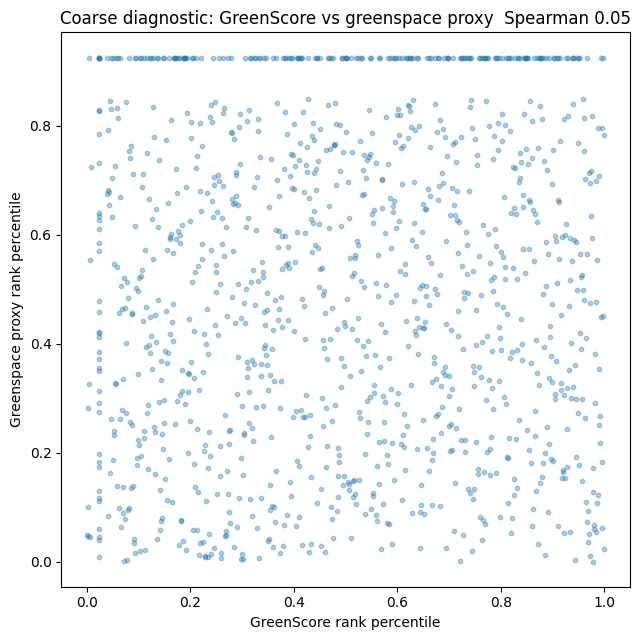

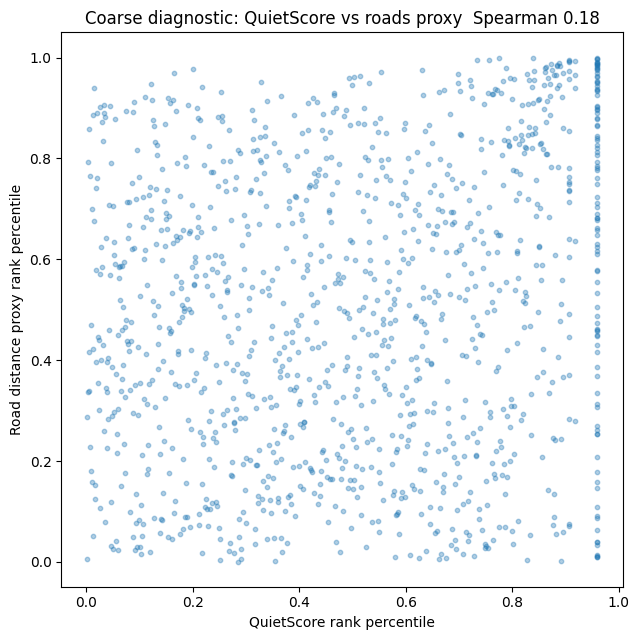

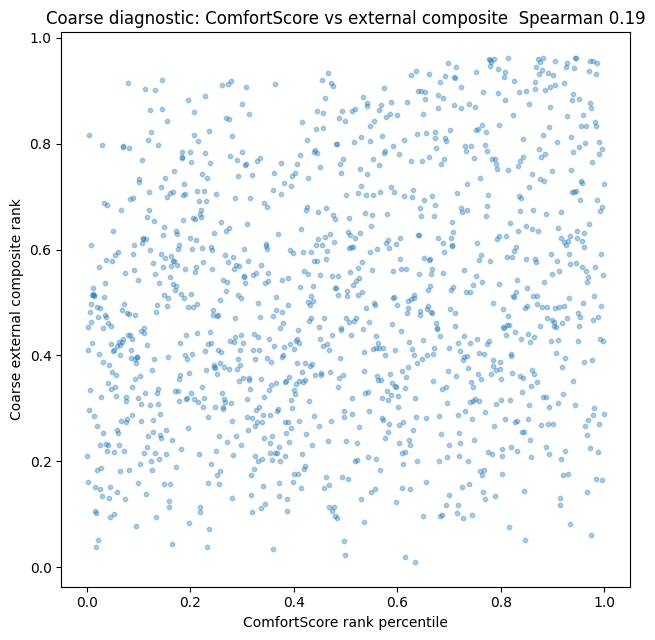

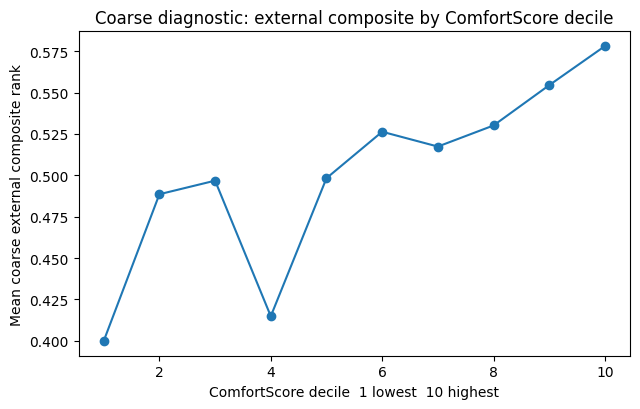

In [8]:
# ============================================================
# E1.3 Visual evidence of weakness plus a short justification
# Purpose
# Show reviewers what the weakness looks like, not just one number:
#   1 Rank scatter plots for each component
#   2 Decile trend for the external composite
#
# Why we do not add many other external datasets here
# External validation datasets must meet three requirements:
#   1 Matched spatial support: measurable inside the same venue buffers
#   2 Reproducible open access: stable download, clear licence, no paywalls
#   3 Construct relevance: measures a compatible structural concept
#
# Many popular datasets fail at least one:
#   StreetView based audits or footfall often require proprietary access and can embed personal data issues
#   Survey based wellbeing is not structural and has different support and sampling
#   High resolution mobility data is typically restricted and not reproducible
#
# Therefore, the primary external validation uses matched support proxies that we can reproduce fully:
#   OS Open Greenspace polygons inside buffers
#   OSM major roads geometry inside buffers
# ============================================================

def rank_scatter(x: pd.Series, y: pd.Series, title: str, xlab: str, ylab: str, out_png: Path):
    plt.figure(figsize=(6.5, 6.5))
    plt.scatter(x, y, s=10, alpha=0.35)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_png, dpi=250)
    plt.show()
    return out_png

# Rank scatter evidence for components
out1 = PLOTS_DIR / "coarse_rank_scatter_green_component.png"
out2 = PLOTS_DIR / "coarse_rank_scatter_quiet_component.png"
out3 = PLOTS_DIR / "coarse_rank_scatter_external_composite.png"

rank_scatter(
    rank_pct(mm["GreenScore"]),
    rank_pct(mm["ProxyGreenspace"]),
    f"Coarse diagnostic: GreenScore vs greenspace proxy  Spearman {g_rho:.2f}",
    "GreenScore rank percentile",
    "Greenspace proxy rank percentile",
    out1,
)

rank_scatter(
    rank_pct(mm["QuietScore"]),
    rank_pct(mm["ProxyRoadDistance"]),
    f"Coarse diagnostic: QuietScore vs roads proxy  Spearman {q_rho:.2f}",
    "QuietScore rank percentile",
    "Road distance proxy rank percentile",
    out2,
)

rank_scatter(
    mm["ComfortRank"],
    mm["ExternalComposite"],
    f"Coarse diagnostic: ComfortScore vs external composite  Spearman {c_rho:.2f}",
    "ComfortScore rank percentile",
    "Coarse external composite rank",
    out3,
)


# Decile trend evidence
tmp = mm.copy()
tmp["ComfortDecile"] = pd.qcut(tmp["ComfortRank"], q=10, labels=False, duplicates="drop").astype(int) + 1
trend = tmp.groupby("ComfortDecile", as_index=False).agg(
    n=("id", "size"),
    external_comp_mean=("ExternalComposite", "mean"),
)

plt.figure(figsize=(6.5, 4.2))
plt.plot(trend["ComfortDecile"], trend["external_comp_mean"], marker="o")
plt.xlabel("ComfortScore decile  1 lowest  10 highest")
plt.ylabel("Mean coarse external composite rank")
plt.title("Coarse diagnostic: external composite by ComfortScore decile")
plt.tight_layout()
out4 = PLOTS_DIR / "coarse_external_composite_by_decile.png"
plt.savefig(out4, dpi=250)
plt.show()

validation["plots"]["coarse_rank_scatter_green"] = str(out1)
validation["plots"]["coarse_rank_scatter_quiet"] = str(out2)
validation["plots"]["coarse_rank_scatter_composite"] = str(out3)
validation["plots"]["coarse_external_composite_by_decile"] = str(out4)




In [9]:
print_block(
    "Coarse diagnostic conclusion",
    [
        "These plots and correlations are intentionally retained even when weak.",
        "They demonstrate that naive distance based proxies do not validate buffer based exposure features.",
        "This motivates the matched support validation as the primary external validation strategy.",
    ],
)


Coarse diagnostic conclusion
These plots and correlations are intentionally retained even when weak.
They demonstrate that naive distance based proxies do not validate buffer based exposure features.
This motivates the matched support validation as the primary external validation strategy.


### E1.4Falsification baseline for coarse proxies

In [10]:
# ============================================================
# E1.4Falsification baseline for coarse proxies
# Purpose
# Show that any apparent alignment in Section A is not a numerical artefact.
# We shuffle the proxy values across venues and recompute the same rank correlations.
# Expected result: correlations collapse to ~0 after shuffling.
#
# Where to add this
# Place this cell immediately after A1 (after you compute g_rho, q_rho, c_rho and create mm).
# It uses: mm, g_rho, q_rho, c_rho, spearman, rank_pct
# ============================================================

import numpy as np
import pandas as pd

rng = np.random.default_rng(42)

# Keep only what we need from mm
mm_f = mm[["GreenScore", "QuietScore", "ComfortScore", "ProxyGreenspace", "ProxyRoadDistance"]].copy()

# Shuffle proxies across rows (break the link between venue and proxy)
shuf_green = mm_f["ProxyGreenspace"].to_numpy(dtype=float).copy()
shuf_roads = mm_f["ProxyRoadDistance"].to_numpy(dtype=float).copy()
rng.shuffle(shuf_green)
rng.shuffle(shuf_roads)

mm_f["ProxyGreenspace_shuf"] = shuf_green
mm_f["ProxyRoadDistance_shuf"] = shuf_roads

# Recompute the same rank based checks on shuffled proxies
g_rho_shuf = spearman(rank_pct(mm_f["GreenScore"]), rank_pct(mm_f["ProxyGreenspace_shuf"]))
q_rho_shuf = spearman(rank_pct(mm_f["QuietScore"]), rank_pct(mm_f["ProxyRoadDistance_shuf"]))

mm_f["ComfortRank"] = rank_pct(mm_f["ComfortScore"])
mm_f["GreenProxyRank_shuf"] = rank_pct(mm_f["ProxyGreenspace_shuf"])
mm_f["RoadProxyRank_shuf"] = rank_pct(mm_f["ProxyRoadDistance_shuf"])
mm_f["ExternalComposite_shuf"] = (
    0.5 * mm_f["GreenProxyRank_shuf"].to_numpy(dtype=float)
    + 0.5 * mm_f["RoadProxyRank_shuf"].to_numpy(dtype=float)
)

c_rho_shuf = spearman(mm_f["ComfortRank"], mm_f["ExternalComposite_shuf"])

validation["weak_validation_initial_proxies"]["falsification"] = {
    "spearman_rank_green_shuffled": float(g_rho_shuf),
    "spearman_rank_quiet_shuffled": float(q_rho_shuf),
    "spearman_rank_composite_shuffled": float(c_rho_shuf),
}


print_block(
    "Coarse proxy falsification baseline",
    [
        f"Observed Spearman ranks GreenScore vs greenspace proxy: {g_rho:.3f}",
        f"Shuffled Spearman ranks GreenScore vs greenspace proxy: {g_rho_shuf:.3f}",
        "",
        f"Observed Spearman ranks QuietScore vs roads proxy: {q_rho:.3f}",
        f"Shuffled Spearman ranks QuietScore vs roads proxy: {q_rho_shuf:.3f}",
        "",
        f"Observed Spearman ranks ComfortScore vs coarse external composite: {c_rho:.3f}",
        f"Shuffled Spearman ranks ComfortScore vs shuffled coarse composite: {c_rho_shuf:.3f}",
        "",
        "Interpretation",
        "If the shuffled values are near zero, the observed correlations reflect real structure,",
        "but the small effect sizes still indicate that distance proxies are a weak diagnostic.",
    ],
)

# Save for auditability
OUT_A3 = TABLES_DIR / "coarse_proxy_falsification_baseline.csv"
pd.DataFrame(
    [
        {
            "spearman_rank_GreenScore_vs_ProxyGreenspace_observed": float(g_rho),
            "spearman_rank_GreenScore_vs_ProxyGreenspace_shuffled": float(g_rho_shuf),
            "spearman_rank_QuietScore_vs_ProxyRoadDistance_observed": float(q_rho),
            "spearman_rank_QuietScore_vs_ProxyRoadDistance_shuffled": float(q_rho_shuf),
            "spearman_rank_ComfortScore_vs_coarse_composite_observed": float(c_rho),
            "spearman_rank_ComfortScore_vs_coarse_composite_shuffled": float(c_rho_shuf),
            "n_used": int(len(mm_f)),
        }
    ]
).to_csv(OUT_A3, index=False)

validation["tables"]["coarse_proxy_falsification_baseline"] = str(OUT_A3)




Coarse proxy falsification baseline
Observed Spearman ranks GreenScore vs greenspace proxy: 0.055
Shuffled Spearman ranks GreenScore vs greenspace proxy: 0.019

Observed Spearman ranks QuietScore vs roads proxy: 0.182
Shuffled Spearman ranks QuietScore vs roads proxy: -0.012

Observed Spearman ranks ComfortScore vs coarse external composite: 0.188
Shuffled Spearman ranks ComfortScore vs shuffled coarse composite: -0.029

Interpretation
If the shuffled values are near zero, the observed correlations reflect real structure,
but the small effect sizes still indicate that distance proxies are a weak diagnostic.


## ✅ E2: Strong External Validation using Matched Spatial Support Proxies

**Overview**
Section E1 used coarse distance proxies as a weak diagnostic. **This section provides primary external validation** by testing GreenScore and QuietScore against external datasets measured within the same venue buffers used in feature engineering.

**External Data Sources**
1. **OS Open Greenspace** - GreenspaceSite polygons
2. **OpenStreetMap** - Major roads geometry (cached locally)

**Computed Metrics (per venue & radius)**
- Greenspace fraction inside buffer
- Major road length density inside buffer  
- Quietness proxy derived from road density rank (higher = quieter)

**Validation Tests**
For each radius, compute **Spearman correlation** on rank percentiles:
- GreenScore vs. greenspace proxy
- QuietScore vs. road quietness proxy




### E2.1 Locate and load matched support layers

In [11]:
# ============================================================
# E2.1 Locate and load matched support layers
# Purpose
# Load the two external layers used for matched support validation
#   1 OS Open Greenspace GreenspaceSite polygons
#   2 OSM major roads geometry (cached gpkg)
#
# Matched support means we can measure proxies inside the same venue buffers
# used in feature engineering, making this a stronger validation than Section A.
# ============================================================

matched_ok = True
missing_reasons = []

sites_path = find_greenspace_sites_shp(GREENS_EXTRACT_DIR)
if sites_path is None:
    matched_ok = False
    missing_reasons.append(
        f"GreenspaceSite shapefile not found inside {GREENS_EXTRACT_DIR}"
    )

if not MAJOR_ROADS_GPKG.exists():
    matched_ok = False
    missing_reasons.append(
        f"Major roads gpkg missing at {MAJOR_ROADS_GPKG}"
    )

if not matched_ok:
    validation["strong_validation_matched_support"] = {
        "status": "skipped",
        "reasons": missing_reasons,
        "extract_dir": str(GREENS_EXTRACT_DIR),
        "major_roads_gpkg": str(MAJOR_ROADS_GPKG),
    }
    print_block("Matched support inputs missing", missing_reasons)

else:
    sites = gpd.read_file(sites_path)
    if sites.crs is None:
        raise ValueError("Greenspace sites file has no CRS")

    sites_m = sites.to_crs(TARGET_CRS)
    sites_m = sites_m[sites_m.geometry.notna() & (~sites_m.geometry.is_empty)].copy()

    roads = gpd.read_file(MAJOR_ROADS_GPKG, layer=MAJOR_ROADS_LAYER)
    if roads.crs is None:
        # If cached layer was saved without CRS metadata, assume British National Grid
        roads = roads.set_crs(TARGET_CRS, allow_override=True)

    roads_m = roads.to_crs(TARGET_CRS)
    roads_m = roads_m[roads_m.geometry.notna() & (~roads_m.geometry.is_empty)].copy()

    sites_sidx = sites_m.sindex
    roads_sidx = roads_m.sindex

    validation["strong_validation_matched_support"] = {
        "status": "inputs_loaded",
        "datasets": {
            "greenspace_sites_shp": str(sites_path),
            "major_roads_gpkg": str(MAJOR_ROADS_GPKG),
            "major_roads_layer": str(MAJOR_ROADS_LAYER),
        },
        "counts": {
            "greenspace_polygons": int(len(sites_m)),
            "major_roads_features": int(len(roads_m)),
        },
    }

    print_block(
        "Matched support layers loaded",
        [
            f"greenspace sites shp: {sites_path}",
            f"greenspace polygons: {len(sites_m)}",
            f"major roads features: {len(roads_m)}",
        ],
    )



Matched support layers loaded
greenspace sites shp: /home/sai/test/notebook_test/data/raw/os_open_greenspace/opgrsp_essh_tq_extracted/data/TQ_GreenspaceSite.shp
greenspace polygons: 21928
major roads features: 12321


### E2.2 Compute matched support proxies inside venue buffers

In [12]:
# ============================================================
# E2.2 Compute matched support proxies inside venue buffers
# ============================================================

"""
We compute two proxies inside the same buffer radii used in feature engineering.

Greenspace fraction
Area of greenspace polygons intersecting the buffer divided by buffer area.

Major road length density
Total length of major road lines intersecting the buffer divided by buffer area.

Quietness proxy from roads
Higher road density implies less quiet.
We convert this into a quietness proxy using the rank of negative road density, so higher is quieter.
This is still not modelled noise exposure, but it is matched in spatial support and therefore a better proxy.
"""

RADII_M = [100, 300, 500]

def greenspace_fraction(points: gpd.GeoDataFrame, radius_m: int) -> pd.Series:
    bufs = points.geometry.buffer(float(radius_m))
    out = np.zeros(len(points), dtype=float)

    for i, buf in enumerate(bufs):
        cand_idx = list(sites_sidx.intersection(buf.bounds))
        if not cand_idx:
            out[i] = 0.0
            continue
        cand = sites_m.iloc[cand_idx]
        inter_area = cand.geometry.intersection(buf).area.sum()
        denom = float(buf.area)
        out[i] = float(inter_area / denom) if denom > 0 else 0.0

    return pd.Series(out, index=points.index)

def road_length_density(points: gpd.GeoDataFrame, radius_m: int) -> pd.Series:
    bufs = points.geometry.buffer(float(radius_m))
    out = np.zeros(len(points), dtype=float)

    for i, buf in enumerate(bufs):
        cand_idx = list(roads_sidx.intersection(buf.bounds))
        if not cand_idx:
            out[i] = 0.0
            continue
        cand = roads_m.iloc[cand_idx]
        inter_len = cand.geometry.intersection(buf).length.sum()
        denom = float(buf.area)
        out[i] = float(inter_len / denom) if denom > 0 else 0.0

    return pd.Series(out, index=points.index)

proxy_df = pd.DataFrame({"id": gdf["id"].astype(str)})

for r in RADII_M:
    frac = greenspace_fraction(gdf, r)
    dens = road_length_density(gdf, r)

    proxy_df[f"GreenspaceFrac_{r}m"] = frac.astype(float)
    proxy_df[f"MajorRoadLenDens_{r}m"] = dens.astype(float)

    proxy_df[f"GreenProxyRank_{r}m"] = rank_pct(frac)

    # Quietness proxy  higher is quieter
    proxy_df[f"RoadQuietProxyRank_{r}m"] = rank_pct(np.negative(dens.to_numpy(dtype=float)))

OUT_PROXY_TABLE = RAW_DIR / "external_validation_upgraded_buffers.csv"
proxy_df.to_csv(OUT_PROXY_TABLE, index=False)

validation["tables"]["matched_support_proxy_table"] = str(OUT_PROXY_TABLE)

print_block(
    "Matched support proxy table saved",
    [
        f"path: {OUT_PROXY_TABLE}",
        f"rows: {len(proxy_df)}",
        f"radii: {RADII_M}",
    ],
)



Matched support proxy table saved
path: /home/sai/test/notebook_test/data/raw/external_validation_upgraded_buffers.csv
rows: 1211
radii: [100, 300, 500]


### E2.3 Agreement by radius and selection of best radius

In [13]:
# ============================================================
# E2.3 Agreement by radius and selection of best radius
# ============================================================

"""
We quantify agreement in rank space across radii.

We report
1 GreenScore vs greenspace proxy rank
2 QuietScore vs road quietness proxy rank

We choose the best radius as the one that maximises the sum of absolute component correlations.
This is a simple, transparent rule and avoids tuning on the final composite directly.
"""

if not matched_ok:
    reasons = validation.get("strong_validation_matched_support", {}).get("reasons", ["matched inputs missing"])
    print_block("Matched support validation skipped", reasons)
else:
    base = gdf[["id", "ComfortScore", "GreenScore", "QuietScore"]].copy()
    base["id"] = base["id"].astype(str)

    merged = base.merge(proxy_df, on="id", how="inner").dropna()

    rows = []
    for r in RADII_M:
        g_proxy = merged[f"GreenProxyRank_{r}m"]
        q_proxy = merged[f"RoadQuietProxyRank_{r}m"]

        g_s = spearman(rank_pct(merged["GreenScore"]), g_proxy)
        q_s = spearman(rank_pct(merged["QuietScore"]), q_proxy)

        rows.append(
            {
                "radius_m": int(r),
                "spearman_rank_GreenScore_vs_GreenProxy": float(g_s),
                "spearman_rank_QuietScore_vs_RoadQuietProxy": float(q_s),
            }
        )

    summary = pd.DataFrame(rows).sort_values("radius_m").reset_index(drop=True)
    summary["abs_target_sum"] = (
        np.abs(summary["spearman_rank_GreenScore_vs_GreenProxy"].to_numpy(dtype=float))
        + np.abs(summary["spearman_rank_QuietScore_vs_RoadQuietProxy"].to_numpy(dtype=float))
    )

    best_r = int(summary.sort_values("abs_target_sum", ascending=False).iloc[0]["radius_m"])

    OUT_SUMMARY = TABLES_DIR / "matched_support_spearman_by_radius.csv"
    summary.to_csv(OUT_SUMMARY, index=False)

    validation["tables"]["matched_support_spearman_by_radius"] = str(OUT_SUMMARY)
    validation["strong_validation_matched_support"] = {
        "status": "completed",
        "n": int(len(merged)),
        "radii_m": [int(x) for x in RADII_M],
        "table": summary.to_dict(orient="records"),
        "best_radius_selected_m": int(best_r),
        "datasets": {
            "greenspace_sites_shp": str(sites_path),
            "major_roads_gpkg": str(MAJOR_ROADS_GPKG),
        },
        "expected_direction": {
            "GreenScore_vs_GreenProxy": "positive",
            "QuietScore_vs_RoadQuietProxy": "positive",
        },
    }

    print_block(
        "Matched support validation summary",
        [
            f"rows: {len(merged)}",
            f"best radius selected: {best_r} m",
            f"saved table: {OUT_SUMMARY}",
        ],
    )

    display(summary)



Matched support validation summary
rows: 1211
best radius selected: 500 m
saved table: /home/sai/test/notebook_test/data/results/validation_tables/matched_support_spearman_by_radius.csv


,radius_m,spearman_rank_GreenScore_vs_GreenProxy,spearman_rank_QuietScore_vs_RoadQuietProxy,abs_target_sum
0,100,0.063993,0.302583,0.366576
1,300,0.067170,0.591420,0.658590
2,500,0.168897,0.503004,0.671901


### E2.4 Plot component alignment by radius for the dissertation

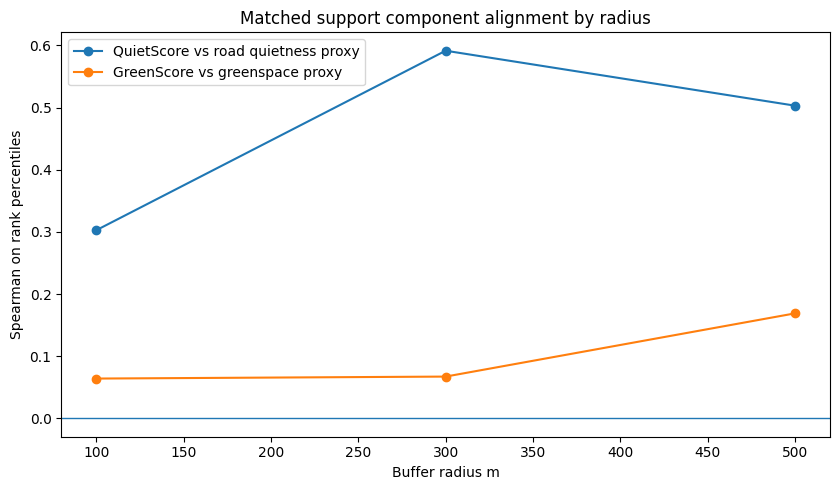

Saved: /home/sai/test/notebook_test/data/results/validation_plots/matched_support_component_alignment_by_radius.png


In [14]:
# ============================================================
# E2.4 Plot component alignment by radius for the dissertation
# ============================================================

if not matched_ok:
    pass
else:
    fig = plt.figure(figsize=(8.5, 5))
    ax = plt.gca()

    ax.plot(
        summary["radius_m"],
        summary["spearman_rank_QuietScore_vs_RoadQuietProxy"],
        marker="o",
        label="QuietScore vs road quietness proxy",
    )
    ax.plot(
        summary["radius_m"],
        summary["spearman_rank_GreenScore_vs_GreenProxy"],
        marker="o",
        label="GreenScore vs greenspace proxy",
    )

    ax.axhline(0.0, linewidth=1)
    ax.set_xlabel("Buffer radius m")
    ax.set_ylabel("Spearman on rank percentiles")
    ax.set_title("Matched support component alignment by radius")
    ax.legend()

    out_png = PLOTS_DIR / "matched_support_component_alignment_by_radius.png"
    plt.tight_layout()
    plt.savefig(out_png, dpi=250)
    plt.show()

    validation["plots"]["matched_support_component_alignment_by_radius"] = str(out_png)
    print("Saved:", out_png)


## ✅ E3 Upgraded External Composite and Rank Agreement

**Purpose**

- Construct a single upgraded external comparator for ComfortScore using independent proxies measured on the same matched spatial support.

**Why this matters**

- ComfortScore is a composite index and is not expected to align strongly with any single proxy. A more defensible convergent check is to compare it against an external composite built from independent datasets on identical spatial support.

**Method**

1. Select the buffer radius based on Section B where component alignment is strongest  
2. Build **ExternalCompositeUpgraded** as an equal weight average of proxy rank scores at that radius  
3. Compare ComfortScore rank with ExternalCompositeUpgraded rank using Spearman correlation  
4. Add a falsification baseline by shuffling the external composite  
5. Save a reusable rank table and a scatter plot for reporting and review


###  E3.1 Build upgraded external composite at selected radius

In [15]:
# ============================================================
# E3.1 Build upgraded external composite at selected radius
# ============================================================

if not matched_ok:
    validation["external_composite"] = {
        "status": "skipped",
        "reason": "matched support inputs missing in Section B",
    }
    print_block("Section C skipped", [validation["external_composite"]["reason"]])

else:
    # Radius selection
    # Prefer best_r from Section B, else default to 300 m
    try:
        best_r = int(best_r)
    except Exception:
        best_r = int(validation.get("strong_validation_matched_support", {}).get("best_radius_selected_m", 300))

    need_cols = [f"GreenProxyRank_{best_r}m", f"RoadQuietProxyRank_{best_r}m"]
    miss = [c for c in need_cols if c not in proxy_df.columns]
    if miss:
        raise ValueError(f"proxy_df missing required columns for radius {best_r}: {miss}")

    comp = gdf[["id", "ComfortScore"]].copy()
    comp["id"] = comp["id"].astype(str)

    comp = comp.merge(
        proxy_df[["id"] + need_cols].copy(),
        on="id",
        how="inner",
    ).dropna()

    # Work in rank space because both sides are ordinal by design
    comp["ComfortRank"] = rank_pct(comp["ComfortScore"])
    comp["ExternalCompositeUpgraded"] = (
        0.5 * comp[need_cols[0]].to_numpy(dtype=float)
        + 0.5 * comp[need_cols[1]].to_numpy(dtype=float)
    )

    rho = spearman(comp["ComfortRank"], comp["ExternalCompositeUpgraded"])

    # Falsification baseline: shuffle composite across venues
    rng = np.random.default_rng(42)
    shuf = comp["ExternalCompositeUpgraded"].to_numpy(dtype=float).copy()
    rng.shuffle(shuf)
    rho_shuf = spearman(comp["ComfortRank"], pd.Series(shuf, index=comp.index))

    validation["external_composite"] = {
        "status": "completed",
        "radius_m": int(best_r),
        "n": int(len(comp)),
        "construction": "0.5 * GreenProxyRank + 0.5 * RoadQuietProxyRank at selected radius",
        "spearman_rank_comfort_vs_external_composite": float(rho),
        "falsification_spearman_rank_shuffled": float(rho_shuf),
        "expected_direction": "positive",
        "notes": [
            "This is convergent validity in ordinal space, not a calibration of absolute accuracy.",
            "The composite uses matched support proxies, but it still does not directly observe noise exposure or subjective comfort.",
        ],
    }

    print_block(
        "Upgraded external composite summary",
        [
            f"radius selected: {best_r} m",
            f"rows used: {len(comp)}",
            f"Spearman rank (ComfortRank vs ExternalCompositeUpgraded): {rho:.3f}",
            f"Falsification Spearman after shuffle: {rho_shuf:.3f}",
        ],
    )

    # Save a reusable table
    out_tbl = pd.DataFrame(
        {
            "id": comp["id"].astype(str).values,
            "ComfortScore": comp["ComfortScore"].astype(float).values,
            "ComfortPercentile": comp["ComfortRank"].astype(float).values,
            "ExternalComposite": comp["ExternalCompositeUpgraded"].astype(float).values,
            "ExternalCompositePercentile": rank_pct(comp["ExternalCompositeUpgraded"]).astype(float).values,
        }
    )

    OUT_CSV = TABLES_DIR / f"external_composite_rank_table_{best_r}m.csv"
    out_tbl.to_csv(OUT_CSV, index=False)
    TABLE_PATHS[f"external_composite_rank_table_{best_r}m"] = str(OUT_CSV)

    print("Saved table:", OUT_CSV)



Upgraded external composite summary
radius selected: 500 m
rows used: 1211
Spearman rank (ComfortRank vs ExternalCompositeUpgraded): 0.537
Falsification Spearman after shuffle: 0.016
Saved table: /home/sai/test/notebook_test/data/results/validation_tables/external_composite_rank_table_500m.csv


### E3.2 Visual evidence: percentile scatter and decile trend

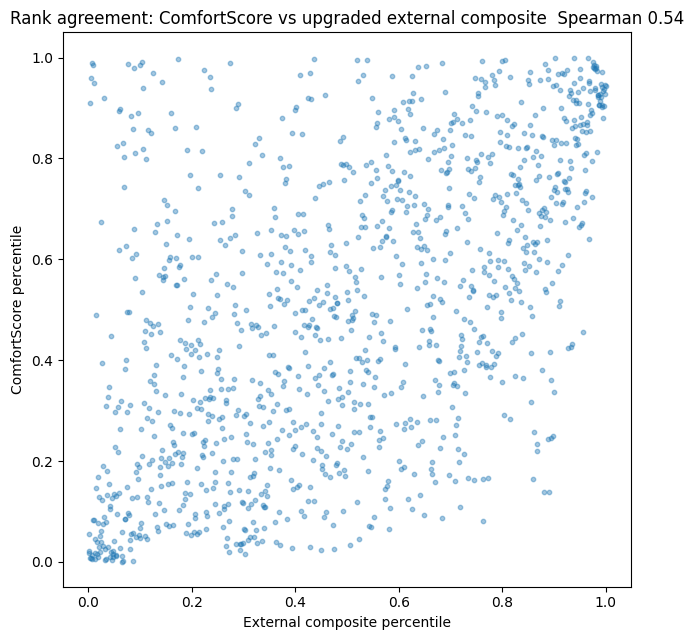

Saved plot: /home/sai/test/notebook_test/data/results/validation_plots/rank_percentile_scatter_external_vs_comfort_500m.png


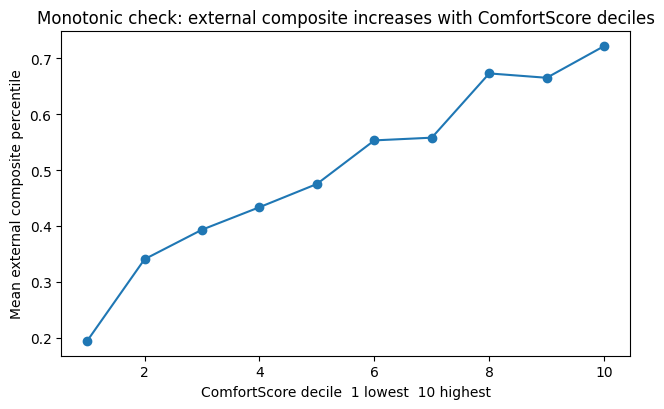

Saved plot: /home/sai/test/notebook_test/data/results/validation_plots/external_composite_by_comfort_decile_500m.png
Saved table: /home/sai/test/notebook_test/data/results/validation_tables/external_composite_by_comfort_decile_500m.csv


In [16]:
# ============================================================
# E3.2 Visual evidence: percentile scatter and decile trend
# Purpose
# Give reviewers visual intuition beyond a single correlation.
# ============================================================

if validation.get("external_composite", {}).get("status") != "completed":
    print_block("Section C plots skipped", ["External composite not available"])
else:
    best_r = int(validation["external_composite"]["radius_m"])

    # Reload from saved table for reproducibility
    tbl_key = f"external_composite_rank_table_{best_r}m"
    if tbl_key not in TABLE_PATHS:
        raise ValueError("External composite rank table path not found in TABLE_PATHS")

    out_tbl = pd.read_csv(TABLE_PATHS[tbl_key])

    rho = float(validation["external_composite"]["spearman_rank_comfort_vs_external_composite"])

    # Scatter plot
    plt.figure(figsize=(6.5, 6.5))
    plt.scatter(out_tbl["ExternalCompositePercentile"], out_tbl["ComfortPercentile"], s=10, alpha=0.4)
    plt.xlabel("External composite percentile")
    plt.ylabel("ComfortScore percentile")
    plt.title(f"Rank agreement: ComfortScore vs upgraded external composite  Spearman {rho:.2f}")
    plt.tight_layout()

    out_png1 = PLOTS_DIR / f"rank_percentile_scatter_external_vs_comfort_{best_r}m.png"
    plt.savefig(out_png1, dpi=250)
    plt.show()

    PLOT_PATHS[f"rank_percentile_scatter_external_vs_comfort_{best_r}m"] = str(out_png1)
    print("Saved plot:", out_png1)

    # Decile trend plot
    tmp = out_tbl.copy()
    tmp["ComfortDecile"] = pd.qcut(tmp["ComfortPercentile"], q=10, labels=False, duplicates="drop").astype(int) + 1
    trend = tmp.groupby("ComfortDecile", as_index=False).agg(
        n=("id", "size"),
        external_mean=("ExternalCompositePercentile", "mean"),
    )

    plt.figure(figsize=(6.5, 4.2))
    plt.plot(trend["ComfortDecile"], trend["external_mean"], marker="o")
    plt.xlabel("ComfortScore decile  1 lowest  10 highest")
    plt.ylabel("Mean external composite percentile")
    plt.title("Monotonic check: external composite increases with ComfortScore deciles")
    plt.tight_layout()

    out_png2 = PLOTS_DIR / f"external_composite_by_comfort_decile_{best_r}m.png"
    plt.savefig(out_png2, dpi=250)
    plt.show()

    PLOT_PATHS[f"external_composite_by_comfort_decile_{best_r}m"] = str(out_png2)
    print("Saved plot:", out_png2)

    # Save trend table too
    out_csv = TABLES_DIR / f"external_composite_by_comfort_decile_{best_r}m.csv"
    trend.to_csv(out_csv, index=False)
    TABLE_PATHS[f"external_composite_by_comfort_decile_{best_r}m"] = str(out_csv)
    print("Saved table:", out_csv)


### E3.3 Explanation

In [17]:
# ============================================================
# E3.3 Interpretation text lines for Results
# ============================================================

if validation.get("external_composite", {}).get("status") != "completed":
    print_block("Section C interpretation", ["External composite not available"])
else:
    ec = validation["external_composite"]
    lines = [
        "Section E3 provides a convergent validity check for the composite index.",
        f"An upgraded external composite was constructed from matched support proxy ranks at {ec['radius_m']} m.",
        f"ComfortScore rank agreement with the upgraded composite is Spearman {ec['spearman_rank_comfort_vs_external_composite']:.3f}.",
        f"A falsification baseline confirms the signal is not mechanical: shuffling yields Spearman {ec['falsification_spearman_rank_shuffled']:.3f}.",
        "This supports ordinal consistency with independent structural indicators, without claiming pointwise accuracy.",
    ]
    print_block("Explanation:", lines)



Explanation:
Section E3 provides a convergent validity check for the composite index.
An upgraded external composite was constructed from matched support proxy ranks at 500 m.
ComfortScore rank agreement with the upgraded composite is Spearman 0.537.
A falsification baseline confirms the signal is not mechanical: shuffling yields Spearman 0.016.
This supports ordinal consistency with independent structural indicators, without claiming pointwise accuracy.


## ✅ E4 Policy layer convergent check using LAEI 2019 Focus Areas

**What this section does**

This section checks whether **ComfortScore** is systematically lower in places flagged by an independent London policy dataset: **LAEI 2019 Air Quality Focus Areas**.

**Why we include this**

LAEI focus areas were not used to build ComfortScore and they represent a policy relevant layer linked to environmental stress and exposure. This is not a component matched proxy for noise or greenness, so we treat it as a **convergent policy check** rather than a strict validation.

**How it works**

1. Load the LAEI Focus Areas polygon layer and ensure it is in the same CRS as the venues.
2. Convert venue geometries to representative points where needed and test whether each venue falls inside a focus area.
3. Compare ComfortScore distributions for venues inside versus outside focus areas using robust summaries:
   - medians and median difference
   - a Mann Whitney U test if SciPy is available
   - an effect size estimate using Cliff delta
4. Save a plot and a small CSV summary table for auditability.


###  E4.1 Helpers for LAEI policy check

In [18]:
# ============================================================
# E4.1 Helpers for LAEI policy check
# ============================================================

def infer_crs_from_bounds(bounds) -> str:
    minx, miny, maxx, maxy = [float(x) for x in bounds]
    # EPSG:4326 typical lon lat ranges
    if (abs(minx) <= 200.0) and (abs(maxx) <= 200.0) and (abs(miny) <= 100.0) and (abs(maxy) <= 100.0):
        return "EPSG:4326"
    return "EPSG:27700"

def representative_points_series(geom: gpd.GeoSeries) -> gpd.GeoSeries:
    non_point = geom.geom_type != "Point"
    if bool(non_point.any()):
        geom = geom.copy()
        geom.loc[non_point] = geom.loc[non_point].representative_point()
    return geom

def mann_whitney_p(a: np.ndarray, b: np.ndarray):
    try:
        from scipy.stats import mannwhitneyu
        a = a[np.isfinite(a)]
        b = b[np.isfinite(b)]
        if len(a) < 10 or len(b) < 10:
            return None
        return float(mannwhitneyu(a, b, alternative="two_sided").pvalue)
    except Exception:
        return None

def cliffs_delta(a: np.ndarray, b: np.ndarray):
    a = a[np.isfinite(a)]
    b = b[np.isfinite(b)]
    if len(a) < 10 or len(b) < 10:
        return None
    gt = 0
    lt = 0
    for x in a:
        gt += int(np.sum(x > b))
        lt += int(np.sum(x < b))
    denom = len(a) * len(b)
    if denom == 0:
        return None
    return float((gt - lt) / denom)


### E4.2 LAEI Focus Areas policy layer check

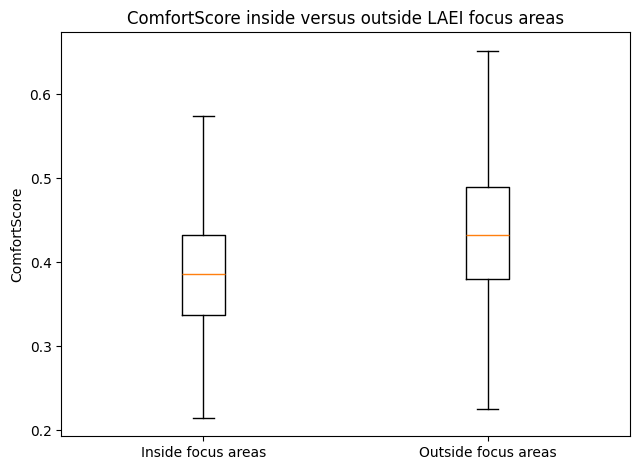


LAEI policy validation summary
venues total: 1211
n inside: 332  n outside: 879
median outside: 0.433
median inside: 0.387
median difference (outside minus inside): 0.046
mann whitney p: NA
cliff delta: 0.3405773263703277
saved plot: /home/sai/test/notebook_test/data/results/validation_plots/laei_inside_outside_boxplot.png
saved table: /home/sai/test/notebook_test/data/results/validation_tables/laei_focus_areas_summary.csv


In [19]:
# ============================================================
# E4.2 LAEI Focus Areas policy layer check
# Expected direction: ComfortScore outside focus areas should be higher
#
# Important implementation note
# A spatial join can duplicate venue rows if a point intersects multiple polygons.
# We collapse back to one record per venue id using inside_focus_area = any match.
# ============================================================

policy_ok = LAEI_SHP is not None and Path(LAEI_SHP).exists()

if not policy_ok:
    validation["policy_validation_laei"] = {
        "status": "skipped",
        "reason": "LAEI shapefile not found",
        "path": str(LAEI_SHP) if LAEI_SHP else "missing",
    }
    print_block("LAEI policy validation skipped", [validation["policy_validation_laei"]["reason"]])

else:
    laei = gpd.read_file(LAEI_SHP)
    laei = laei[laei.geometry.notna() & (~laei.geometry.is_empty)].copy()

    if laei.crs is None:
        guessed = infer_crs_from_bounds(laei.total_bounds)
        laei = laei.set_crs(guessed, allow_override=True)
        validation.setdefault("policy_validation_laei", {})["crs_inferred"] = str(guessed)

    laei = laei.to_crs(TARGET_CRS)

    # Use representative points for robust within test
    pts = gdf[["id", "ComfortScore", "geometry"]].copy()
    pts["id"] = pts["id"].astype(str)
    pts = pts.set_geometry(representative_points_series(pts.geometry)).copy()

    # Spatial join: venue point inside any focus area polygon
    joined = gpd.sjoin(
        pts,
        laei[["geometry"]].copy(),
        how="left",
        predicate="within",
    )

    # Collapse duplicates to one record per venue id
    joined = (
        joined.assign(inside_focus_area=joined["index_right"].notna())
              .groupby("id", as_index=False)
              .agg(
                  ComfortScore=("ComfortScore", "first"),
                  inside_focus_area=("inside_focus_area", "max"),
              )
    )

    inside = joined.loc[joined["inside_focus_area"], "ComfortScore"].dropna().astype(float)
    outside = joined.loc[~joined["inside_focus_area"], "ComfortScore"].dropna().astype(float)

    med_in = float(inside.median()) if len(inside) else float("nan")
    med_out = float(outside.median()) if len(outside) else float("nan")
    diff = float(med_out - med_in)

    pval = mann_whitney_p(outside.to_numpy(dtype=float), inside.to_numpy(dtype=float))
    delta = cliffs_delta(outside.to_numpy(dtype=float), inside.to_numpy(dtype=float))

    # Plot
    out_png = PLOTS_DIR / "laei_inside_outside_boxplot.png"
    plt.figure(figsize=(6.5, 4.8))
    plt.boxplot(
        [inside.values, outside.values],
        labels=["Inside focus areas", "Outside focus areas"],
        showfliers=False,
    )
    plt.ylabel("ComfortScore")
    plt.title("ComfortScore inside versus outside LAEI focus areas")
    plt.tight_layout()
    plt.savefig(out_png, dpi=250)
    plt.show()

    # Table
    out_csv = TABLES_DIR / "laei_focus_areas_summary.csv"
    tab = pd.DataFrame(
        [
            {
                "dataset": "LAEI 2019 Focus Areas",
                "n_total": int(len(joined)),
                "n_inside": int(joined["inside_focus_area"].sum()),
                "n_outside": int((~joined["inside_focus_area"]).sum()),
                "median_inside": float(med_in),
                "median_outside": float(med_out),
                "median_difference_outside_minus_inside": float(diff),
                "mann_whitney_p": pval,
                "cliffs_delta_outside_vs_inside": delta,
                "expected_direction": "outside_higher",
            }
        ]
    )
    tab.to_csv(out_csv, index=False)

    # Record in validation dict and central path trackers
    validation["policy_validation_laei"] = {
        "status": "completed",
        "dataset": "LAEI 2019 Focus Areas",
        "path": str(LAEI_SHP),
        "counts": {
            "n_total": int(len(joined)),
            "n_inside": int(joined["inside_focus_area"].sum()),
            "n_outside": int((~joined["inside_focus_area"]).sum()),
        },
        "comfortscore": {
            "median_inside": float(med_in),
            "median_outside": float(med_out),
            "median_difference_outside_minus_inside": float(diff),
            "mann_whitney_p": pval,
            "cliffs_delta_outside_vs_inside": delta,
        },
        "expected_direction": "outside_higher",
        "notes": [
            "Policy layer convergent check rather than component matched validation.",
            "Rows are collapsed to one per venue id to avoid double counting from overlapping polygons.",
        ],
    }

    PLOT_PATHS["laei_inside_outside_boxplot"] = str(out_png)
    TABLE_PATHS["laei_focus_areas_summary"] = str(out_csv)

    print_block(
        "LAEI policy validation summary",
        [
            f"venues total: {int(len(joined))}",
            f"n inside: {int(joined['inside_focus_area'].sum())}  n outside: {int((~joined['inside_focus_area']).sum())}",
            f"median outside: {med_out:.3f}",
            f"median inside: {med_in:.3f}",
            f"median difference (outside minus inside): {diff:.3f}",
            f"mann whitney p: {pval if pval is not None else 'NA'}",
            f"cliff delta: {delta if delta is not None else 'NA'}",
            f"saved plot: {out_png}",
            f"saved table: {out_csv}",
        ],
    )


### E4.3 Explanation

In [20]:
# ============================================================
# E4.3 Manuscript ready lines
# ============================================================

la = validation.get("policy_validation_laei", {})

if la.get("status") != "completed":
    print_block("Section D lines", ["LAEI policy check not available in this run"])
else:
    cs = la.get("comfortscore", {})
    lines = [
        "Section D provides an independent policy layer convergent check using LAEI 2019 Focus Areas.",
        f"ComfortScore is lower inside focus areas than outside (median outside {cs.get('median_outside'):.3f}, median inside {cs.get('median_inside'):.3f}).",
        f"Median difference outside minus inside is {cs.get('median_difference_outside_minus_inside'):.3f}.",
        "This check is interpreted as policy relevant convergent evidence rather than component matched validation.",
    ]
    print_block("Explanation:", lines)



Explanation:
Section D provides an independent policy layer convergent check using LAEI 2019 Focus Areas.
ComfortScore is lower inside focus areas than outside (median outside 0.433, median inside 0.387).
Median difference outside minus inside is 0.046.
This check is interpreted as policy relevant convergent evidence rather than component matched validation.


## ✅ E5 Spatial structure using global Moran I

**What this section does**

This section tests whether **ComfortScore** exhibits spatial autocorrelation across venues.

**Why we include this**

Environmental conditions are spatially structured. If ComfortScore behaves like a spatial environmental index, nearby venues should tend to have similar values. A positive Moran I with a small p value supports this interpretation.

This is not a test of point level accuracy. It is a check that the resulting index has plausible spatial structure.

**How it works**
1. Convert venue geometries to representative points where needed.
2. Build a K nearest neighbour spatial weights matrix from venue coordinates.
3. Compute global Moran I with permutation based p value.
4. Save a small CSV summary so the result is auditable and reproducible.


### E5.1 Global Moran I using KNN weights

In [21]:
# ============================================================
# E5.1 Global Moran I using KNN weights
# ============================================================

moran_ok = True
try:
    from libpysal.weights import KNN
    from esda.moran import Moran
except Exception as e:
    moran_ok = False
    moran_err = str(e)

if not moran_ok:
    validation["spatial_structure"] = {
        "status": "skipped",
        "reason": moran_err,
    }
    print_block("Moran I skipped", [moran_err])

else:
    geom = gdf.geometry
    geom_pts = geom.copy()
    non_point = geom_pts.geom_type != "Point"
    if bool(non_point.any()):
        geom_pts.loc[non_point] = geom_pts.loc[non_point].representative_point()

    coords = np.vstack([geom_pts.x.to_numpy(dtype=float), geom_pts.y.to_numpy(dtype=float)]).T

    k = 8
    w = KNN.from_array(coords, k=k)
    w.transform = "R"

    y = gdf["ComfortScore"].astype(float).to_numpy()
    mi = Moran(y, w, permutations=999)

    validation["spatial_structure"] = {
        "status": "completed",
        "weights": "KNN row standardised",
        "k": int(k),
        "permutations": int(mi.permutations),
        "moran_i": float(mi.I),
        "p_sim": float(mi.p_sim),
        "z_sim": float(mi.z_sim),
        "notes": [
            "This supports spatial structuring consistent with an environmental index.",
            "It does not validate venue level accuracy.",
        ],
    }

    out_csv = TABLES_DIR / "moran_i_comfortscore.csv"
    pd.DataFrame(
        [
            {
                "k": int(k),
                "moran_i": float(mi.I),
                "p_sim": float(mi.p_sim),
                "z_sim": float(mi.z_sim),
                "permutations": int(mi.permutations),
            }
        ]
    ).to_csv(out_csv, index=False)

    TABLE_PATHS["moran_i_comfortscore"] = str(out_csv)

    print_block(
        "Spatial structure summary",
        [
            f"Global Moran I: {float(mi.I):.3f}",
            f"p sim: {float(mi.p_sim):.6f}",
            f"Saved table: {out_csv}",
        ],
    )



Spatial structure summary
Global Moran I: 0.782
p sim: 0.001000
Saved table: /home/sai/test/notebook_test/data/results/validation_tables/moran_i_comfortscore.csv


### E5.2 Explanation

In [22]:
# ============================================================
# E5.2 Manuscript ready lines for Section E
# ============================================================

sp = validation.get("spatial_structure", {})

if sp.get("status") != "completed":
    print_block("Section E lines", ["Spatial structure test not available in this run"])
else:
    lines = [
        "Section E5 tests spatial structure using global Moran I.",
        f"ComfortScore shows positive spatial autocorrelation (Moran I {sp.get('moran_i'):.3f}, p sim {sp.get('p_sim'):.6f}).",
        "This supports interpretation of ComfortScore as a spatial environmental index rather than noise.",
    ]
    print_block("Explanation:", lines)



Explanation:
Section E5 tests spatial structure using global Moran I.
ComfortScore shows positive spatial autocorrelation (Moran I 0.782, p sim 0.001000).
This supports interpretation of ComfortScore as a spatial environmental index rather than noise.


- External validation tests whether ComfortScore aligns with independent structural urban indicators measured on matched spatial support.
- The aim is convergent structural validity rather than behavioural or perceptual validation, which would require different data and ethical assumptions.

# 🎯 Phase-F Final synthesis and future directions

**Purpose**

This final phase synthesises the complete workflow from open data acquisition to external validation. It summarises the methodological contributions of the work, clarifies what the framework achieves, and positions the study within the broader urban assessment literature.

**What this work demonstrates**

This notebook presents a fully reproducible framework for estimating **urban environmental comfort potential** using open data only.
The approach integrates acoustic exposure, vegetation, structural crowd pressure, and accessibility into a transparent composite score measured on a consistent spatial support.
Validation is performed using independent structural proxies rather than behavioural or survey data, ensuring ethical robustness and auditability.


### What is new and why it matters

**Novel contributions**

* Demonstrates that meaningful urban comfort assessment can be achieved without surveys, tracking, or personal data.
* Computes all components on matched spatial support, reducing scale mismatch and improving interpretability.
* Uses a conservative validation strategy based on convergent spatial structure rather than prediction.


**Why this matters**

The framework provides a transparent alternative to opaque wellbeing indices and black box models.
It is suitable for policy exploration, comparative urban analysis, and reproducible research where ethical and data governance constraints are critical.


### Limitations and future directions

**Limitations**

* ComfortScore represents structural environmental potential rather than perceived comfort or lived experience.
* The framework is applied to inner London, and score distributions are not expected to generalise directly across cities without local adaptation.
* Proxy availability and quality may vary across urban contexts.
* This abstraction avoids the need for historical venue reconstruction while remaining appropriate for structural urban analysis.

**Future directions**

Future work could explore adaptive weighting, additional open proxies, and application to cities with different urban morphologies.
The framework is designed to scale geographically while preserving transparency and reproducibility.
